In [1]:
# Python packages and utilities
import os
import sys
from datetime import datetime
import pandas as pd
import numpy as np
from IPython.display import display, HTML

try:
    import mlxtend
except ModuleNotFoundError:
    !pip install mlxtend

#RDKit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import Crippen
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs

# Mordred
try:
    import mordred
    from mordred import Calculator, descriptors
except ModuleNotFoundError:
    !pip install 'mordred[full]'
    import mordred
    from mordred import Calculator, descriptors
    

# scikit-learn
try:
    import sklearn
except ModuleNotFoundError:
    !pip install -U scikit-learn
    import sklearn
    
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
from sklearn.feature_selection import RFECV, RFE
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#imbalenced learn
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN
except ModuleNotFoundError:
    !pip install -U imbalanced-learn
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN

# seaborn
try:
    import seaborn as sns
except ModuleNotFoundError:
    !pip install seaborn
    import seaborn as sns

# matplotlib
import matplotlib.pyplot as plt

#PIL
from PIL import Image

# scikitplot library
try:
    import scikitplot as skplt
except ModuleNotFoundError:
    !pip install scikit-plot
    import scikitplot as skplt

!pip install pip install -U imbalanced-learn

# own module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from Modules import classification_metrics as cmetrics
from Modules import finger_prints as fp
from Modules import molecules_and_images as mo
from Modules import plotting_sklearn as pltsk
from Modules import classification_workflow_functions as cwf

# utility
%load_ext autoreload
%autoreload 2
%aimport
import importlib


import logging 
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)


random_seed = 10459
np.random.seed = random_seed
np.random.RandomState(random_seed)
log.info(f"Random seed fixed as {random_seed}")

  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


Random seed fixed as 10459


Modules to reload:
all-except-skipped

Modules to skip:



# Load target data

In [21]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

In [22]:
data = pd.read_csv("Second_set_full.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

In [23]:
log.info("Columns: {}".format(data.columns))

Columns: Index(['reaction', 'substrate', 'catalyst', 'solvent', 'solvent_code',
       'temperature', 'ee', 'ddg', 'paper'],
      dtype='object')


In [24]:
data

reaction                                substrate  \
0          0           O=C1CCC(Cl)N1CCC2=CC=C(OC)C=C2   
1          1       O=C1CCC(Cl)N1CCC2=CC(OC)=C(OC)C=C2   
2          2                 O=C1CCC(Cl)N1CCC2=CSC=C2   
3          3         O=C1CCC(Cl)N1CCC2=CSC3=C2C=CC=C3   
4          4                 O=C1CCC(Cl)N1CCC2=CNC=C2   
..       ...                                      ...   
85        85  O=C1CCC(C)(Cl)N1CCC2=CNC3=CC=C(OC)C=C32   
86        86        O=C1CCCC(Cl)N1CCC2=CNC3=CC=CC=C32   
87        87     O=C1CCCC(C)(Cl)N1CCC2=CNC3=CC=CC=C32   
88        88  O=C1CCCC(CCCC)(Cl)N1CCC2=CNC3=CC=CC=C32   
89        89     O=C1C=CC(C)(Cl)N1CCC2=CNC3=CC=CC=C32   

                                             catalyst solvent  solvent_code  \
0   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
1   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
2   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
3   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
4   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
..                                                ...     ...           ...   
85  CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
86  CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
87  CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
88  CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
89  CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   

    temperature    ee       ddg         paper  
0           4.0   0.0  0.000000  ORGLETT 2008  
1           4.0   0.0  0.000000  ORGLETT 2008  
2           4.0  30.0  1.426491  ORGLETT 2008  
3           4.0  15.0  0.696565  ORGLETT 2008  
4           4.0  60.0  3.194526  ORGLETT 2008  
..          ...   ...       ...           ...  
85        -78.0  91.0  4.957045     JACS 2007  
86        -55.0  81.0  4.088429     JACS 2007  
87        -78.0  92.0  5.156630     JACS 2007  
88        -78.0  96.0  6.314769     JACS 2007  
89        -78.0  88.0  4.464572     JACS 2007  

[90 rows x 9 columns]

In [25]:
substratesmiles = data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles.head()))

catalystsmiles = data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles.head()))

reaction = data["reaction"]
log.info("Reaction Number: {}".format(reaction.head()))

ddg = data["ddg"]
log.info("DGG: {}".format(ddg.head()))

Substrate SMILES: 0        O=C1CCC(Cl)N1CCC2=CC=C(OC)C=C2
1    O=C1CCC(Cl)N1CCC2=CC(OC)=C(OC)C=C2
2              O=C1CCC(Cl)N1CCC2=CSC=C2
3      O=C1CCC(Cl)N1CCC2=CSC3=C2C=CC=C3
4              O=C1CCC(Cl)N1CCC2=CNC=C2
Name: substrate, dtype: object
Catalyst SMILES: 0    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
1    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
2    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
3    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
4    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
Name: catalyst, dtype: object
Reaction Number: 0    0
1    1
2    2
3    3
4    4
Name: reaction, dtype: int64
DGG: 0    0.000000
1    0.000000
2    1.426491
3    0.696565
4    3.194526
Name: ddg, dtype: float64


# Set Target Properties

In [26]:
targets = ddg

# Make Mordred Features

In [27]:
# Fingerprints for substrates

In [28]:
features1,features_df1 = fp.morgan_fingerprints(substratesmiles)
feature_types1 = "categorical" # other options 'some_catagorical', 'no_catagorical'

smilesO=C1CCC(Cl)N1CCC2=CC=C(OC)C=C2
smilesO=C1CCC(Cl)N1CCC2=CC(OC)=C(OC)C=C2
smilesO=C1CCC(Cl)N1CCC2=CSC=C2
smilesO=C1CCC(Cl)N1CCC2=CSC3=C2C=CC=C3
smilesO=C1CCC(Cl)N1CCC2=CNC=C2
smilesO=C1CCC(C)(Cl)N1CCC2=CNC=C2
smilesO=C1CCC(CCCC)(Cl)N1CCC2=CNC=C2
smilesO=C1CCC(CC(C)C)(Cl)N1CCC2=CNC=C2
smilesO=C1CCC(C(C)C)(Cl)N1CCC2=CNC=C2
smilesO=C1CCC(Cl)(C2=CC=CC=C2)N1CCC3=CNC=C3
smilesO=C1CCCC(C)(Cl)N1CCC2=CNC=C2
smilesO=C1CCCC(CCCC)(Cl)N1CCC2=CNC=C2
smilesO=C1CCC(Cl)N1CCC2=CNC=C2
smilesO=C1CCC(C)(Cl)N1CCC2=CN([Si](C(C)C)(C(C)C)C(C)C)C=C2
smilesO=C1CCC(CCCC)(Cl)N1CCC2=CN([Si](C(C)C)(C(C)C)C(C)C)C=C2
smilesO=C1CCC(N1CCC2=CN(C=C2)[Si](C(C)C)(C(C)C)C(C)C)C(C)C
smilesO=C1CCC(CC(C)C)(Cl)N1CCC2=CN([Si](C(C)C)(C(C)C)C(C)C)C=C2
smilesO=C1CCC(Cl)(C2=CC=CC=C2)N1CCC3=CN([Si](C(C)C)(C(C)C)C(C)C)C=C3
smilesO=C1CCCC(C)(Cl)N1CCC2=CN([Si](C(C)C)(C(C)C)C(C)C)C=C2
smilesO=C1CCCC(CCCC)(Cl)N1CCC2=CN([Si](C(C)C)(C(C)C)C(C)C)C=C2
smilesO=C1CCC(Cl)N1CCC2=CN([Si](C(C)C)(C(C)C)C(C)C)C=C2
smilesO=C1CCC(Cl)N1CCC2=CNC3=CC=C

In [29]:
feats1 = features_df1.loc[:, (features_df1 != 0).any(axis=0)]

In [30]:
# Fingerprints for catalysts

In [31]:
features2,features_df2 = fp.morgan_fingerprints(catalystsmiles)
# features_df = pd.DataFrame(data=np.array(["".join([str(i) for i in row.values]) for index, row in features_df.iterrows()]).T, columns=["ccs_fingerprints"])
# log.info(features_df)
feature_types2 = "categorical" # other options 'some_catagorical', 'no_catagorical'

In [33]:
features_df2

0     1     2     3     4     ...  1019  1020  1021  1022  1023
0      1     0     1     0     1  ...     0     0     0     0     0
1      1     0     1     0     1  ...     0     0     0     0     0
2      1     0     1     0     1  ...     0     0     0     0     0
3      1     0     1     0     1  ...     0     0     0     0     0
4      1     0     1     0     1  ...     0     0     0     0     0
..   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...
85     1     0     1     0     1  ...     0     0     0     0     0
86     1     0     1     0     1  ...     0     0     0     0     0
87     1     0     1     0     1  ...     0     0     0     0     0
88     1     0     1     0     1  ...     0     0     0     0     0
89     1     0     1     0     1  ...     0     0     0     0     0

[90 rows x 1024 columns]

In [34]:
feats2 = features_df2.loc[:, (features_df2 != 0).any(axis=0)]

In [35]:
features_df = feats1.join(feats2, lsuffix="features1", rsuffix="features2")
feature_types = "categorical"

In [36]:
features_df

0features1  2features1  4features1  5  6features1  ...  1003  1006  1007  \
0            1           1           1  0           0  ...     1     0     0   
1            1           1           1  0           0  ...     1     0     0   
2            1           1           1  0           1  ...     1     0     0   
3            1           1           1  0           1  ...     1     0     0   
4            1           1           1  1           0  ...     1     0     0   
..         ...         ...         ... ..         ...  ...   ...   ...   ...   
85           1           1           1  1           0  ...     1     0     0   
86           1           1           1  1           0  ...     1     0     0   
87           1           1           1  1           0  ...     1     0     0   
88           1           1           1  1           0  ...     1     0     0   
89           1           1           1  1           0  ...     1     0     0   

    1008  1016features2  
0      0              1  
1      0              1  
2      0              1  
3      0              1  
4      0              1  
..   ...            ...  
85     0              1  
86     0              1  
87     0              1  
88     0              1  
89     0              1  

[90 rows x 241 columns]

# Classify Molecules
Use these two next cells to classify the amines into 'good' and 'bad' in terms of capacity. To visualize all of these structure set show to True.

In [37]:
classes=[]
for index, value in ddg.items():
    if value < 4:
        classes.append(0)
    else:
        classes.append(1)

In [38]:
classes
class_targets_df = pd.DataFrame(np.array([classes]).T, columns=["classes"])
features_and_classes_df = features_df.copy()
features_and_classes_df["classes"] = classes

In [39]:
features_df.to_csv("features.csv")

# Classification
In this section we test out a range of classification models.

## Using synthetic data sampling

In this section I investigate the use of synthetic sampling methods, i.e. generate additional sampling points for the minority class or undersample the majority class. Both of these techniques look to provide a better balence between the classes and hence improve the learning of a decision boundary. SMOTE https://arxiv.org/pdf/1106.1813.pdf.


In [40]:
nneighbours = min(5, len(class_targets_df[class_targets_df["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

# feature_types is set when the fingerprints are calculated
# No catagorical
if feature_types == "no_categorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some catagorical - Need to provide the indexes
elif feature_types == "some_categorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=catagorical_indxs, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All catagorical
elif feature_types == "categorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


Check that there are only features in the feature dataframe and classes in the classes dataframe.

In [41]:
log.info("Feature decriptions:\n{}".format(features_df.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df.columns.values))

Feature decriptions:
['0features1' '2features1' '4features1' 5 '6features1' '8features1'
 '44features1' '59features1' '61features1' 76 '80features1' 89
 '94features1' 108 121 '127features1' '131features1' 148 '156features1'
 171 177 '187features1' '193features1' 196 '217features1' 223
 '227features1' '241features1' 244 246 '274features1' 326 '349features1'
 354 '362features1' '428features1' '430features1' 431 '434features1' 438
 '442features1' '446features1' '475features1' 476 '489features1' 491
 '495features1' 497 '499features1' '501features1' '508features1' 530 542
 '543features1' 559 561 '583features1' 586 594 601 627 '644features1'
 '699features1' 707 '713features1' '733features1' 748 751 760
 '793features1' 796 825 827 839 '848features1' 854 869 '870features1' 890
 '893features1' '895features1' '941features1' 952 '966features1'
 '977features1' 985 '1016features1' '0features2' 1 '2features2' 3
 '4features2' '6features2' '8features2' 12 16 17 20 27 35 39 '44features2'
 52 '59feature

Sample using smote to balence the dataset using synthetic samples for the under represented class.

In [42]:
features_smote, classes_smote = sm.fit_resample(features_df.to_numpy(), class_targets_df.to_numpy())
n_sythetic_points = features_smote.shape[0] - len(features_df.index)
log.info("SMOTE has added {} sythetic features to balence the classes".format(n_sythetic_points))

SMOTE has added 22 sythetic features to balence the classes


In [43]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote, features_smote.shape, classes_smote, classes_smote.shape))

Resampled X
[[1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 1]
 ...
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 1]]
(112, 241)
Resampled y:
[0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0
 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
(112,)


In [44]:
features_smote_df = pd.DataFrame(data=features_smote, columns=features_df.columns.values)
classes_smote_df = pd.DataFrame(data=classes_smote, columns=["classes"])

comb_df_res = features_smote_df.copy()
comb_df_res["classes"] = classes_smote
comb_df_res.to_csv("resampled_synthetic_data_set.csv")
comb_df_res

0features1  2features1  4features1  5  6features1  ...  1006  1007  1008  \
0             1           1           1  0           0  ...     0     0     0   
1             1           1           1  0           0  ...     0     0     0   
2             1           1           1  0           1  ...     0     0     0   
3             1           1           1  0           1  ...     0     0     0   
4             1           1           1  1           0  ...     0     0     0   
..          ...         ...         ... ..         ...  ...   ...   ...   ...   
107           1           1           1  1           0  ...     0     0     0   
108           1           1           1  1           0  ...     0     0     0   
109           1           1           1  0           0  ...     0     0     0   
110           1           1           1  1           0  ...     0     0     0   
111           1           1           1  1           0  ...     0     0     0   

     1016features2  classes  
0                1        0  
1                1        0  
2                1        0  
3                1        0  
4                1        0  
..             ...      ...  
107              1        0  
108              1        0  
109              1        0  
110              1        0  
111              1        0  

[112 rows x 242 columns]

In [112]:
features_smote_df = features_smote_df.astype(float)
features_smote_df

0features1  2features1  4features1    5  6features1  8features1  \
0           1.0         1.0         1.0  0.0         0.0         1.0   
1           1.0         1.0         1.0  0.0         0.0         1.0   
2           1.0         1.0         1.0  0.0         1.0         1.0   
3           1.0         1.0         1.0  0.0         1.0         1.0   
4           1.0         1.0         1.0  1.0         0.0         1.0   
..          ...         ...         ...  ...         ...         ...   
107         1.0         1.0         1.0  1.0         0.0         1.0   
108         1.0         1.0         1.0  1.0         0.0         1.0   
109         1.0         1.0         1.0  0.0         0.0         1.0   
110         1.0         1.0         1.0  1.0         0.0         1.0   
111         1.0         1.0         1.0  1.0         0.0         1.0   

     44features1  59features1  61features1   76  ...  955  959  966features2  \
0            1.0          1.0          1.0  0.0  ...  0.0  0.0           1.0   
1            1.0          1.0          1.0  0.0  ...  0.0  0.0           1.0   
2            0.0          0.0          1.0  0.0  ...  0.0  0.0           1.0   
3            0.0          0.0          1.0  0.0  ...  0.0  0.0           1.0   
4            0.0          1.0          1.0  0.0  ...  0.0  0.0           1.0   
..           ...          ...          ...  ...  ...  ...  ...           ...   
107          0.0          1.0          1.0  0.0  ...  0.0  0.0           0.0   
108          0.0          1.0          1.0  0.0  ...  0.0  0.0           0.0   
109          0.0          1.0          1.0  0.0  ...  0.0  0.0           1.0   
110          0.0          1.0          1.0  0.0  ...  0.0  0.0           1.0   
111          0.0          1.0          1.0  0.0  ...  0.0  0.0           1.0   

     977features2  984  1003  1006  1007  1008  1016features2  
0             0.0  0.0   1.0   0.0   0.0   0.0            1.0  
1             0.0  0.0   1.0   0.0   0.0   0.0            1.0  
2             0.0  0.0   1.0   0.0   0.0   0.0            1.0  
3             0.0  0.0   1.0   0.0   0.0   0.0            1.0  
4             0.0  0.0   1.0   0.0   0.0   0.0            1.0  
..            ...  ...   ...   ...   ...   ...            ...  
107           0.0  0.0   1.0   0.0   0.0   0.0            1.0  
108           0.0  0.0   1.0   0.0   0.0   0.0            1.0  
109           0.0  0.0   1.0   0.0   0.0   0.0            1.0  
110           0.0  0.0   1.0   0.0   0.0   0.0            1.0  
111           0.0  0.0   1.0   0.0   0.0   0.0            1.0  

[112 rows x 241 columns]

## Using balenced classes Kfold
This section tests the relience of the model on the training set

In [195]:
kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "ExtraTreesClassifier", "AdaBoost",
         "Logistic Regression"]


kfold_classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=random_seed),
    ExtraTreesClassifier(random_state=random_seed, n_jobs=-1),
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs")]

kfold_classifier_parameters = {
    "Nearest Neighbors": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "Gaussian Process": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
    "Decision Tree": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "ExtraTreesClassifier": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
    "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "Logistic Regression": {"penalty":["l2"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]}
}

Features: Index([   '0features1',    '2features1',    '4features1',               5,
          '6features1',    '8features1',   '44features1',   '59features1',
         '61features1',              76,
       ...
                   955,             959,  '966features2',  '977features2',
                   984,            1003,            1006,            1007,
                  1008, '1016features2'],
      dtype='object', length=241)
Features:      0features1  2features1  4features1    5  6features1  8features1  \
0           1.0         1.0         1.0  0.0         0.0         1.0   
1           1.0         1.0         1.0  0.0         0.0         1.0   
2           1.0         1.0         1.0  0.0         1.0         1.0   
3           1.0         1.0         1.0  0.0         1.0         1.0   
4           1.0         1.0         1.0  1.0         0.0         1.0   
..          ...         ...         ...  ...         ...         ...   
107         1.0         1.0         1.0  1.0    

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	0.7310 (+/-0.2266) for {'n_neighbors': 8}
	0.7120 (+/-0.2553) for {'n_neighbors': 9}

	----- Predicting using: Nearest_Neighbors -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/pyth

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

	Confusion matrix (Nearest_Neighbors):
[[2 1]
 [0 8]]


	score (Nearest_Neighbors): 0.9090909090909091
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.67      1.00      0.80      0.82      0.64         3
          1       0.89      1.00      0.67      0.94      0.82      0.69         8

avg / total       0.92      0.91      0.76      0.90      0.82      0.68        11

	 Index | Predicted | Label
	------------------
	22   |   1   |   1
	46   |   1   |   1
	50   |   1   |   1
	52   |   1   |   1
	53   |   1   |   1
	54   |   1   |   1
	72   |   0   |   0
	73   |   1   |   0
	80   |   1   |   1
	88   |   1   |   1
	109   |   0   |   0
-----

----- Nearest_Neighbors: Fold 3 -----
[8, 14, 24, 42, 48, 51, 61, 64, 71, 81, 83]
	Train indx [  0   1   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  19
  20  21  22  23  25  26  27  28  29  30  31  32  33  34  35  36 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	0.8009 (+/-0.1748) for {'n_neighbors': 2}
	0.8099 (+/-0.1832) for {'n_neighbors': 3}
	0.8078 (+/-0.1754) for {'n_neighbors': 4}
	0.8017 (+/-0.1806) for {'n_neighbors': 5}
	0.8027 (+/-0.1817) for {'n_neighbors': 6}
	0.8027 (+/-0.1817) for {'n_neighbors': 7}
	0.8027 (+/-0.1817) for {'n_neighbors': 8}
	0.7783 (+/-0.2045) for {'n_neighbors': 9}

	----- Predicting using: Nearest_Neighbors -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-pa

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	Confusion matrix (Nearest_Neighbors):
[[5 3]
 [0 3]]


	score (Nearest_Neighbors): 0.7272727272727273
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.62      1.00      0.77      0.79      0.60         8
          1       0.50      1.00      0.62      0.67      0.79      0.65         3

avg / total       0.86      0.73      0.90      0.74      0.79      0.61        11

	 Index | Predicted | Label
	------------------
	16   |   1   |   1
	30   |   0   |   0
	32   |   0   |   0
	35   |   1   |   1
	37   |   1   |   0
	58   |   0   |   0
	59   |   1   |   1
	60   |   1   |   0
	68   |   1   |   0
	94   |   0   |   0
	98   |   0   |   0
-----

----- Nearest_Neighbors: Fold 5 -----
[11, 13, 17, 19, 28, 45, 74, 76, 91, 102, 105]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  12  14  15  16  18  20  21
  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  3

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due t

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	0.7627 (+/-0.2012) for {'n_neighbors': 2}
	0.7727 (+/-0.2095) for {'n_neighbors': 3}
	0.7666 (+/-0.2108) for {'n_neighbors': 4}
	0.7666 (+/-0.2108) for {'n_neighbors': 5}
	0.7666 (+/-0.2108) for {'n_neighbors': 6}
	0.7565 (+/-0.2115) for {'n_neighbors': 7}
	0.7120 (+/-0.2720) for {'n_neighbors': 8}
	0.7032 (+/-0.2820) for {'n_neighbors': 9}

	----- Predicting using: Nearest_Neighbors -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-pa

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due t

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due t

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due t

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
	ROC analysis area under the curve: 0.8333333333333334
	Confusion matrix (Nearest_Neighbors):
[[4 2]
 [0 5]]


	score (Nearest_Neighbors): 0.8181818181818182
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.67      1.00      0.80      0.82      0.64         6
          1       0.71      1.00      0.67      0.83      0.82      0.69       

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due t

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

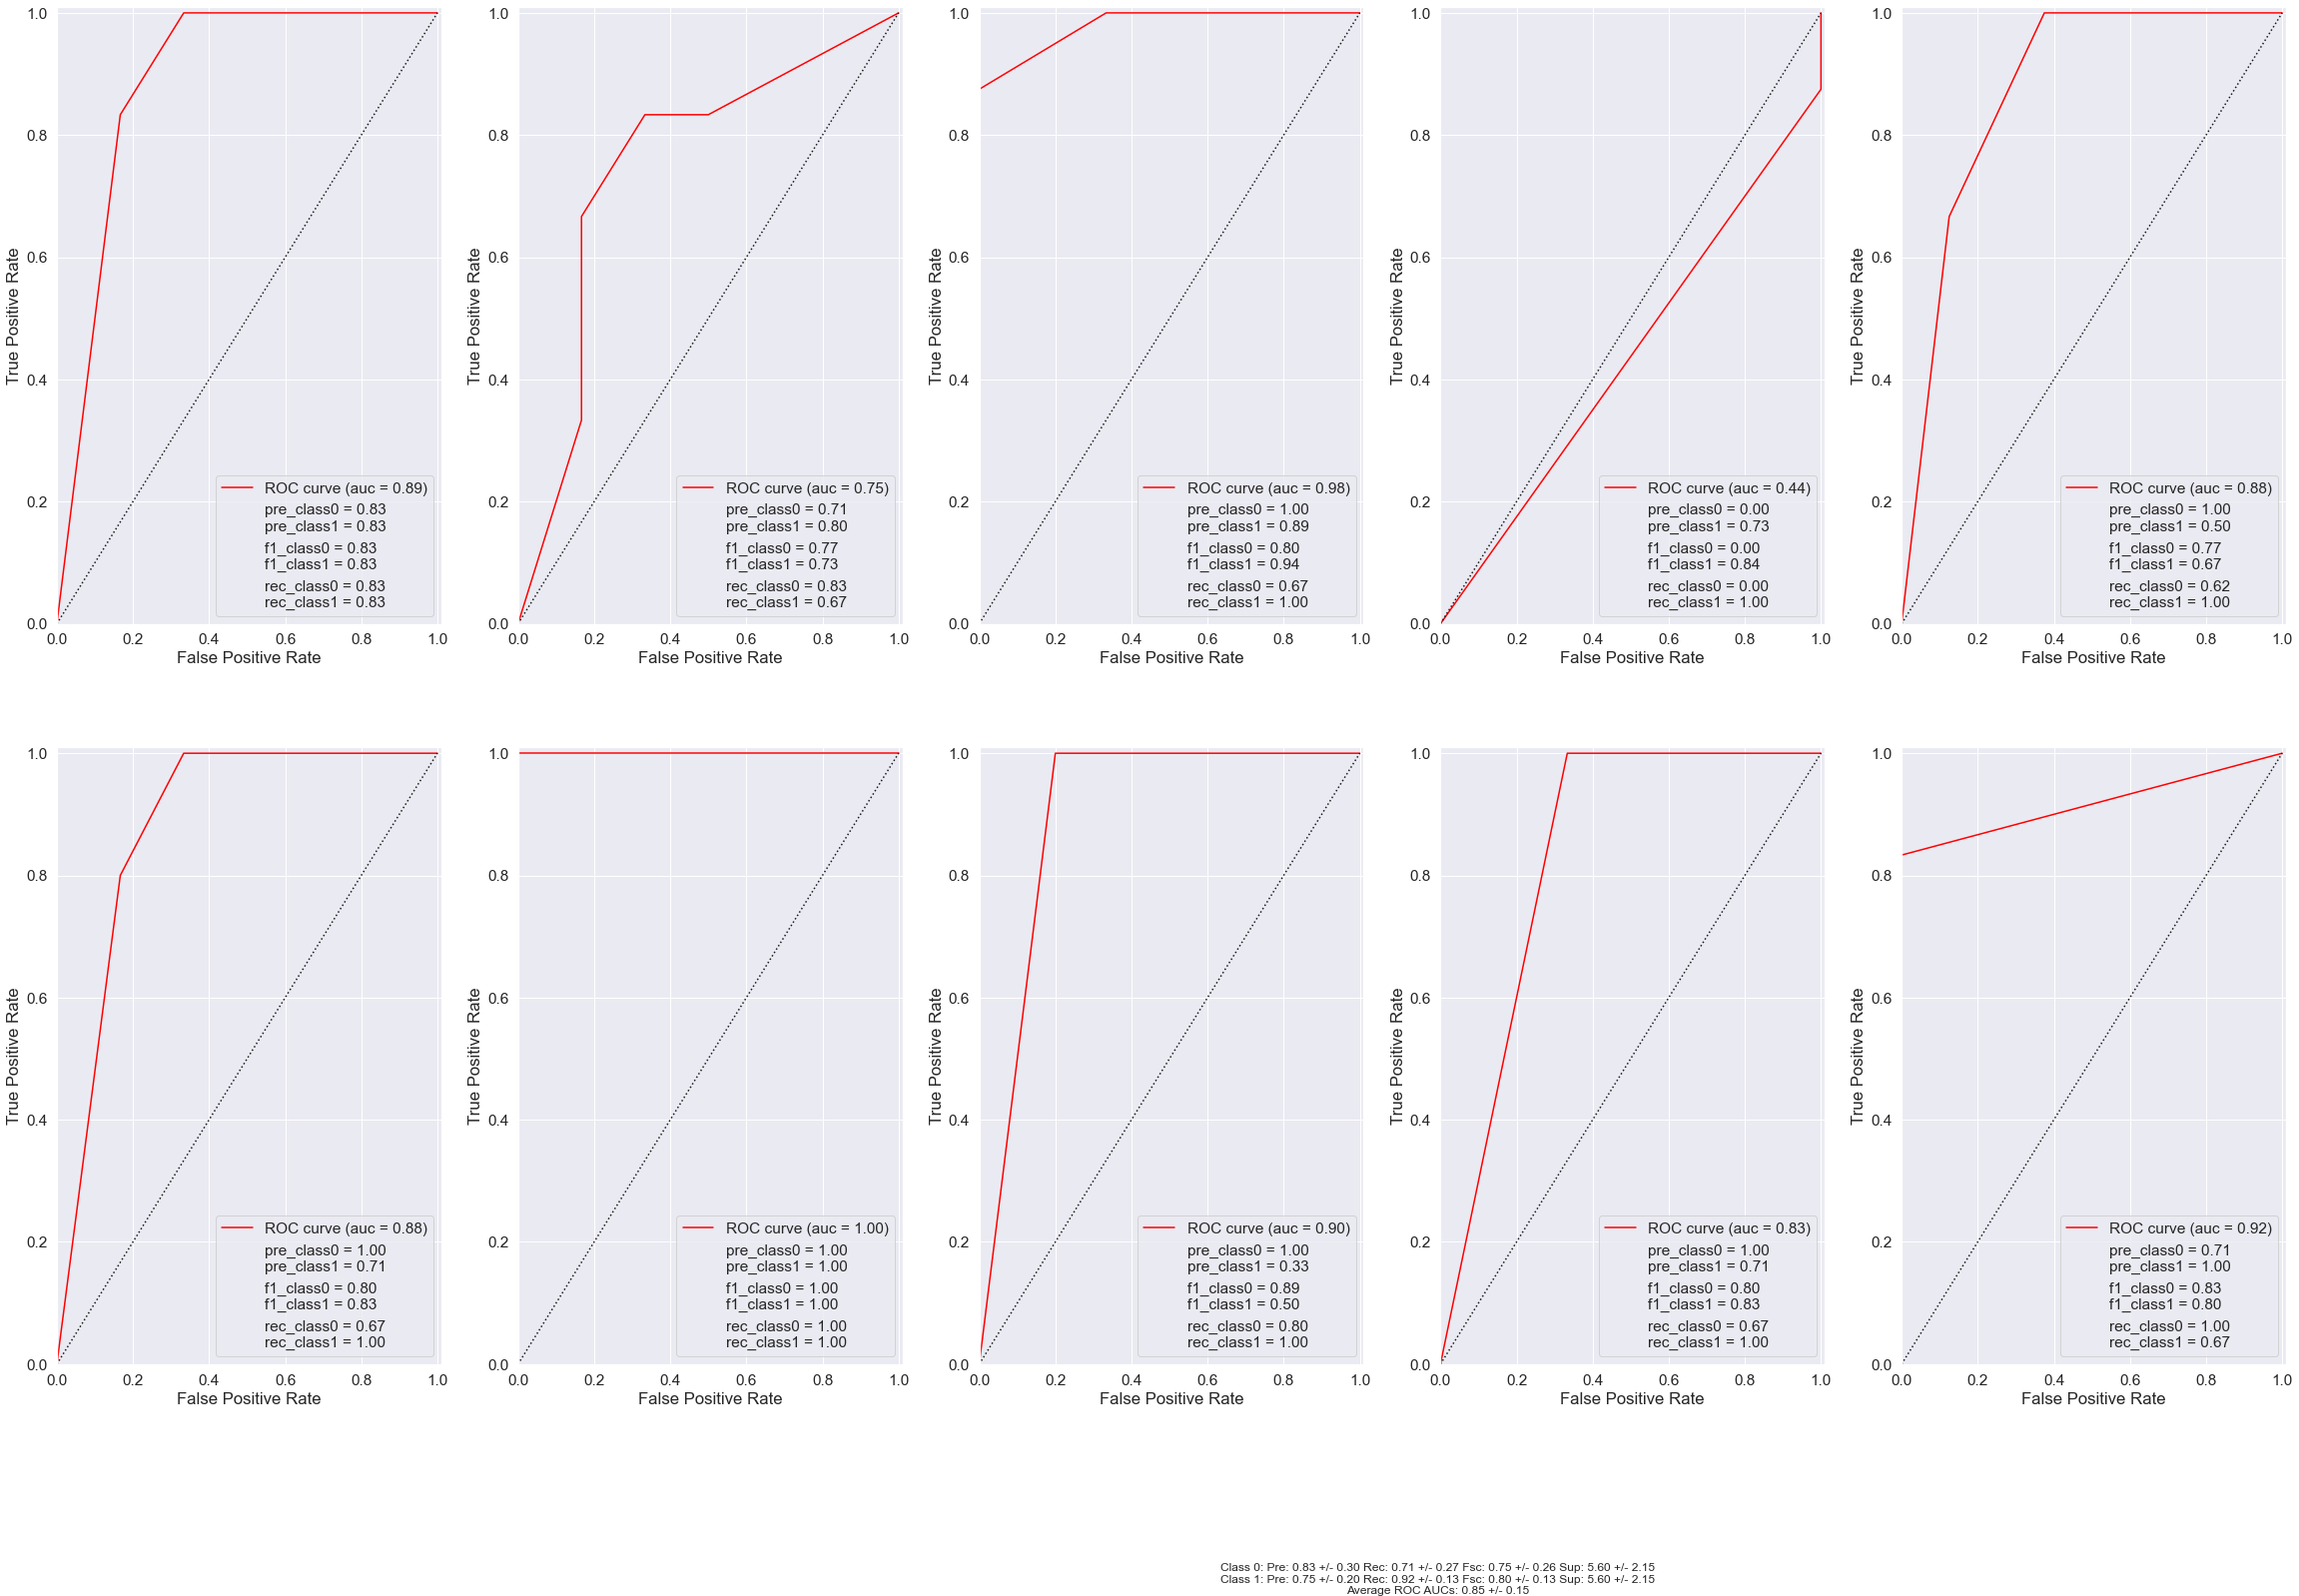


-----
Begin Gaussian Process
-----

----- Gaussian_Process: Fold 0 -----
[0, 9, 10, 27, 47, 63, 66, 79, 84, 89, 90, 99]
	Train indx [  1   2   3   4   5   6   7   8  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  67  68  69  70  71  72  73  74  75  76  77  78
  80  81  82  83  85  86  87  88  91  92  93  94  95  96  97  98 100 101
 102 103 104 105 106 107 108 109 110 111]
	Test indx: [ 0  9 10 27 47 63 66 79 84 89 90 99]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	Best parameters; {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.8640 (+/-0.1038) for {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.8640 (+/-0.1038) for {'kernel': 1**2 * Matern(length_scale=1, nu=2.5)}
	0.8620 (+/-0.1073) for {'kernel': 1**2 * RBF(length_scale=1)}
	0.8620 (+/-0.1073) for {'kernel': 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.5)}

	----- Predicting using: Gaussian_Process -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdk

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	Best parameters; {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.9030 (+/-0.0867) for {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.8970 (+/-0.0924) for {'kernel': 1**2 * Matern(length_scale=1, nu=2.5)}
	0.8990 (+/-0.0929) for {'kernel': 1**2 * RBF(length_scale=1)}
	0.8950 (+/-0.0921) for {'kernel': 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.5)}

	----- Predicting using: Gaussian_Process -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdk

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Fe

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Fe

	0.9293 (+/-0.1057) for {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.9257 (+/-0.1127) for {'kernel': 1**2 * Matern(length_scale=1, nu=2.5)}
	0.9255 (+/-0.1095) for {'kernel': 1**2 * RBF(length_scale=1)}
	0.9245 (+/-0.1112) for {'kernel': 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.5)}

	----- Predicting using: Gaussian_Process -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692:

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	Best parameters; {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.8680 (+/-0.1057) for {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
	0.8622 (+/-0.1067) for {'kernel': 1**2 * Matern(length_scale=1, nu=2.5)}
	0.8622 (+/-0.1067) for {'kernel': 1**2 * RBF(length_scale=1)}
	0.8622 (+/-0.1067) for {'kernel': 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.5)}

	----- Predicting using: Gaussian_Process -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdk

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Fe

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Fe

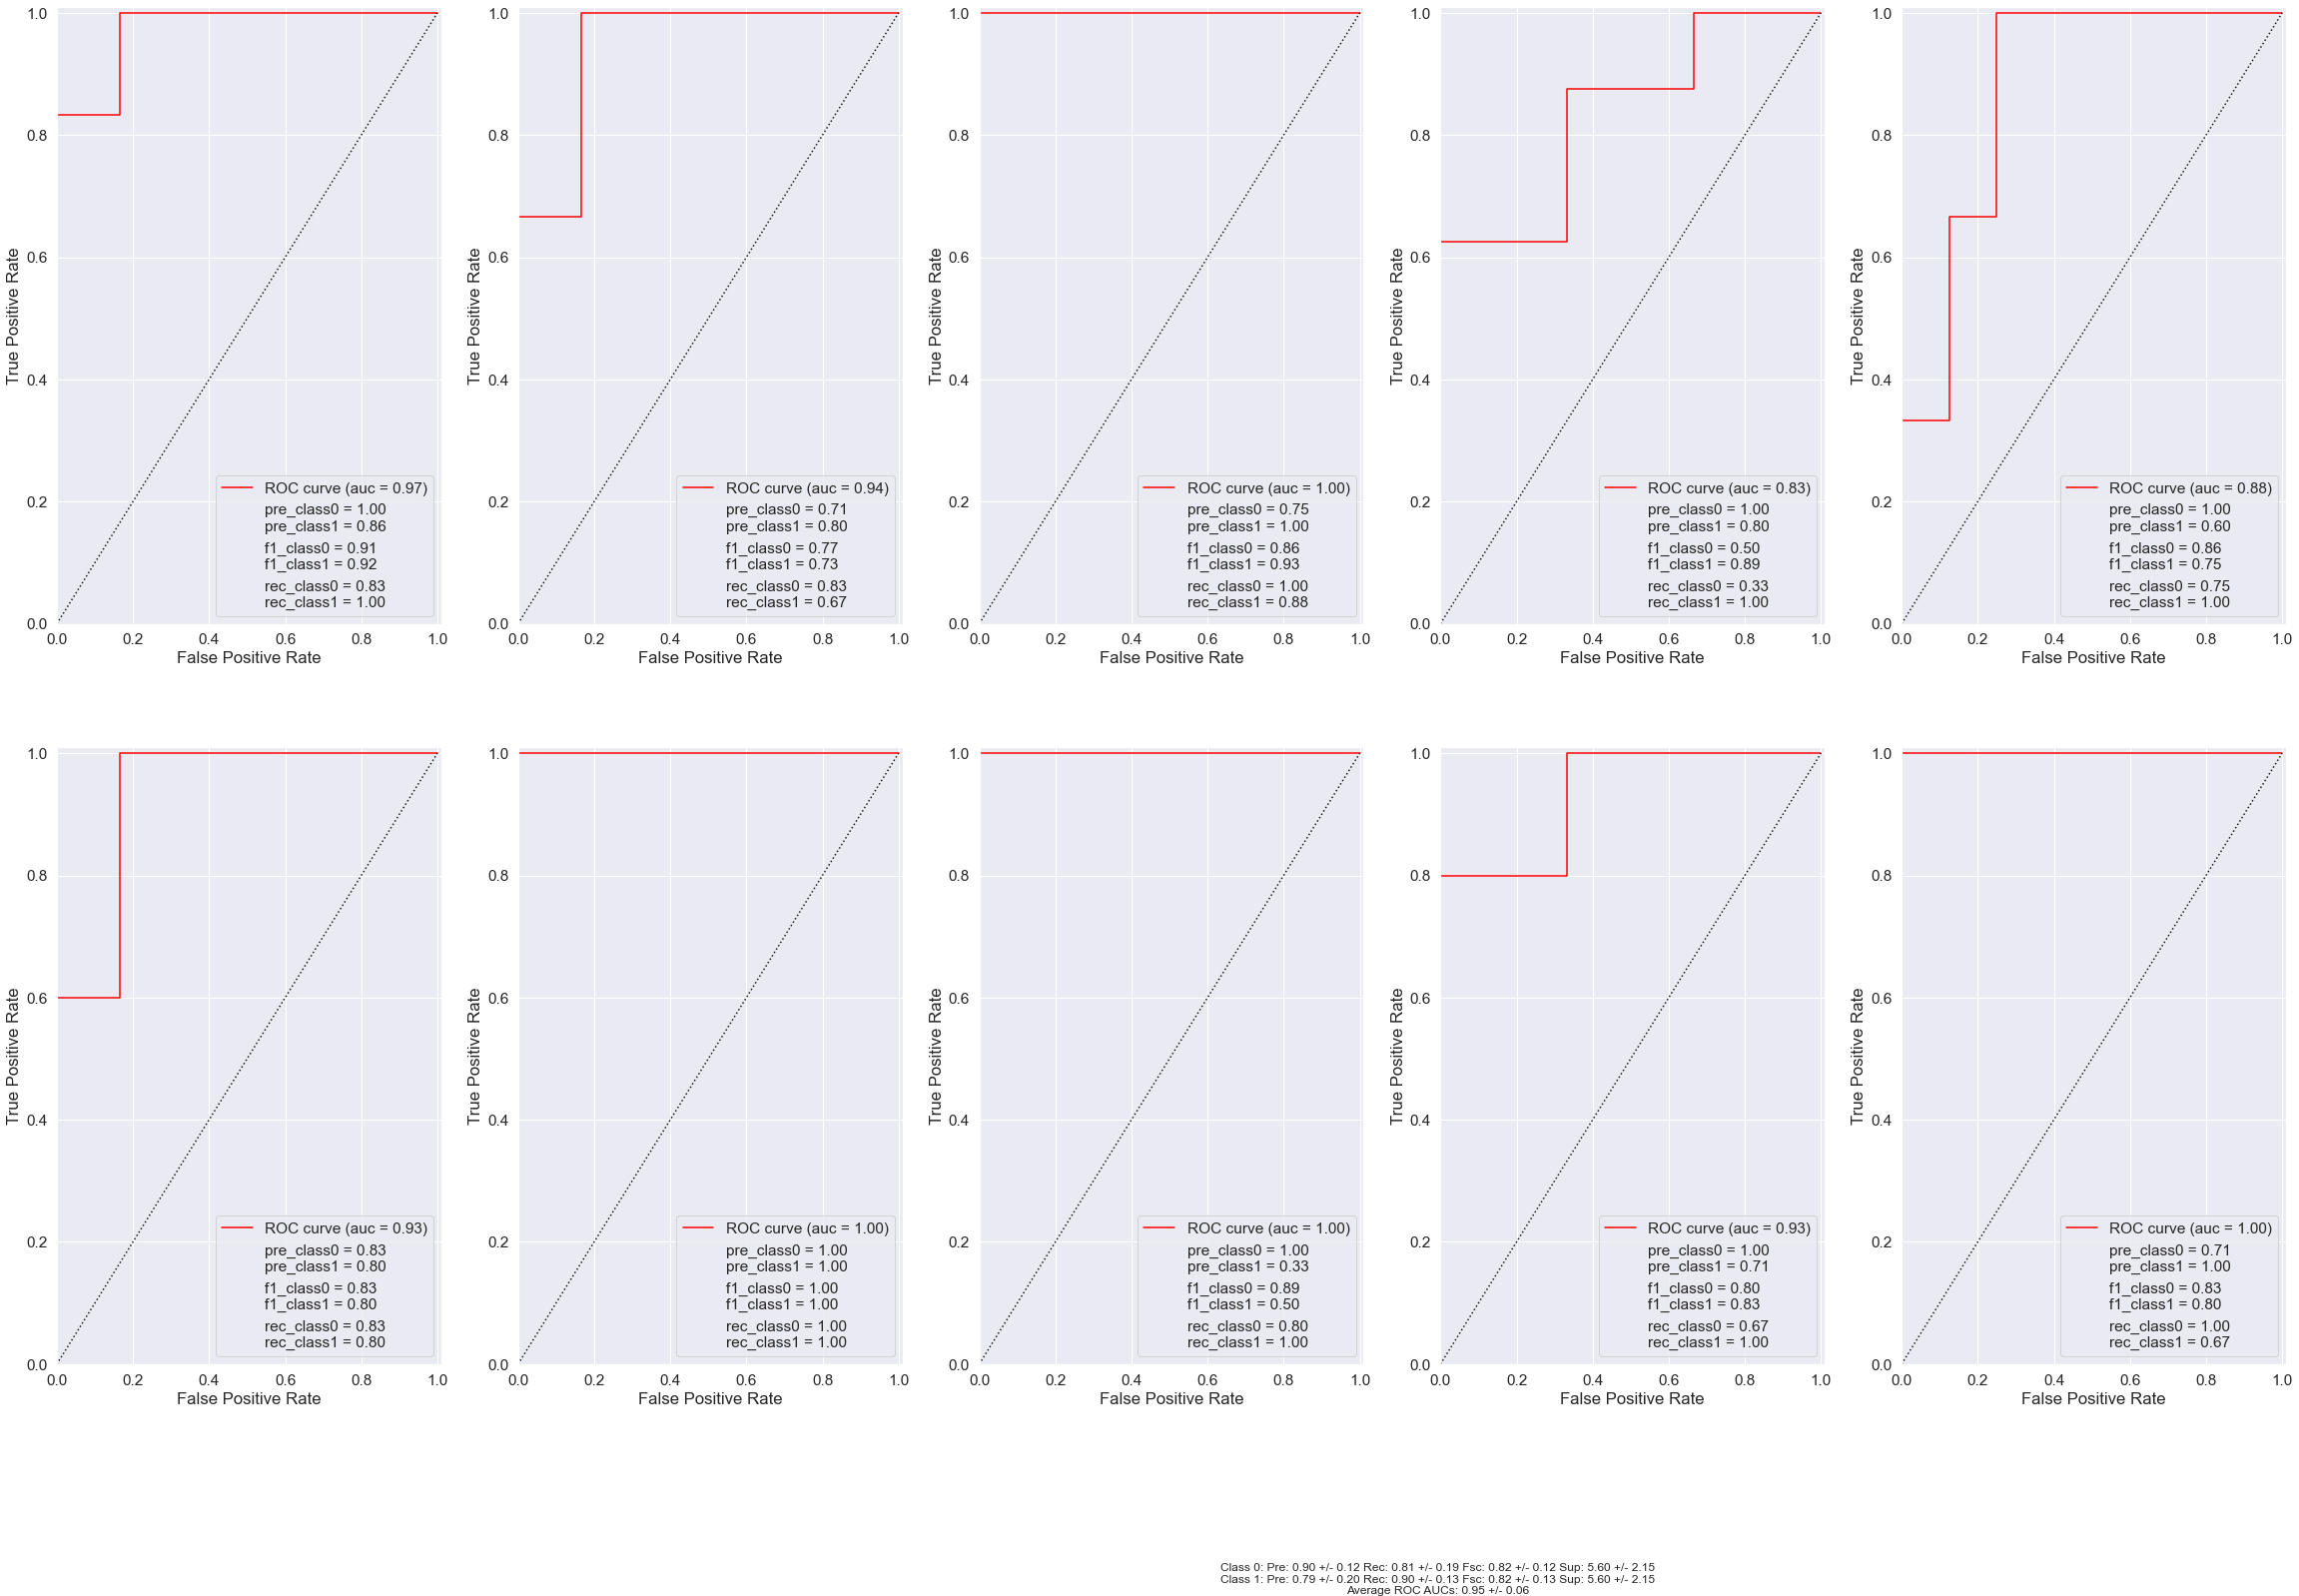


-----
Begin Decision Tree
-----

----- Decision_Tree: Fold 0 -----
[0, 9, 10, 27, 47, 63, 66, 79, 84, 89, 90, 99]
	Train indx [  1   2   3   4   5   6   7   8  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  67  68  69  70  71  72  73  74  75  76  77  78
  80  81  82  83  85  86  87  88  91  92  93  94  95  96  97  98 100 101
 102 103 104 105 106 107 108 109 110 111]
	Test indx: [ 0  9 10 27 47 63 66 79 84 89 90 99]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only suppor

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

----- Decision_Tree: Fold 2 -----
[22, 46, 50, 52, 53, 54, 72, 73, 80, 88, 109]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  47  48  49  51  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  74  75  76  77  78  79
  81  82  83  84  85  86  87  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 110 111]
	Test indx: [ 22  46  50  52  53  54  72  73  80  88 109]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all st

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	0.8139 (+/-0.1544) for {'max_depth': 2}
	0.7889 (+/-0.1645) for {'max_depth': 3}
	0.7820 (+/-0.1806) for {'max_depth': 4}
	0.7809 (+/-0.1658) for {'max_depth': 5}
	0.7909 (+/-0.1589) for {'max_depth': 7}
	0.7909 (+/-0.1589) for {'max_depth': 10}

	----- Predicting using: Decision_Tree -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due t

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

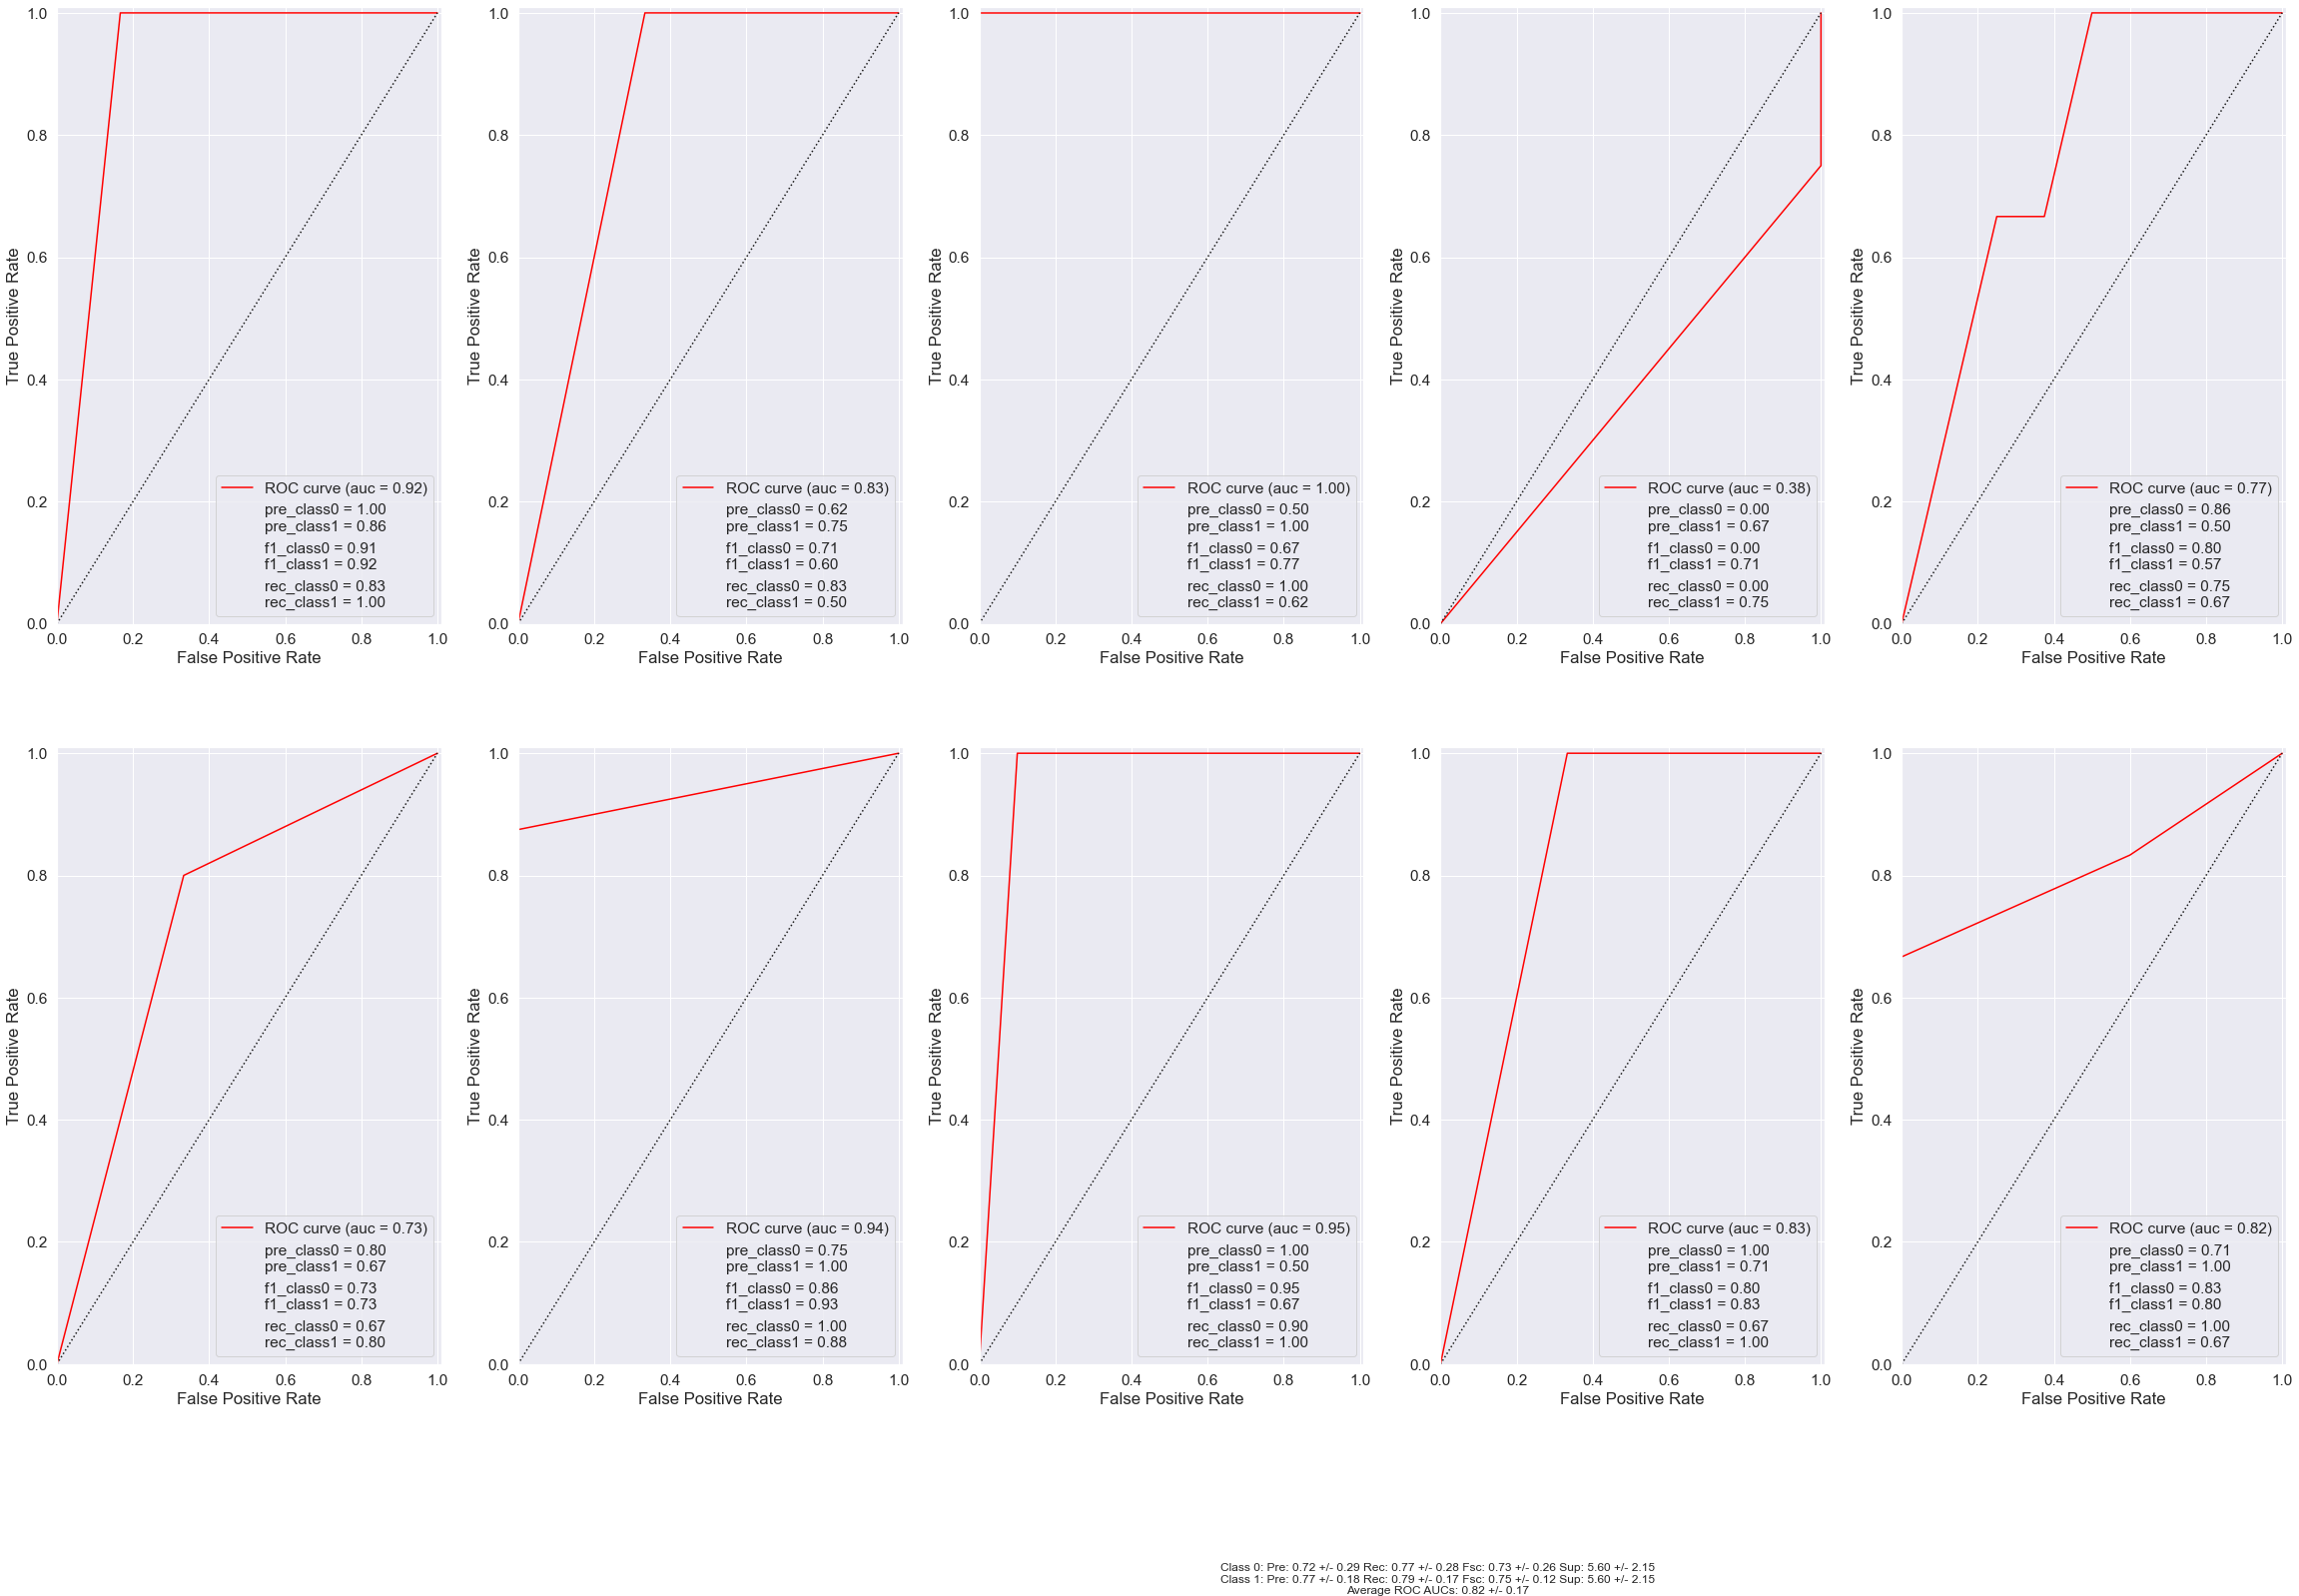


-----
Begin ExtraTreesClassifier
-----

----- ExtraTreesClassifier: Fold 0 -----
[0, 9, 10, 27, 47, 63, 66, 79, 84, 89, 90, 99]
	Train indx [  1   2   3   4   5   6   7   8  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  67  68  69  70  71  72  73  74  75  76  77  78
  80  81  82  83  85  86  87  88  91  92  93  94  95  96  97  98 100 101
 102 103 104 105 106 107 108 109 110 111]
	Test indx: [ 0  9 10 27 47 63 66 79 84 89 90 99]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature nam

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	0.8140 (+/-0.0968) for {'max_depth': 10, 'n_estimators': 100}

	----- Predicting using: ExtraTreesClassifier -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	Best parameters; {'max_depth': 3, 'n_estimators': 10}
	0.8400 (+/-0.1356) for {'max_depth': 2, 'n_estimators': 10}
	0.8070 (+/-0.1580) for {'max_depth': 2, 'n_estimators': 20}
	0.8520 (+/-0.1479) for {'max_depth': 2, 'n_estimators': 50}
	0.8550 (+/-0.1340) for {'max_depth': 2, 'n_estimators': 100}
	0.8710 (+/-0.1252) for {'max_depth': 3, 'n_estimators': 10}
	0.8400 (+/-0.1329) for {'max_depth': 3, 'n_estimators': 20}
	0.8330 (+/-0.1415) for {'max_depth': 3, 'n_estimators': 50}
	0.8390 (+/-0.1346) for {'max_depth': 3, 'n_estimators': 100}
	0.8510 (+/-0.1225) for {'max_depth': 4, 'n_estimators': 10}
	0.8210 (+/-0.1552) for {'max_depth': 4, 'n_estimators': 20}
	0.8050 (+/-0.1721) for {'max_depth': 4, 'n_estimators': 50}
	0.8250 (+/-0.1495) for {'max_depth': 4, 'n_estimators': 100}
	0.8300 (+/-0.1500) for {'max_depth': 5, 'n_estimators': 10}
	0.8250 (+/-0.1501) for {'max_depth': 5, 'n_estimators': 20}
	0.8250 (+/-0.1495) for {'max_depth': 5, 'n_estimators': 50}
	0.8370 (+/-0.1367) for {'m

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 


	score (ExtraTreesClassifier): 0.7272727272727273
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.62      1.00      0.77      0.79      0.60         8
          1       0.50      1.00      0.62      0.67      0.79      0.65         3

avg / total       0.86      0.73      0.90      0.74      0.79      0.61        11

	 Index | Predicted | Label
	------------------
	16   |   1   |   1
	30   |   0   |   0
	32   |   0   |   0
	35   |   1   |   1
	37   |   1   |   0
	58   |   0   |   0
	59   |   1   |   1
	60   |   1   |   0
	68   |   1   |   0
	94   |   0   |   0
	98   |   0   |   0
-----

----- ExtraTreesClassifier: Fold 5 -----
[11, 13, 17, 19, 28, 45, 74, 76, 91, 102, 105]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  12  14  15  16  18  20  21
  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  46  47  48  49  50  5

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due t

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
	ROC analysis area under the curve: 0.9583333333333334
	Confusion matrix (ExtraTreesClassifier):
[[3 0]
 [1 7]]


	score (ExtraTreesClassifier): 0.9090909090909091
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      1.00      0.88      0.86      0.94      0.89         3
          1       1.00      0.88      1.00      0.93      0.94      0.86 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due t

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due t

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	0.7545 (+/-0.1755) for {'max_depth': 2, 'n_estimators': 10}
	0.7875 (+/-0.1988) for {'max_depth': 2, 'n_estimators': 20}
	0.8113 (+/-0.1762) for {'max_depth': 2, 'n_estimators': 50}
	0.8156 (+/-0.1399) for {'max_depth': 2, 'n_estimators': 100}
	0.7745 (+/-0.2019) for {'max_depth': 3, 'n_estimators': 10}
	0.7548 (+/-0.2096) for {'max_depth': 3, 'n_estimators': 20}
	0.7965 (+/-0.1827) for {'max_depth': 3, 'n_estimators': 50}
	0.8214 (+/-0.1674) for {'max_depth': 3, 'n_estimators': 100}
	0.7812 (+/-0.1899) for {'max_depth': 4, 'n_estimators': 10}
	0.7748 (+/-0.1973) for {'max_depth': 4, 'n_estimators': 20}
	0.7903 (+/-0.1823) for {'max_depth': 4, 'n_estimators': 50}
	0.8345 (+/-0.1372) for {'max_depth': 4, 'n_estimators': 100}
	0.7932 (+/-0.1942) for {'max_depth': 5, 'n_estimators': 10}
	0.8071 (+/-0.1867) for {'max_depth': 5, 'n_estimators': 20}
	0.8017 (+/-0.1831) for {'max_depth': 5, 'n_estimators': 50}
	0.8668 (+/-0.1175) for {'max_depth': 5, 'n_estimators': 100}
	0.7932 (+/-0.1822) 

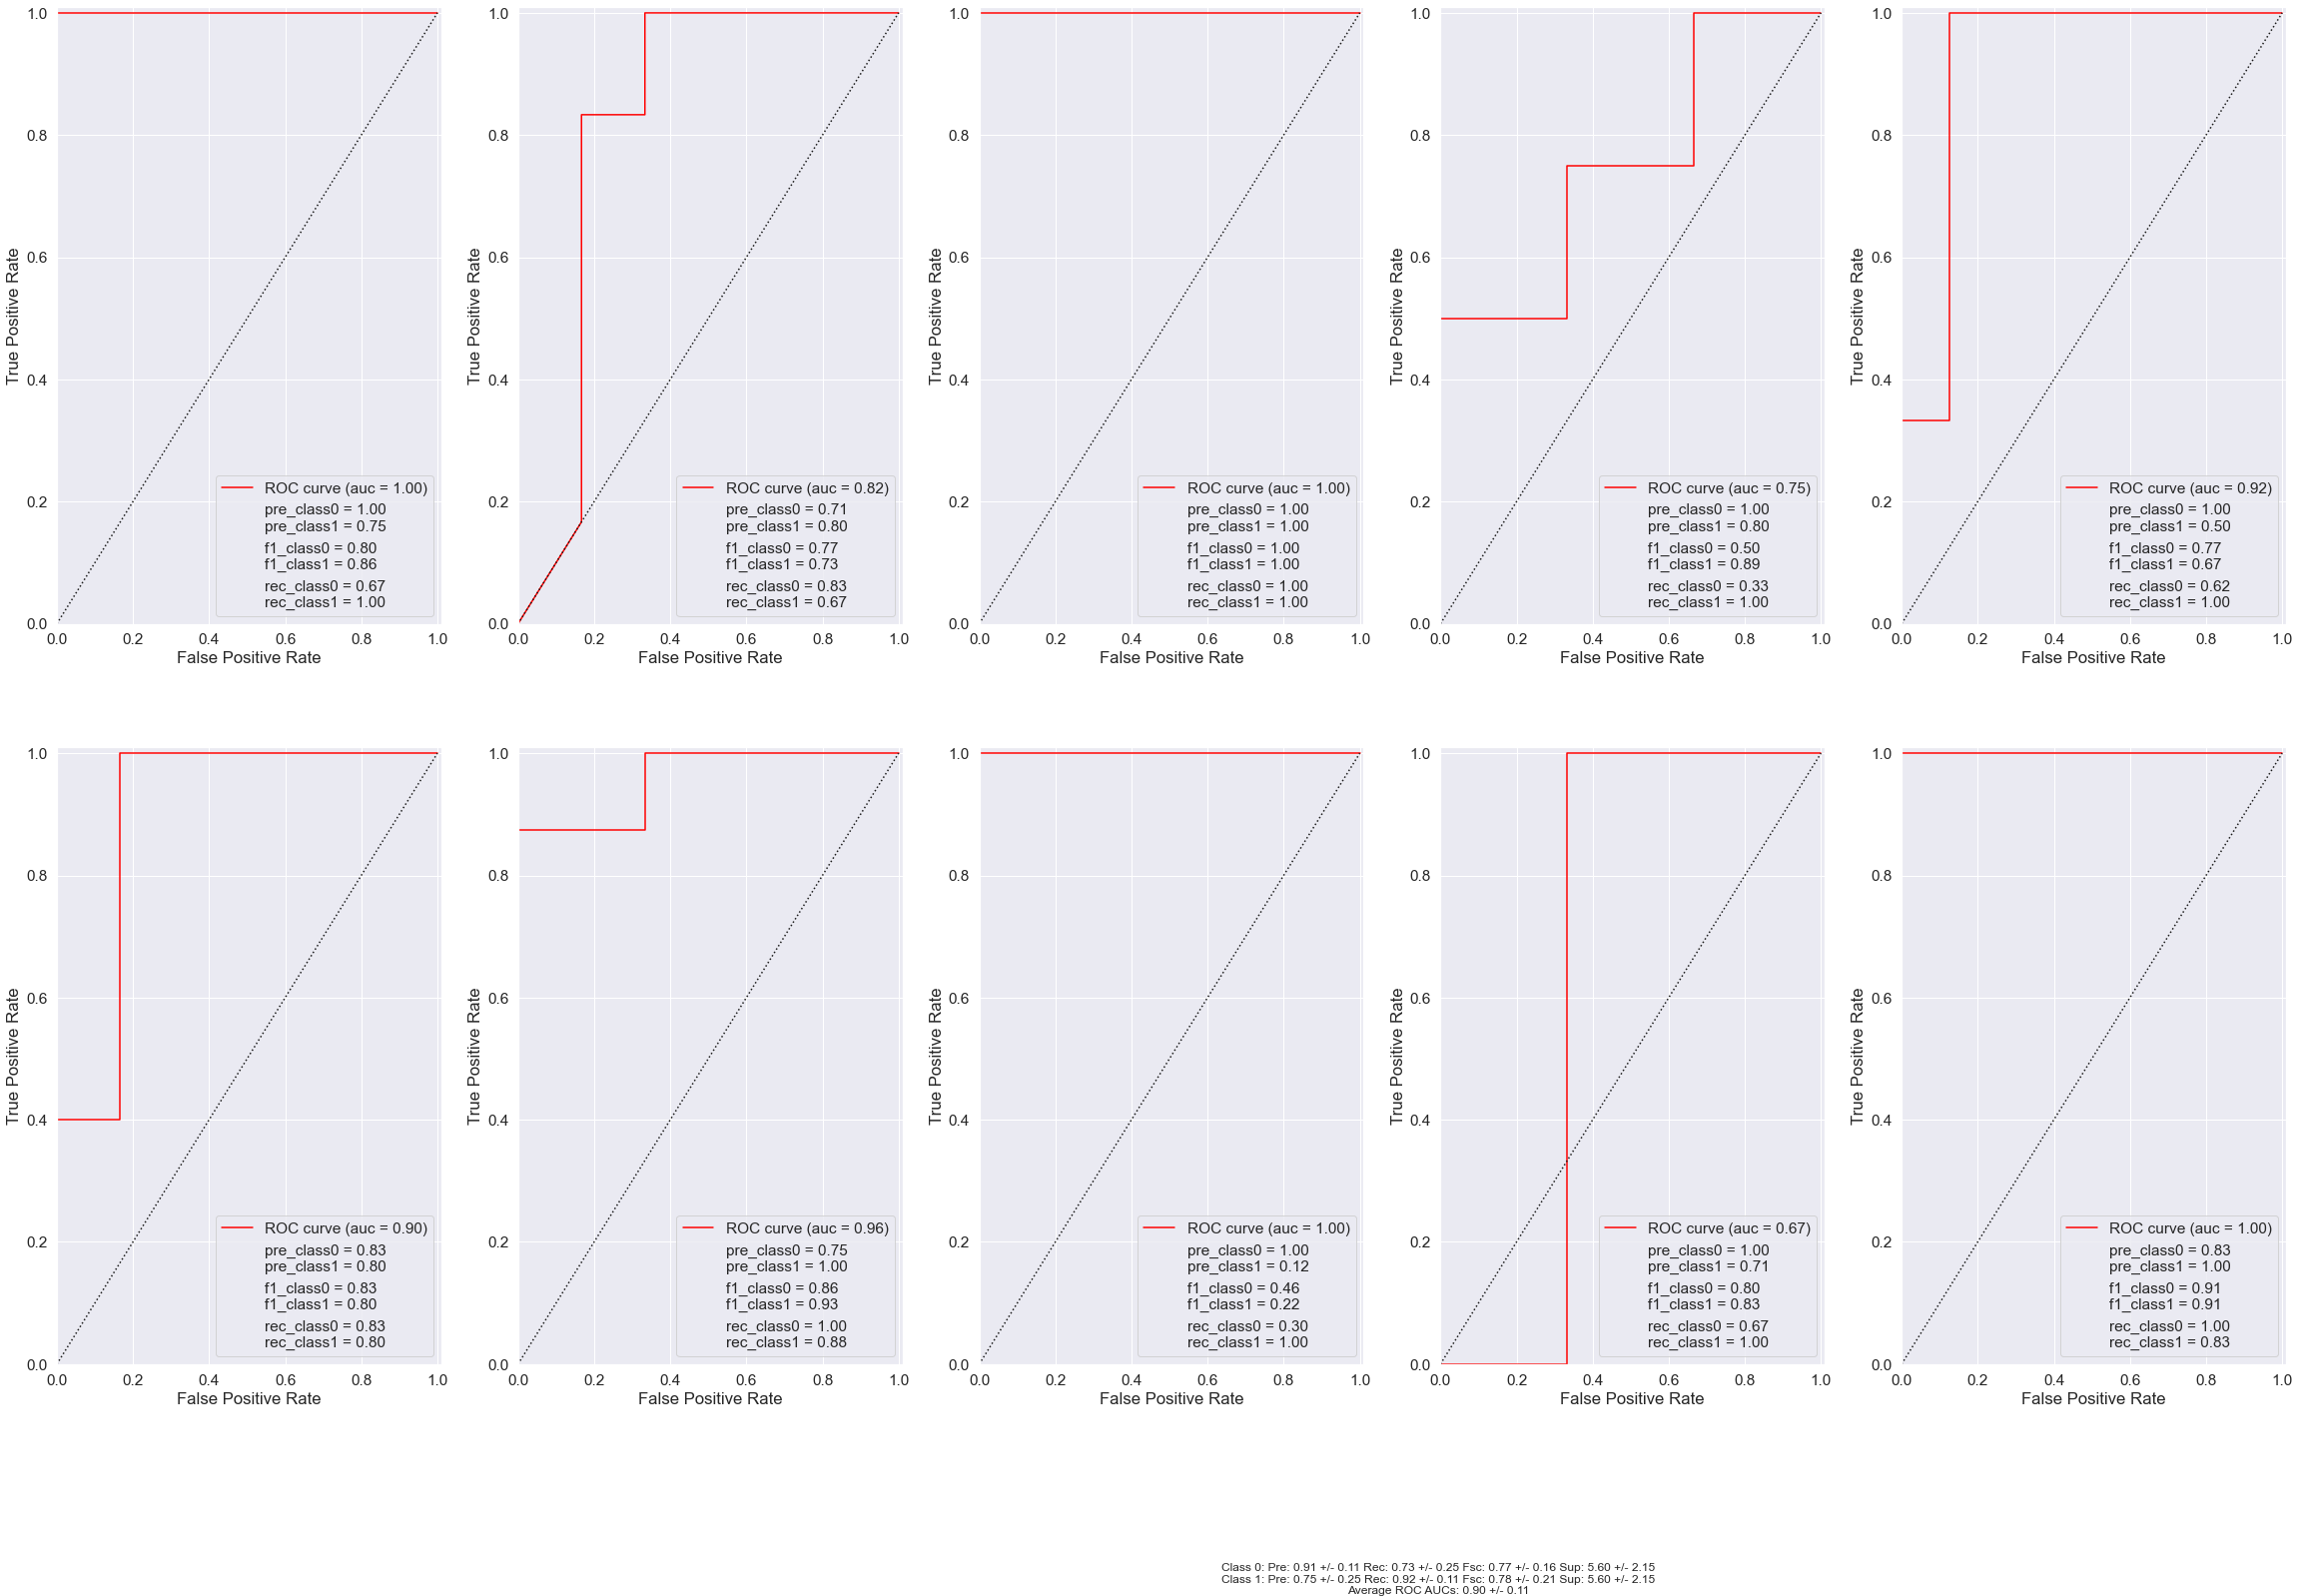


-----
Begin AdaBoost
-----

----- AdaBoost: Fold 0 -----
[0, 9, 10, 27, 47, 63, 66, 79, 84, 89, 90, 99]
	Train indx [  1   2   3   4   5   6   7   8  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  67  68  69  70  71  72  73  74  75  76  77  78
  80  81  82  83  85  86  87  88  91  92  93  94  95  96  97  98 100 101
 102 103 104 105 106 107 108 109 110 111]
	Test indx: [ 0  9 10 27 47 63 66 79 84 89 90 99]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names th

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 


	score (AdaBoost): 0.8333333333333334
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.67      1.00      0.80      0.82      0.64         6
          1       0.75      1.00      0.67      0.86      0.82      0.69         6

avg / total       0.88      0.83      0.83      0.83      0.82      0.67        12

	 Index | Predicted | Label
	------------------
	0   |   0   |   0
	9   |   1   |   0
	10   |   1   |   0
	27   |   1   |   1
	47   |   1   |   1
	63   |   1   |   1
	66   |   0   |   0
	79   |   1   |   1
	84   |   1   |   1
	89   |   1   |   1
	90   |   0   |   0
	99   |   0   |   0
-----

----- AdaBoost: Fold 1 -----
[5, 6, 18, 31, 33, 39, 56, 57, 75, 78, 103, 108]
	Train indx [  0   1   2   3   4   7   8   9  10  11  12  13  14  15  16  17  19  20
  21  22  23  24  25  26  27  28  29  30  32  34  35  36  37  38  40  41
  42  43  44  45  46  47  48  49  50  51  5

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 


	score (AdaBoost): 0.7272727272727273
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.50      1.00      0.62      0.67      0.79      0.65         3
          1       1.00      0.62      1.00      0.77      0.79      0.60         8

avg / total       0.86      0.73      0.90      0.74      0.79      0.61        11

	 Index | Predicted | Label
	------------------
	22   |   1   |   1
	46   |   1   |   1
	50   |   1   |   1
	52   |   0   |   1
	53   |   0   |   1
	54   |   0   |   1
	72   |   0   |   0
	73   |   0   |   0
	80   |   1   |   1
	88   |   1   |   1
	109   |   0   |   0
-----

----- AdaBoost: Fold 3 -----
[8, 14, 24, 42, 48, 51, 61, 64, 71, 81, 83]
	Train indx [  0   1   2   3   4   5   6   7   9  10  11  12  13  15  16  17  18  19
  20  21  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  43  44  45  46  47  49  50  52  53  54  55  56  57 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
	Best parameters; {'n_estimators': 100}
	0.7595 (+/-0.1378) for {'n_estimators': 10}
	0.7695 (+/-0.1421) for {'n_estimators': 20}
	0.7745 (+/-0.1453) for {'n_estimators': 50}
	0.7863 (+/-0.1386) for {'n_estimators': 100}

	----- Predicting using: AdaBoost -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names wit

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due t

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due t

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

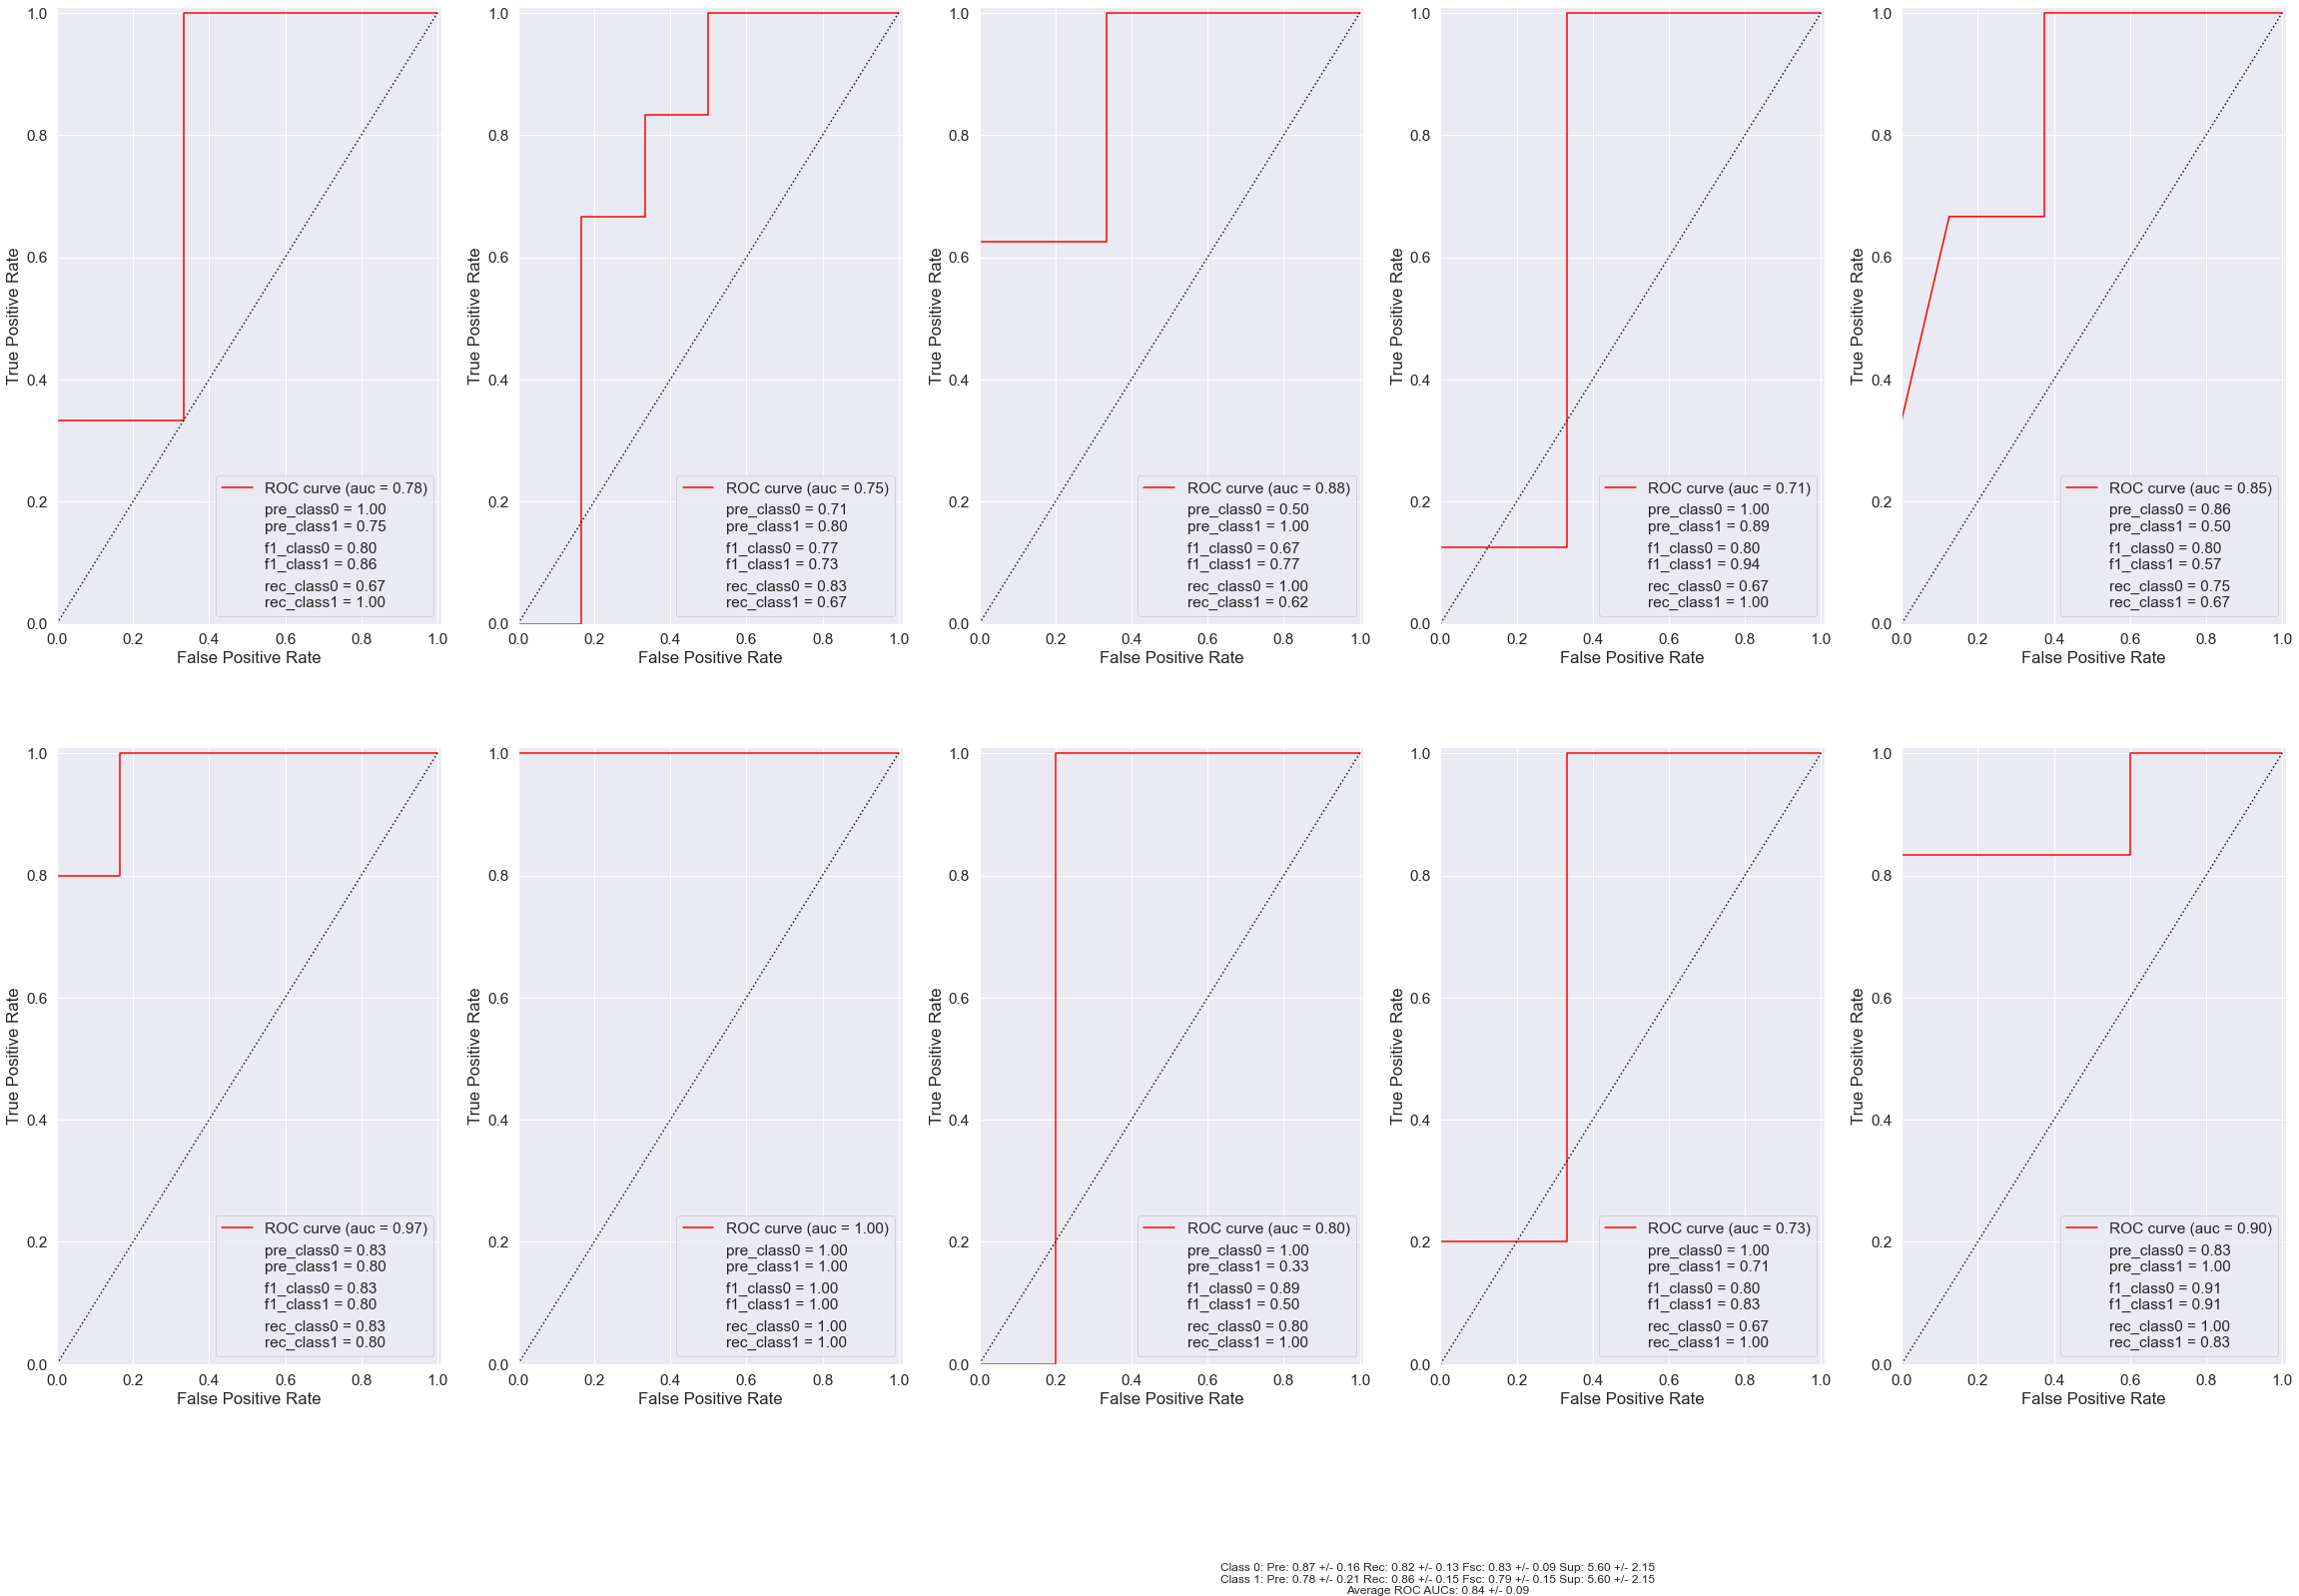


-----
Begin Logistic Regression
-----

----- Logistic_Regression: Fold 0 -----
[0, 9, 10, 27, 47, 63, 66, 79, 84, 89, 90, 99]
	Train indx [  1   2   3   4   5   6   7   8  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  64  65  67  68  69  70  71  72  73  74  75  76  77  78
  80  81  82  83  85  86  87  88  91  92  93  94  95  96  97  98 100 101
 102 103 104 105 106 107 108 109 110 111]
	Test indx: [ 0  9 10 27 47 63 66 79 84 89 90 99]
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
	Best parameters; {'C': 0.25, 'penalty': 'l2'}
	0.8190 (+/-0.1596) for {'C': 0.05, 'penalty': 'l2'}
	0.8190 (+/-0.1646) for {'C': 0.1, 'penalty': 'l2'}
	0.8210 (+/-0.1710) for {'C': 0.25,

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	0.8082 (+/-0.1795) for {'C': 0.1, 'penalty': 'l2'}
	0.8100 (+/-0.1851) for {'C': 0.25, 'penalty': 'l2'}
	0.8080 (+/-0.1884) for {'C': 0.5, 'penalty': 'l2'}
	0.8157 (+/-0.1803) for {'C': 1.0, 'penalty': 'l2'}
	0.8157 (+/-0.1803) for {'C': 1.25, 'penalty': 'l2'}

	----- Predicting using: Logistic_Regression -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only suppo

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	Confusion matrix (Logistic_Regression):
[[1 2]
 [1 7]]


	score (Logistic_Regression): 0.7272727272727273
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.50      0.33      0.88      0.40      0.54      0.28         3
          1       0.78      0.88      0.33      0.82      0.54      0.31         8

avg / total       0.70      0.73      0.48      0.71      0.54      0.30        11

	 Index | Predicted | Label
	------------------
	8   |   0   |   1
	14   |   1   |   1
	24   |   1   |   1
	42   |   1   |   1
	48   |   1   |   0
	51   |   1   |   1
	61   |   0   |   0
	64   |   1   |   0
	71   |   1   |   1
	81   |   1   |   1
	83   |   1   |   1
-----

----- Logistic_Regression: Fold 4 -----
[16, 30, 32, 35, 37, 58, 59, 60, 68, 94, 98]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18
  19  20  21  22  23  24  25  26  27  28  29  31  33  34  36

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	Confusion matrix (Logistic_Regression):
[[5 3]
 [0 3]]


	score (Logistic_Regression): 0.7272727272727273
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.62      1.00      0.77      0.79      0.60         8
          1       0.50      1.00      0.62      0.67      0.79      0.65         3

avg / total       0.86      0.73      0.90      0.74      0.79      0.61        11

	 Index | Predicted | Label
	------------------
	16   |   1   |   1
	30   |   0   |   0
	32   |   0   |   0
	35   |   1   |   1
	37   |   1   |   0
	58   |   0   |   0
	59   |   1   |   1
	60   |   1   |   0
	68   |   1   |   0
	94   |   0   |   0
	98   |   0   |   0
-----

----- Logistic_Regression: Fold 5 -----
[11, 13, 17, 19, 28, 45, 74, 76, 91, 102, 105]
	Train indx [  0   1   2   3   4   5   6   7   8   9  10  12  14  15  16  18  20  21
  22  23  24  25  26  27  29  30  31  32  33  34  35  36 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	0.8314 (+/-0.1574) for {'C': 0.1, 'penalty': 'l2'}
	0.8232 (+/-0.1591) for {'C': 0.25, 'penalty': 'l2'}
	0.8192 (+/-0.1663) for {'C': 0.5, 'penalty': 'l2'}
	0.8194 (+/-0.1631) for {'C': 1.0, 'penalty': 'l2'}
	0.8154 (+/-0.1603) for {'C': 1.25, 'penalty': 'l2'}

	----- Predicting using: Logistic_Regression -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only suppo

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	Best parameters; {'C': 0.05, 'penalty': 'l2'}
	0.8326 (+/-0.1383) for {'C': 0.05, 'penalty': 'l2'}
	0.8043 (+/-0.1647) for {'C': 0.1, 'penalty': 'l2'}
	0.8019 (+/-0.1670) for {'C': 0.25, 'penalty': 'l2'}
	0.7936 (+/-0.1750) for {'C': 0.5, 'penalty': 'l2'}
	0.7856 (+/-0.1700) for {'C': 1.0, 'penalty': 'l2'}
	0.7856 (+/-0.1700) for {'C': 1.25, 'penalty': 'l2'}

	----- Predicting using: Logistic_Regression -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/l

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names on

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
	Best parameters; {'C': 0.5, 'penalty': 'l2'}
	0.7941 (+/-0.1721) for {'C': 0.05, 'penalty': 'l2'}
	0.7861 (+/-0.1723) for {'C': 0.1, 'penalty': 'l2'}
	0.7937 (+/-0.1548) for {'C': 0.25, 

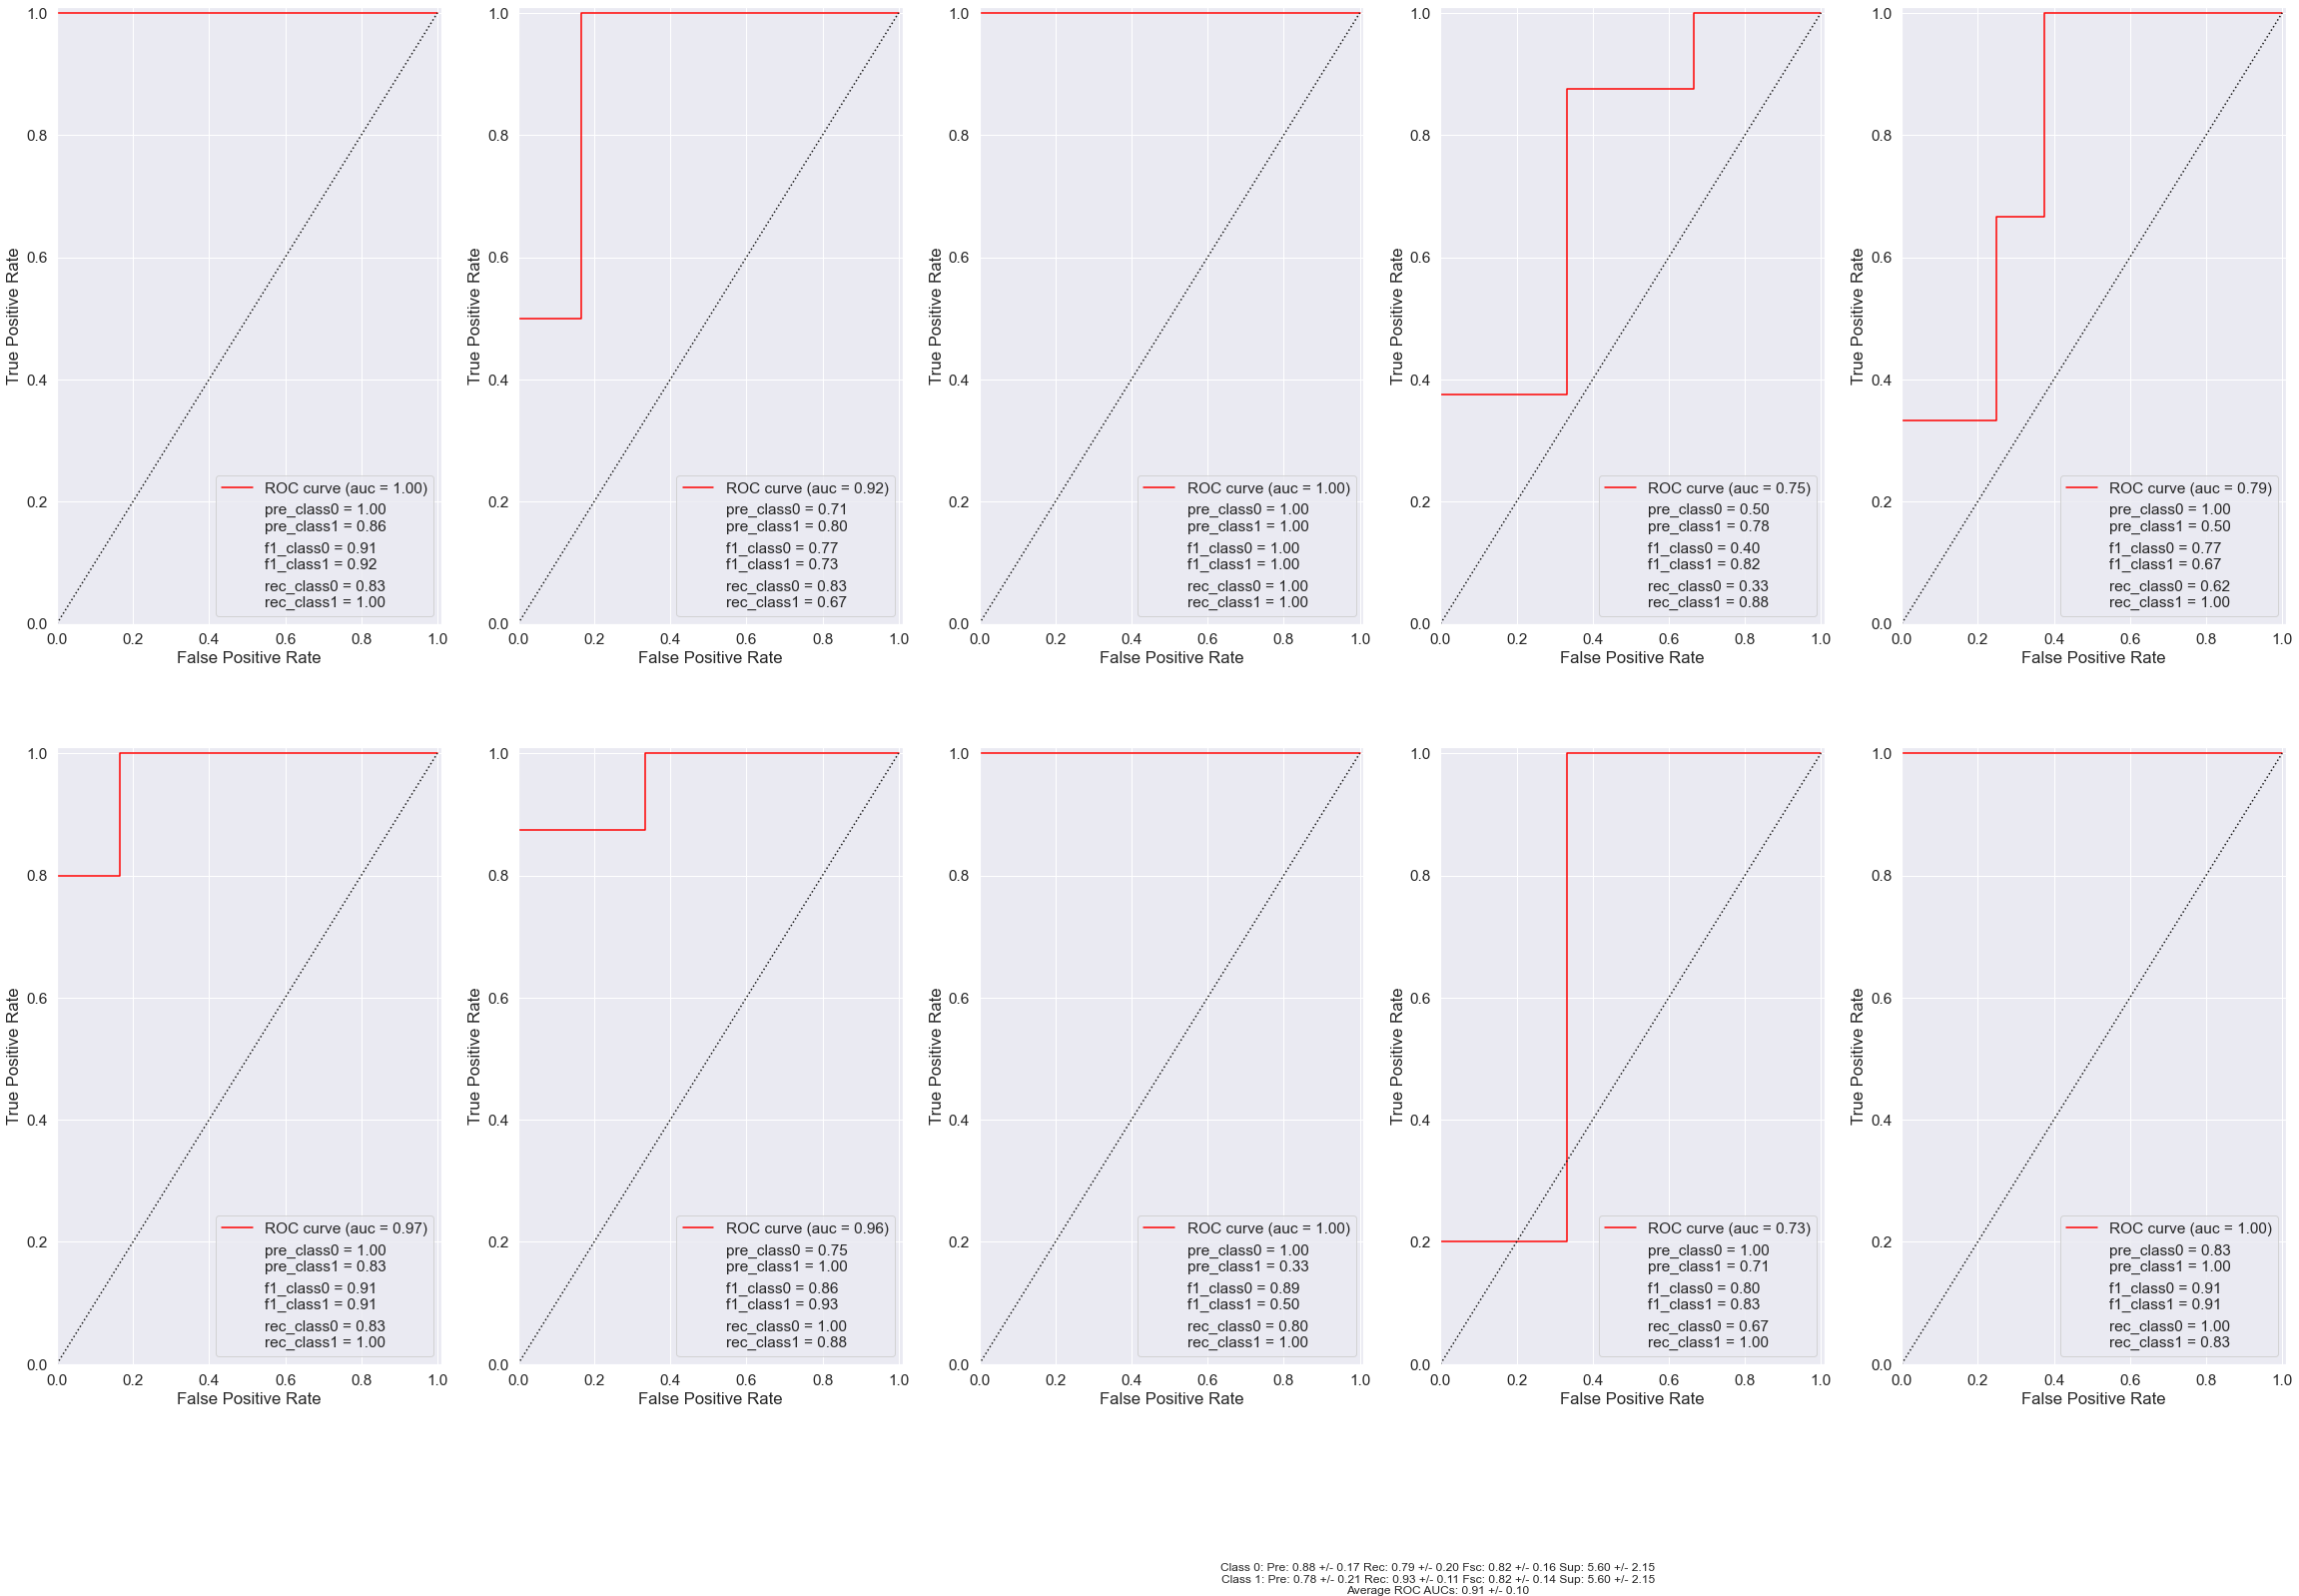

In [196]:
cwf.kfold_test_imbalenced_classifiers_with_optimization(features_smote_df, classes_smote_df, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, scale=False, cv=5, n_repeats=10, smiles=None, names=None,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1))

In [197]:
directory_names = cwf.directory_names_from_classfier_names(kfold_clf_names)

In [198]:
directory_names

['Nearest_Neighbors',
 'Gaussian_Process',
 'Decision_Tree',
 'ExtraTreesClassifier',
 'AdaBoost',
 'Logistic_Regression']

## Analyses the output over all folds and predictions therefore for all moleucles
The next cell reads in the predictions from each fold (n_repeats max_folds should = n_repeats).


Nearest_Neighbors
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_nearest_neighbors_morderd.png
['ddg_nearest_neighbors_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 41, 'fp': 15, 'fn': 5, 'tp': 51}
[[41 15]
 [ 5 51]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Gaussian_Process
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_gaussian_process_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 45, 'fp': 11, 'fn': 6, 'tp': 50}
[[45 11]
 [ 6 50]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Decision_Tree
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_decision_tree_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 44, 'fp': 12, 'fn': 13, 'tp': 43}
[[44 12]
 [13 43]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

ExtraTreesClassifier
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_extratreesclassifier_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png', 'ddg_extratreesclassifier_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 38, 'fp': 18, 'fn': 5, 'tp': 51}
[[38 18]
 [ 5 51]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

AdaBoost
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_adaboost_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png', 'ddg_extratreesclassifier_morderd.png', 'ddg_adaboost_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 45, 'fp': 11, 'fn': 8, 'tp': 48}
[[45 11]
 [ 8 48]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Logistic_Regression
-------------

Reading 0.csv
Reading 1.csv
Reading 2.csv
Reading 3.csv
Reading 4.csv
Reading 5.csv
Reading 6.csv
Reading 7.csv
Reading 8.csv
Reading 9.csv
Saving plot to ddg_logistic_regression_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png', 'ddg_extratreesclassifier_morderd.png', 'ddg_adaboost_morderd.png', 'ddg_logistic_regression_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 44, 'fp': 12, 'fn': 5, 'tp': 51}
[[44 12]
 [ 5 51]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &  sensitivity &  specificity &       mcc &  precision &    g-mean \\
\midrule
nearest neighbors      &  0.821429 &     0.910714 &     0.732143 &  0.653359 &   0.772727 &  0.816562 \\
gaussian process       &  0.848214 &     0.892857 &     0.803571 &  0.699221 &   0.819672 &  0.847039 \\
decision tree          &  0.776786 &     0.767857 &     0.785714 &  0.553660 &   0.781818 &  0.776734 \\
extra trees classifier &  0.794643 &     0.910714 &     0.678571 &  0.605836 &   0.739130 &  0.786120 \\
adaboost               &  0.830357 &     0.857143 &     0.803571 &  0.661664 &   0.813559 &  0.829925 \\
logistic regression    &  0.848214 &     0.910714 &     0.785714 &  0.701934 &   0.809524 &  0.845909 \\
\bottomrule
\end{tabular}



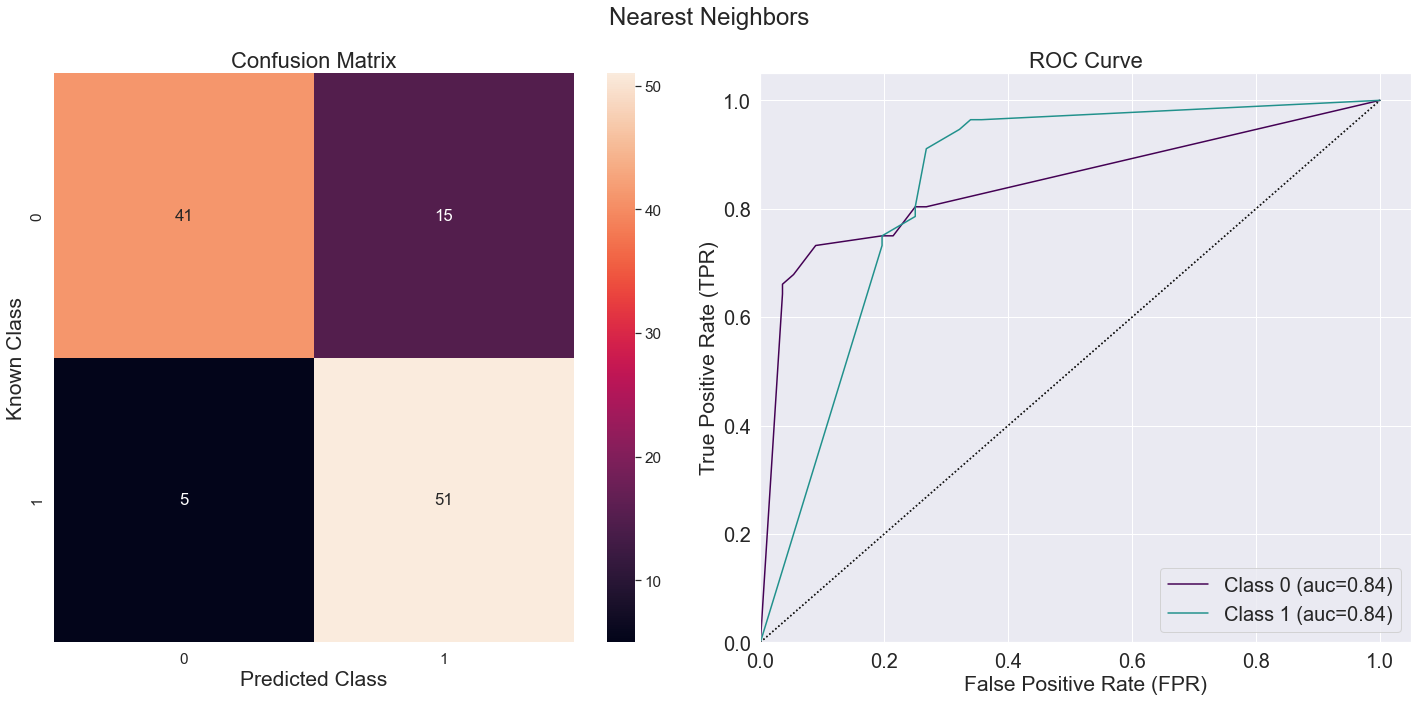

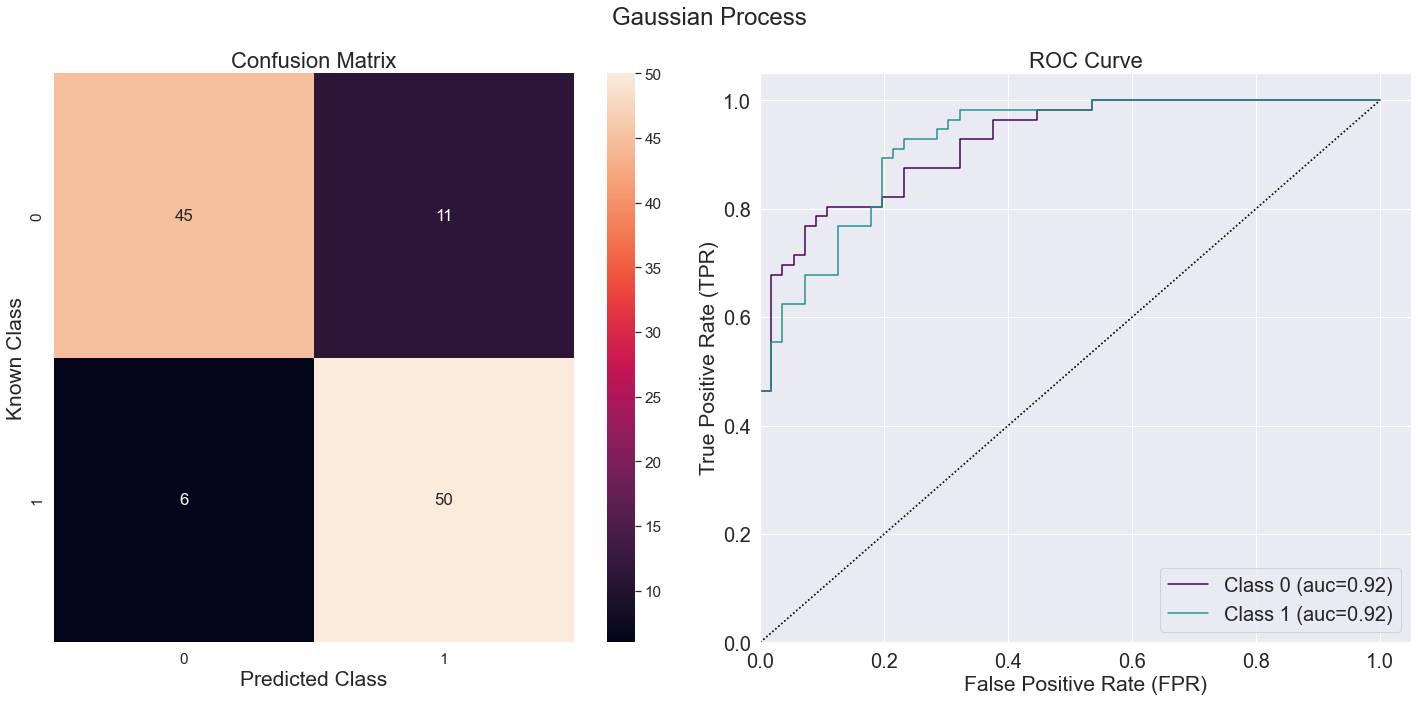

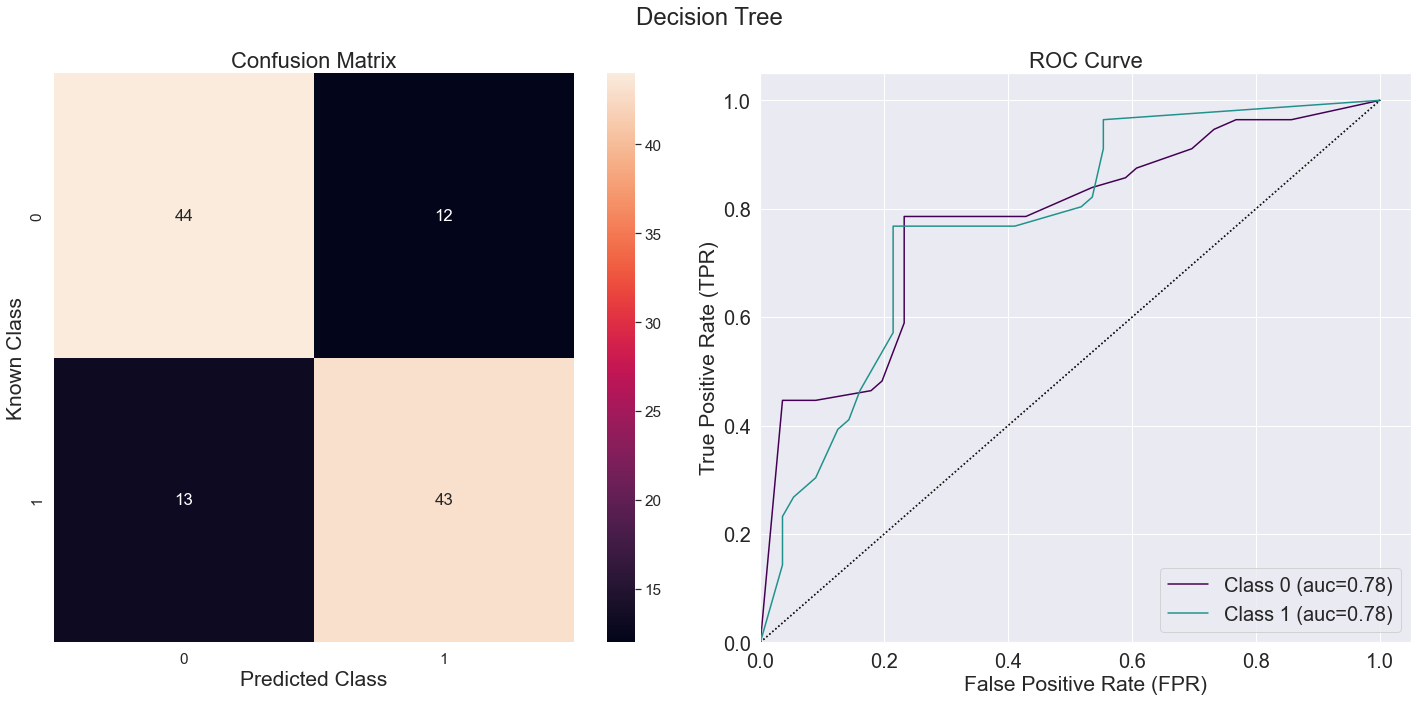

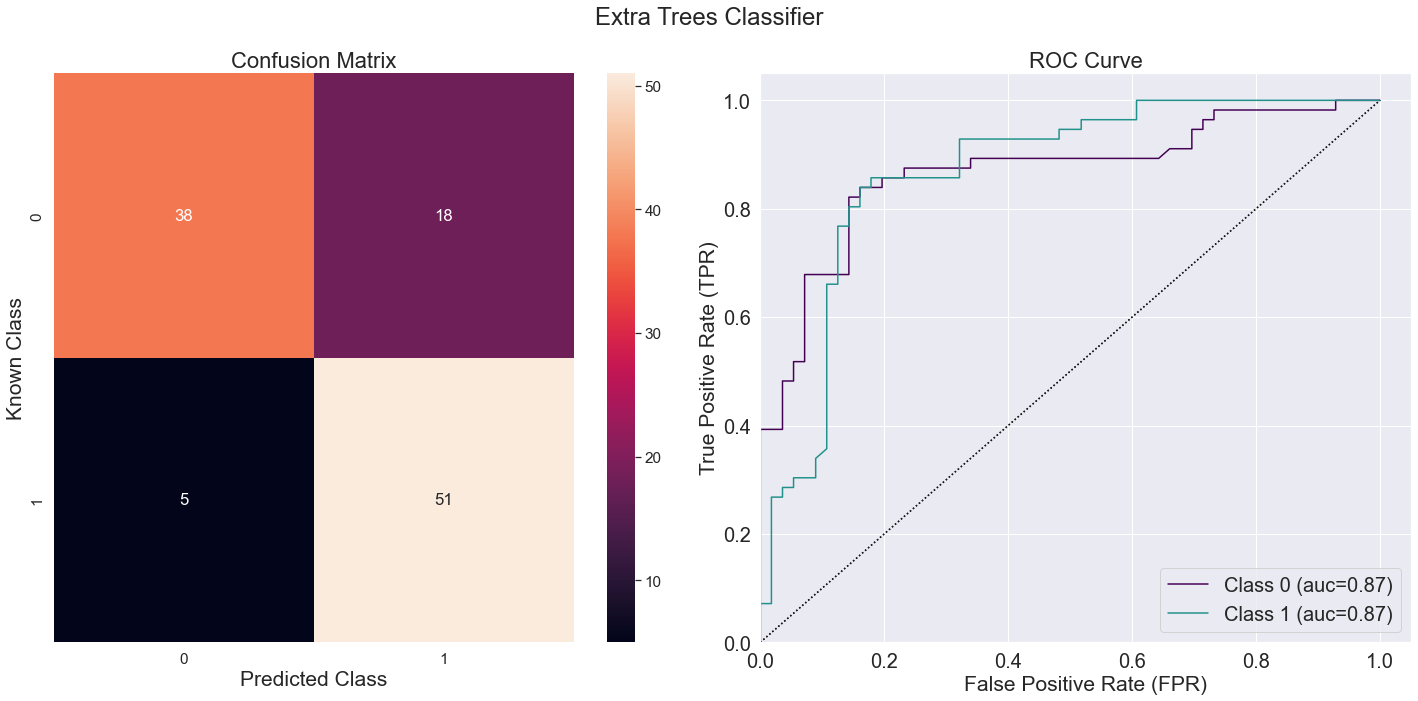

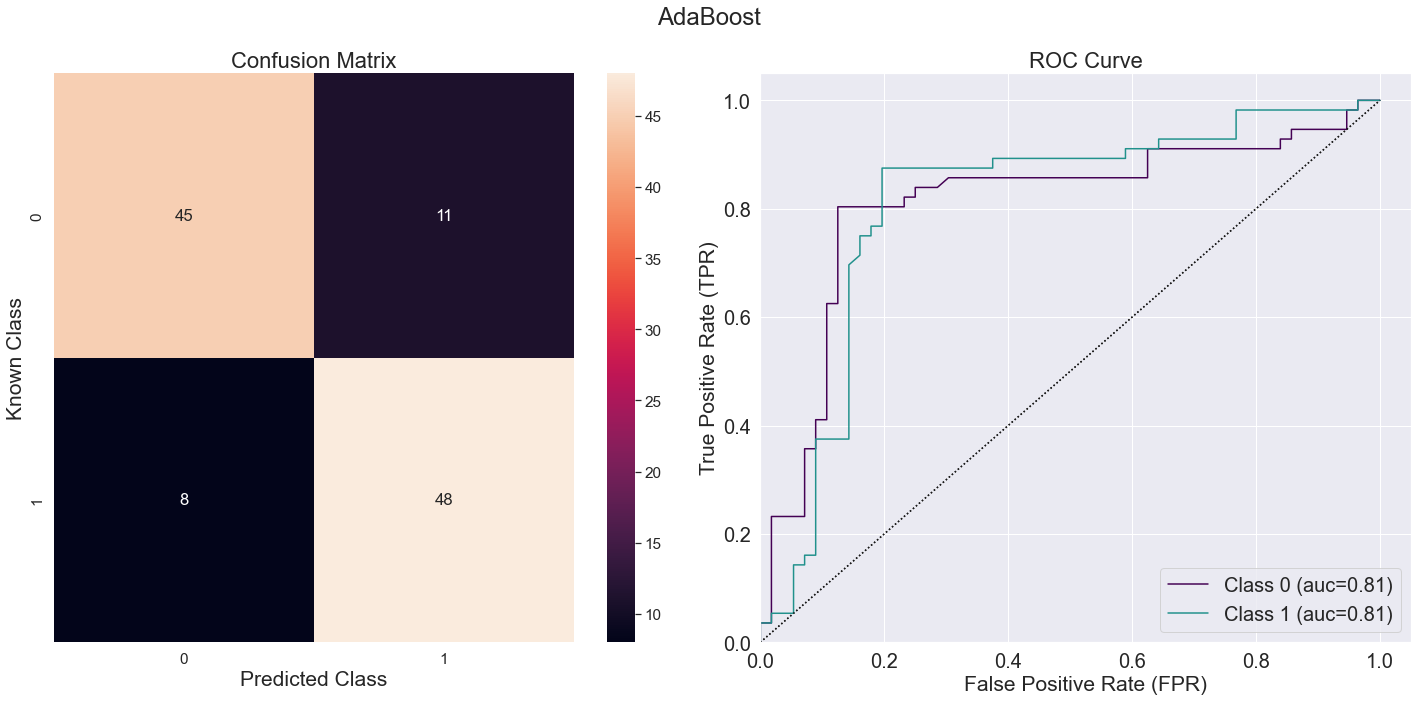

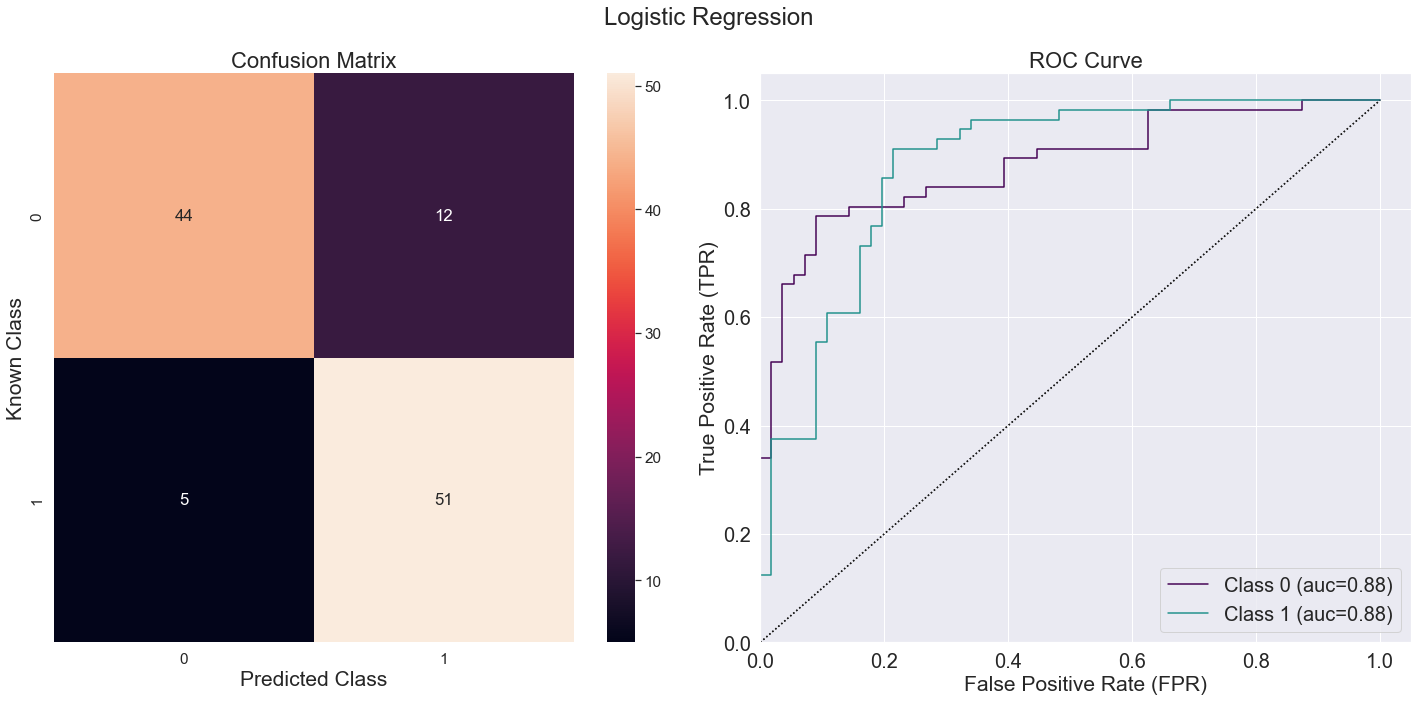

In [199]:
files_plt = []

kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "Extra Trees Classifier", "AdaBoost",
         "Logistic Regression"]

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = cwf.build_data_from_directory(dirname, max_folds=10)
    
#     log.debug("Last value in the data frame: {}".format(data[165:166]))
    
    probs = data[["prob0", "prob1"]].to_numpy()
    log.debug("Probablities for a few examples {}".format(probs[0:3,0:2]))
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.debug("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "ddg_{}_morderd.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="viridis", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))
    #log.info("{}".format("\n".join(["{}: {}".format(k, v) for k, v in metrics.items()])))
    
    metrics_for_paper = {
    "accuracy": metrics["accuracy"],
    "sensitivity": metrics["tpr"],
    "specificity": metrics["tnr"],
    "mcc": metrics["matthews_correlation_coefficient"],
    "precision": metrics["precision"],
    "g-mean": metrics["g-mean"]
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_mordred.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for ddg with models built from mordred features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:mordred_features")
log.info(df_metrics_for_paper.to_latex())

In [200]:
images = [Image.open(x) for x in files_plt]
log.info("Combining {} images".format(len(images)))
widths, heights = zip(*(i.size for i in images))
log.info("{}".format("\n".join("W: {} H: {}".format(wid, hgt) for wid, hgt in zip(widths, heights))))
total_height = sum(heights)
total_width = max(widths)

log.info("New image will be W:{} H:{}".format(total_width, total_height))

combined_image = Image.new("RGBA", (total_width, total_height))
y_offset = 0
for ith, img in enumerate(images):
    log.info("Image {} added at offset height {}".format(ith, y_offset))
    combined_image.paste(img, (0, y_offset))
    y_offset = y_offset + img.size[1]

combined_image.save("combined_mordred.png")

Combining 6 images
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
New image will be W:1440 H:4320
Image 0 added at offset height 0
Image 1 added at offset height 720
Image 2 added at offset height 1440
Image 3 added at offset height 2160
Image 4 added at offset height 2880
Image 5 added at offset height 3600


# Now first we split 90%-10% (train-test)

In [2]:
data = pd.read_csv("Second_set_full.csv")
data.columns = ["_".join(ent.lower().strip().split(" ")) for ent in data.columns]

In [3]:
data

reaction                                substrate  \
0          0           O=C1CCC(Cl)N1CCC2=CC=C(OC)C=C2   
1          1       O=C1CCC(Cl)N1CCC2=CC(OC)=C(OC)C=C2   
2          2                 O=C1CCC(Cl)N1CCC2=CSC=C2   
3          3         O=C1CCC(Cl)N1CCC2=CSC3=C2C=CC=C3   
4          4                 O=C1CCC(Cl)N1CCC2=CNC=C2   
..       ...                                      ...   
85        85  O=C1CCC(C)(Cl)N1CCC2=CNC3=CC=C(OC)C=C32   
86        86        O=C1CCCC(Cl)N1CCC2=CNC3=CC=CC=C32   
87        87     O=C1CCCC(C)(Cl)N1CCC2=CNC3=CC=CC=C32   
88        88  O=C1CCCC(CCCC)(Cl)N1CCC2=CNC3=CC=CC=C32   
89        89     O=C1C=CC(C)(Cl)N1CCC2=CNC3=CC=CC=C32   

                                             catalyst solvent  solvent_code  \
0   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
1   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
2   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
3   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
4   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
..                                                ...     ...           ...   
85  CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
86  CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
87  CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
88  CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
89  CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   

    temperature    ee       ddg         paper  
0           4.0   0.0  0.000000  ORGLETT 2008  
1           4.0   0.0  0.000000  ORGLETT 2008  
2           4.0  30.0  1.426491  ORGLETT 2008  
3           4.0  15.0  0.696565  ORGLETT 2008  
4           4.0  60.0  3.194526  ORGLETT 2008  
..          ...   ...       ...           ...  
85        -78.0  91.0  4.957045     JACS 2007  
86        -55.0  81.0  4.088429     JACS 2007  
87        -78.0  92.0  5.156630     JACS 2007  
88        -78.0  96.0  6.314769     JACS 2007  
89        -78.0  88.0  4.464572     JACS 2007  

[90 rows x 9 columns]

We know which data points we are using for test set, for consistency reasons. 
These are: 

In [4]:
test_reactions = [49, 33, 19, 1, 6, 51, 66,47, 58] 

In [5]:
reaction = data["reaction"]
log.info("Reaction Number: {}".format(reaction.head()))

Reaction Number: 0    0
1    1
2    2
3    3
4    4
Name: reaction, dtype: int64


we romove from the data the test reactions

In [6]:
train_data = data.drop(labels =test_reactions, axis=0,inplace = False)

In [7]:
train_data

reaction                                substrate  \
0          0           O=C1CCC(Cl)N1CCC2=CC=C(OC)C=C2   
2          2                 O=C1CCC(Cl)N1CCC2=CSC=C2   
3          3         O=C1CCC(Cl)N1CCC2=CSC3=C2C=CC=C3   
4          4                 O=C1CCC(Cl)N1CCC2=CNC=C2   
5          5              O=C1CCC(C)(Cl)N1CCC2=CNC=C2   
..       ...                                      ...   
85        85  O=C1CCC(C)(Cl)N1CCC2=CNC3=CC=C(OC)C=C32   
86        86        O=C1CCCC(Cl)N1CCC2=CNC3=CC=CC=C32   
87        87     O=C1CCCC(C)(Cl)N1CCC2=CNC3=CC=CC=C32   
88        88  O=C1CCCC(CCCC)(Cl)N1CCC2=CNC3=CC=CC=C32   
89        89     O=C1C=CC(C)(Cl)N1CCC2=CNC3=CC=CC=C32   

                                             catalyst solvent  solvent_code  \
0   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
2   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
3   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
4   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
5   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
..                                                ...     ...           ...   
85  CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
86  CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
87  CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
88  CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
89  CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   

    temperature    ee       ddg         paper  
0           4.0   0.0  0.000000  ORGLETT 2008  
2           4.0  30.0  1.426491  ORGLETT 2008  
3           4.0  15.0  0.696565  ORGLETT 2008  
4           4.0  60.0  3.194526  ORGLETT 2008  
5         -78.0  90.0  4.777572  ORGLETT 2008  
..          ...   ...       ...           ...  
85        -78.0  91.0  4.957045     JACS 2007  
86        -55.0  81.0  4.088429     JACS 2007  
87        -78.0  92.0  5.156630     JACS 2007  
88        -78.0  96.0  6.314769     JACS 2007  
89        -78.0  88.0  4.464572     JACS 2007  

[81 rows x 9 columns]

and we generate the test dataframe

In [8]:
test_data = pd.DataFrame()
test_data = data.iloc[test_reactions]

In [9]:
test_data

reaction                                          substrate  \
49        49                   O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32   
33        33                   O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32   
19        19  O=C1CCCC(CCCC)(Cl)N1CCC2=CN([Si](C(C)C)(C(C)C)...   
1          1                 O=C1CCC(Cl)N1CCC2=CC(OC)=C(OC)C=C2   
6          6                     O=C1CCC(CCCC)(Cl)N1CCC2=CNC=C2   
51        51                   O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32   
66        66                   O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32   
47        47                   O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32   
58        58                   O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32   

                                             catalyst solvent  solvent_code  \
49  S=C(N[C@H]1[C@H](N2C(C)=CC=C2C3=CC=CC=C3)CCCC1...    MTBE             4   
33  S=C(N[C@H]1[C@H](NS(C(C)(C)C)=O)CCCC1)NC2=CC(C...    MTBE             4   
19  CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
1   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
6   CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...    MTBE             4   
51  S=C(N[C@H]1[C@H](N2C(C)=CC=C2C3=CC=CC=C3)CCCC1...    MTBE             4   
66  S=C(N[C@H]1[C@H](N2C(C)=CC=C2C3=C(C=CC=C4)C4=C...    MTBE             4   
47  S=C(N[C@H]1[C@H](N2C(C)=CC=C2C3=CC=CC=C3)CCCC1...    MTBE             4   
58  S=C(N[C@H]1[C@H](N2C=CC(C(OC(C)(C)C)=O)=C2C(C)...    MTBE             4   

    temperature    ee       ddg         paper  
49          4.0  80.0  5.063205     JACS 2007  
33          4.0   4.0  0.184448     JACS 2007  
19        -55.0  97.0  7.590046  ORGLETT 2008  
1           4.0   0.0  0.000000  ORGLETT 2008  
6         -78.0  91.0  4.957045  ORGLETT 2008  
51          4.0  74.0  4.380500     JACS 2007  
66          4.0  66.0  3.653862     JACS 2007  
47          4.0  84.0  5.628056     JACS 2007  
58          4.0  64.0  3.494216     JACS 2007

In [10]:
substratesmiles_train = train_data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles_train.head()))

catalystsmiles_train = train_data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles_train.head()))

ddg_train = train_data["ddg"]
log.info("DGG: {}".format(ddg_train.head()))

Substrate SMILES: 0      O=C1CCC(Cl)N1CCC2=CC=C(OC)C=C2
2            O=C1CCC(Cl)N1CCC2=CSC=C2
3    O=C1CCC(Cl)N1CCC2=CSC3=C2C=CC=C3
4            O=C1CCC(Cl)N1CCC2=CNC=C2
5         O=C1CCC(C)(Cl)N1CCC2=CNC=C2
Name: substrate, dtype: object
Catalyst SMILES: 0    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
2    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
3    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
4    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
5    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
Name: catalyst, dtype: object
DGG: 0    0.000000
2    1.426491
3    0.696565
4    3.194526
5    4.777572
Name: ddg, dtype: float64


In [11]:
target_train = ddg_train

In [12]:
substratesmiles_test = test_data["substrate"]
log.info("Substrate SMILES: {}".format(substratesmiles_test.head()))

catalystsmiles_test = test_data["catalyst"]
log.info("Catalyst SMILES: {}".format(catalystsmiles_test.head()))

ddg_test = test_data["ddg"]
log.info("DGG: {}".format(ddg_test.head()))

Substrate SMILES: 49                     O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32
33                     O=C1CCC(Cl)N1CCC2=CNC3=CC=CC=C32
19    O=C1CCCC(CCCC)(Cl)N1CCC2=CN([Si](C(C)C)(C(C)C)...
1                    O=C1CCC(Cl)N1CCC2=CC(OC)=C(OC)C=C2
6                        O=C1CCC(CCCC)(Cl)N1CCC2=CNC=C2
Name: substrate, dtype: object
Catalyst SMILES: 49    S=C(N[C@H]1[C@H](N2C(C)=CC=C2C3=CC=CC=C3)CCCC1...
33    S=C(N[C@H]1[C@H](NS(C(C)(C)C)=O)CCCC1)NC2=CC(C...
19    CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
1     CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
6     CN(CCCCC)C([C@H](C(C)(C)C)NC(N[C@H]1[C@H](n2c(...
Name: catalyst, dtype: object
DGG: 49    5.063205
33    0.184448
19    7.590046
1     0.000000
6     4.957045
Name: ddg, dtype: float64


In [13]:
target_test = ddg_test

Generating Fingerprints for the training set

First for the substrates

In [14]:
features1_train,features_df1_train = fp.morgan_fingerprints(substratesmiles_train)

In [15]:
feats1 = features_df1_train.loc[:, (features_df1_train != 0).any(axis=0)]

In [16]:
feats1

0     2     4     5     6     8     44    59    61    76    ...  870   \
0      1     1     1     0     0     1     1     1     1     0  ...     0   
1      1     1     1     0     1     1     0     0     1     0  ...     0   
2      1     1     1     0     1     1     0     0     1     0  ...     0   
3      1     1     1     1     0     1     0     1     1     0  ...     0   
4      1     1     1     1     0     1     0     1     1     0  ...     0   
..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
76     1     1     1     1     0     1     1     1     1     0  ...     0   
77     1     1     1     1     0     1     0     1     1     0  ...     0   
78     1     1     1     1     0     1     0     1     1     0  ...     0   
79     1     1     1     1     0     1     0     1     1     0  ...     0   
80     1     1     1     1     0     1     0     1     1     0  ...     0   

    890   893   895   941   952   966   977   985   1016  
0      0     0     0     1     1     1     1     0     1  
1      0     0     1     0     1     0     0     0     1  
2      0     1     1     0     1     0     0     0     1  
3      0     0     0     0     1     0     0     0     1  
4      0     0     0     0     1     0     0     0     1  
..   ...   ...   ...   ...   ...   ...   ...   ...   ...  
76     1     1     0     1     1     1     1     1     1  
77     1     1     0     0     1     0     0     1     1  
78     1     1     0     0     1     0     0     1     1  
79     1     1     0     0     1     0     0     1     1  
80     1     1     0     0     0     0     0     1     1  

[81 rows x 86 columns]

FPfor catalysts

In [17]:
features2_train,features_df2_train = fp.morgan_fingerprints(catalystsmiles_train)

In [18]:
feats2 = features_df2_train.loc[:, (features_df2_train != 0).any(axis=0)]

In [19]:
features_df_train = feats1.join(feats2, lsuffix="features1", rsuffix="features2")

In [20]:
features_df_train

0features1  2features1  4features1  5  6features1  8features1  \
0            1           1           1  0           0           1   
1            1           1           1  0           1           1   
2            1           1           1  0           1           1   
3            1           1           1  1           0           1   
4            1           1           1  1           0           1   
..         ...         ...         ... ..         ...         ...   
76           1           1           1  1           0           1   
77           1           1           1  1           0           1   
78           1           1           1  1           0           1   
79           1           1           1  1           0           1   
80           1           1           1  1           0           1   

    44features1  59features1  61features1  76  ...  951  955  966features2  \
0             1            1            1   0  ...    0    0             1   
1             0            0            1   0  ...    0    0             1   
2             0            0            1   0  ...    0    0             1   
3             0            1            1   0  ...    0    0             1   
4             0            1            1   0  ...    0    0             1   
..          ...          ...          ...  ..  ...  ...  ...           ...   
76            1            1            1   0  ...    0    0             1   
77            0            1            1   0  ...    0    0             1   
78            0            1            1   0  ...    0    0             1   
79            0            1            1   0  ...    0    0             1   
80            0            1            1   0  ...    0    0             1   

    977features2  984  1003  1006  1007  1008  1016features2  
0              0    0     1     0     0     0              1  
1              0    0     1     0     0     0              1  
2              0    0     1     0     0     0              1  
3              0    0     1     0     0     0              1  
4              0    0     1     0     0     0              1  
..           ...  ...   ...   ...   ...   ...            ...  
76             0    0     1     0     0     0              1  
77             0    0     1     0     0     0              1  
78             0    0     1     0     0     0              1  
79             0    0     1     0     0     0              1  
80             0    0     1     0     0     0              1  

[81 rows x 234 columns]

# Classify the training set

In [21]:
classes_train=[]
for index, value in ddg_train.items():
    if value < 4:
        classes_train.append(0)
    else:
        classes_train.append(1)

In [22]:
classes_train
class_targets_df_train = pd.DataFrame(np.array([classes_train]).T, columns=["classes"])
features_and_classes_df_train = features_df_train.copy()
features_and_classes_df_train["classes"] = classes_train

In [23]:
class_targets_df_train["classes"].values

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [24]:
features_df_train.to_csv("features_train.csv")

# Synthetic Sampling for the training

In [35]:
feature_types = "catagorical"

In [36]:
nneighbours = min(5, len(class_targets_df_train[class_targets_df_train["classes"]==1].index)-1)
log.info("Number of neighbours used for SMOTE: {}".format(nneighbours))

# feature_types is set when the fingerprints are calculated
# No catagorical
if feature_types == "no_catagorical":
    sm = SMOTE(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# Some catagorical - Need to provide the indexes
elif feature_types == "some_catagorical":
    sm = SMOTENC(sampling_strategy="not majority", categorical_features=catagorical_indxs, random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)
# All catagorical
elif feature_types == "catagorical":
    sm = SMOTEN(sampling_strategy="not majority", random_state=random_seed, k_neighbors=nneighbours, n_jobs=-1)

Number of neighbours used for SMOTE: 5


In [37]:
log.info("Feature decriptions:\n{}".format(features_df_train.columns.values))
log.info("Classes/Targets descriptions:\n{}".format(class_targets_df_train.columns.values))

Feature decriptions:
['0features1' '2features1' '4features1' 5 '6features1' '8features1'
 '44features1' '59features1' '61features1' 76 '80features1' 89
 '94features1' 108 121 '127features1' '131features1' 148 '156features1'
 171 177 '187features1' '193features1' 196 '217features1' 223
 '227features1' '241features1' 244 246 '274features1' 326 '349features1'
 '362features1' '428features1' '430features1' 431 '434features1' 438
 '442features1' '446features1' '475features1' 476 '489features1' 491
 '495features1' 497 '499features1' '501features1' '508features1' 530 542
 '543features1' 559 561 '583features1' 586 594 601 627 '644features1'
 '699features1' 707 '713features1' '733features1' 748 751 760
 '793features1' 796 825 827 839 '848features1' 854 869 '870features1' 890
 '893features1' '895features1' '941features1' 952 '966features1'
 '977features1' 985 '1016features1' '0features2' 1 '2features2' 3
 '4features2' '6features2' '8features2' 12 16 17 20 27 35 39 '44features2'
 52 '59features2' 

In [38]:
features_smote_train, classes_smote_train = sm.fit_resample(features_df_train.to_numpy(), class_targets_df_train.to_numpy())
n_sythetic_points = features_smote_train.shape[0] - len(features_df_train.index)
log.info("SMOTE has added {} sythetic features to balence the classes".format(n_sythetic_points))

SMOTE has added 21 sythetic features to balence the classes


In [39]:
log.info("Resampled X\n{}\n{}\nResampled y:\n{}\n{}".format(features_smote_train, features_smote_train.shape, classes_smote_train, classes_smote_train.shape))

Resampled X
[[1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 1]
 ...
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 1]]
(102, 234)
Resampled y:
[0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(102,)


In [40]:
features_smote_df_train = pd.DataFrame(data=features_smote_train, columns=features_df_train.columns.values)
classes_smote_df_train = pd.DataFrame(data=classes_smote_train, columns=["classes"])

comb_df_res = features_smote_df_train.copy()
comb_df_res["classes"] = classes_smote_train
comb_df_res.to_csv("resampled_synthetic_data_set_train.csv")
comb_df_res

0features1  2features1  4features1  5  6features1  8features1  \
0             1           1           1  0           0           1   
1             1           1           1  0           1           1   
2             1           1           1  0           1           1   
3             1           1           1  1           0           1   
4             1           1           1  1           0           1   
..          ...         ...         ... ..         ...         ...   
97            1           1           1  1           0           1   
98            1           1           1  1           0           1   
99            1           1           1  1           0           1   
100           1           1           1  1           0           1   
101           1           1           1  1           0           1   

     44features1  59features1  61features1  76  ...  955  966features2  \
0              1            1            1   0  ...    0             1   
1              0            0            1   0  ...    0             1   
2              0            0            1   0  ...    0             1   
3              0            1            1   0  ...    0             1   
4              0            1            1   0  ...    0             1   
..           ...          ...          ...  ..  ...  ...           ...   
97             0            1            1   0  ...    0             1   
98             0            1            1   0  ...    0             0   
99             0            1            1   0  ...    0             1   
100            0            1            1   0  ...    0             1   
101            0            1            1   0  ...    0             0   

     977features2  984  1003  1006  1007  1008  1016features2  classes  
0               0    0     1     0     0     0              1        0  
1               0    0     1     0     0     0              1        0  
2               0    0     1     0     0     0              1        0  
3               0    0     1     0     0     0              1        0  
4               0    0     1     0     0     0              1        1  
..            ...  ...   ...   ...   ...   ...            ...      ...  
97              0    0     1     0     0     0              1        0  
98              0    0     1     0     0     0              1        0  
99              0    0     1     0     0     0              1        0  
100             0    0     1     0     0     0              1        0  
101             0    0     1     0     0     0              1        0  

[102 rows x 235 columns]

# Handling the Test Set

First we generate Fingerprints for the substrates and catalysts of the test set and then we use 
the descriptors that the training set is using

In [41]:
features1_test,features_df1_test = fp.morgan_fingerprints(substratesmiles_test)

In [42]:
a = features_df1_test.columns.intersection(feats1.columns)

In [43]:
feat1_test = features_df1_test.drop(columns=[col for col in features_df1_test if col not in a])

In [44]:
feat1_test

0     2     4     5     6     8     44    59    61    76    ...  870   \
0     1     1     1     1     0     1     0     1     1     0  ...     0   
1     1     1     1     1     0     1     0     1     1     0  ...     0   
2     1     1     1     0     1     1     1     0     1     0  ...     0   
3     1     1     1     0     0     1     1     1     1     0  ...     0   
4     1     1     1     1     0     1     0     1     1     0  ...     0   
5     1     1     1     1     0     1     0     1     1     0  ...     0   
6     1     1     1     1     0     1     0     1     1     0  ...     0   
7     1     1     1     1     0     1     0     1     1     0  ...     0   
8     1     1     1     1     0     1     0     1     1     0  ...     0   

   890   893   895   941   952   966   977   985   1016  
0     1     1     0     0     1     0     0     1     1  
1     1     1     0     0     1     0     0     1     1  
2     0     0     0     1     1     1     0     0     1  
3     0     0     0     1     1     1     0     0     1  
4     0     0     0     0     1     0     0     0     1  
5     1     1     0     0     1     0     0     1     1  
6     1     1     0     0     1     0     0     1     1  
7     1     1     0     0     1     0     0     1     1  
8     1     1     0     0     1     0     0     1     1  

[9 rows x 86 columns]

In [45]:
features2_test,features_df2_test = fp.morgan_fingerprints(catalystsmiles_test)

In [46]:
b = features_df2_test.columns.intersection(feats2.columns)

In [47]:
feat2_test = features_df2_test.drop(columns=[col for col in features_df2_test if col not in b])

In [48]:
features_df_test = feat1_test.join(feat2_test, lsuffix="features1", rsuffix="features2")

In [49]:
features_df_test 

0features1  2features1  4features1  5  6features1  8features1  44features1  \
0           1           1           1  1           0           1            0   
1           1           1           1  1           0           1            0   
2           1           1           1  0           1           1            1   
3           1           1           1  0           0           1            1   
4           1           1           1  1           0           1            0   
5           1           1           1  1           0           1            0   
6           1           1           1  1           0           1            0   
7           1           1           1  1           0           1            0   
8           1           1           1  1           0           1            0   

   59features1  61features1  76  ...  951  955  966features2  977features2  \
0            1            1   0  ...    0    0             1             0   
1            1            1   0  ...    1    0             0             0   
2            0            1   0  ...    0    0             1             0   
3            1            1   0  ...    0    0             1             0   
4            1            1   0  ...    0    0             1             0   
5            1            1   0  ...    0    0             1             0   
6            1            1   0  ...    0    0             1             0   
7            1            1   0  ...    0    0             1             0   
8            1            1   0  ...    0    0             1             0   

   984  1003  1006  1007  1008  1016features2  
0    0     1     0     0     0              1  
1    0     0     0     1     0              1  
2    0     1     0     0     0              1  
3    0     1     0     0     0              1  
4    0     1     0     0     0              1  
5    0     1     0     0     0              1  
6    0     1     1     0     0              1  
7    0     1     0     0     0              1  
8    0     1     0     0     0              1  

[9 rows x 234 columns]

In [50]:
classes_test=[]
for index, value in ddg_test.items():
    if value < 4:
        classes_test.append(0)
    else:
        classes_test.append(1)

# Define Xtrain, Xtest, Ytrain, Ytest

In [51]:
Xtrain = features_smote_df_train.astype(float)
Xtest = features_df_test.astype(float)
Ytrain = classes_smote_df_train
Ytest = classes_test

# Time for ML

In [52]:
kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "ExtraTreesClassifier", "AdaBoost",
         "Logistic Regression"]


kfold_classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=random_seed, n_jobs=-1),
    DecisionTreeClassifier(random_state=random_seed),
    ExtraTreesClassifier(random_state=random_seed, n_jobs=-1),
    AdaBoostClassifier(random_state=random_seed),
    LogisticRegression(random_state=random_seed, n_jobs=-1, solver="lbfgs")]

kfold_classifier_parameters = {
    "Nearest Neighbors": {"n_neighbors": [ent for ent in range(2, 10, 1)]},
    "Gaussian Process": {"kernel":[1.0 * Matern(length_scale=1.0, nu=1.5), 1.0 * Matern(length_scale=1.0, nu=2.5), 1.0 * RBF(1.0),  1.0 * RBF(1.0) + WhiteKernel(noise_level=0.5)]},
    "Decision Tree": {"max_depth": [2, 3, 4, 5, 7, 10]},
    "ExtraTreesClassifier": {"max_depth": [2, 3, 4, 5, 7, 10], "n_estimators": [10, 20, 50, 100]},
    "AdaBoost": {"n_estimators": [10, 20, 50, 100]},
    "Logistic Regression": {"penalty":["l2"], "C": [0.05, 0.1, 0.25, 0.5, 1.0, 1.25]}
}

In [53]:
def minmaxscale(df):
    """
    scale a pandas dataframe using min max scaling
    :param df: pandas dataframe - data frame to be returned scaled
    """
    
    df_tmp = df.copy()
    normalized_df = (df_tmp-df_tmp.min())/(df_tmp.max()-df_tmp.min())
    return normalized_df

In [54]:
def grid_search_classifier_parameters(clf, Xtrain, ytrain, clf_options, clf_names, iteration, no_train_output, cv=5, name=None, scoring=("roc_auc", "precision", "recall")):
    """
    Grid search calssifer hyperparams and find the best report metrics if requested
    """
    log = logging.getLogger(__name__)
    
    # Grid search model optimizer
    parameters = clf_options[clf_names[iteration]]
    log.debug("\tname: {} parameters: {}".format(name, parameters))
    
    optparam_search = GridSearchCV(clf, parameters, cv=cv, error_score=np.nan, scoring=scoring, refit=scoring[0], return_train_score=True)
    log.debug("\tCV xtrain: {}".format(Xtrain))
    
    optparam_search.fit(Xtrain, ytrain.values.ravel())
    opt_parameters = optparam_search.best_params_
    
    if no_train_output is False:
        reported_metrics = pd.DataFrame(data=optparam_search.cv_results_)
        reported_metrics.to_csv("{}/{}_grid_search_metrics.csv".format(name,name))
        log.info("\tBest parameters; {}".format(opt_parameters))
        for mean, std, params in zip(optparam_search.cv_results_["mean_test_{}".format(scoring[0])], 
                                     optparam_search.cv_results_["std_test_{}".format(scoring[0])], 
                                     optparam_search.cv_results_['params']):
            log.info("\t{:.4f} (+/-{:.4f}) for {}".format(mean, std, params))
    else:
        pass
    
    return opt_parameters

In [55]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from imblearn.metrics import classification_report_imbalanced, sensitivity_specificity_support
def kfold_test_imbalenced_classifiers_with_optimization(df, test_df, classes, testclasses, classifiers, clf_options, scale=False, cv=5, n_repeats=20, clf_names=None, 
                                                        class_labels=(0,1), no_train_output=False, smiles=None, names=None,
                                                        random_seed=107901, overwrite=False):
    """
    function to run classification test over classifiers using imbalenced resampling
    inspired from https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
    :param df: dataframe - data frame of features and identifers (smiles and/or names)
    :param classes: iterable - list of classes/labels
    :param classifiers: list - list of classifier methods
    :param plot: true/false - plot the results or not
    """
    
    log = logging.getLogger(__name__)
    
    log.info("Features: {}".format(df.columns))
    
    log_df = pd.DataFrame()
    labelpredictions = pd.DataFrame()
    
    predicted,list_opt_param=[],[]
    list_report, list_roc_auc, list_opt_param, list_score, list_c_matrix=[],[],[],[],[]
    iteration = 0
    pd.set_option('display.max_columns', 20)
    data = df.copy()
    data.reset_index(inplace=True)
       
    if clf_names is None:
        clf_names = [i for i in range(0, len(classifiers))]
    
    if scale is True:
        data = minmaxscale(data)
        log.info("Scaled data:\n{}".format(data))
    else:
        log.info("Using unscaled features")
        log.info("data:\n{}".format(data))
    
    for name, classf in zip(clf_names, classifiers):
        log.info("\n-----\nBegin {}\n-----\n".format(name))
        
        kf_iteration = 0
        if not n_repeats % 2:
            figure = plt.figure(figsize=(2 * 20.0, 5.0 * int(n_repeats/2.0)))
            plt_rows = int(n_repeats/2.0)
        else:
            figure = plt.figure(figsize=(2 * 20.0, 5.0 * int(n_repeats/2.0)+1))
            plt_rows = nt(n_repeats/2.0)+1
        scores = []
        confusion_matrices = []
        roc_aucs = []
        score_list = []
        tmp = []
        name = "{}".format("_".join(name.split()))
        
        # Make directory for each classifier
        if not os.path.isdir(name):
            os.makedirs(name, exist_ok = True)
        elif overwrite is False and os.path.isdir(name) is True:
            log.warning("Directory already exists and overwrite is False will stop before overwriting.".format(name))
            return None
        else:
            log.info("Directory {} already exists will be overwritten".format(name))
        
            # Train
        Xtrain = df
        log.debug("Train X\n{}".format(Xtrain))
        df.to_csv('Xtrain.csv')
        ytrain = classes
        log.debug("Train Y\n{}".format(ytrain))
            
            # Test
        Xtest = test_df
        log.debug("Test X\n{}".format(Xtest))
        test_df.to_csv('Xtest.csv')
        ytest = testclasses
        log.debug("Test Y\n{}".format(ytest))
        
            # Grid search model optimizer
        opt_param = grid_search_classifier_parameters(classf, Xtrain, ytrain, clf_options, clf_names, iteration, no_train_output, cv=cv, name=name)
                 
        list_opt_param.append(opt_param)
            
            # Fit final model using optimized parameters
        clf = classf
        clf.set_params(**opt_param)
        log.info("\n\t----- Predicting using: {} -----".format(name))
        log.debug("\tXtrain: {}\n\tXtest: {}\n\tytrain: {}\n\tytest: {}".format(Xtrain, Xtest, ytrain, ytest))
        clf.fit(Xtrain, ytrain)
            
            # Evaluate the model
            ## evaluate the model on multiple metric score as list for averaging
        predicted_clf = clf.predict(Xtest)
        sc = precision_recall_fscore_support(ytest, predicted_clf, average=None)
        sc_df = pd.DataFrame(data=np.array(sc).T, columns=["precision", "recall", "f1score", "support"])
        sc_df.to_csv(os.path.join(name, "fold_{}_score.csv".format(kf_iteration)))
        score_list.append(sc)
            
            ## evaluate the principle score metric only (incase different to those above although this is unlikely)
        clf_score = clf.score(Xtest, ytest)
        scores.append(clf_score)
            
            ## Get the confusion matrices 
        c_matrix = confusion_matrix(ytest, predicted_clf, labels=class_labels)
        confusion_matrices.append(c_matrix)
            
            ## Calculate the roc area under the curve
        probs = clf.predict_proba(Xtest)
        fpr, tpr, thresholds = roc_curve(ytest, probs[:,1], pos_label=1)
        roc_auc = auc(fpr, tpr)
            
        list_roc_auc.append(roc_auc)
            
        roc_aucs.append(roc_auc)
        log.info("\tROC analysis area under the curve: {}".format(roc_auc))
            
            # output metrics for consideration
        log.info("\tConfusion matrix ({}):\n{}\n".format(name, c_matrix))
            
        list_c_matrix.append(c_matrix)
        log.info("\n\tscore ({}): {}".format(name, clf_score))   

        list_score.append(clf_score)
        
        log.info("\tImbalence reports:")
        log.info("\tImbalence classification report:\n{}".format(classification_report_imbalanced(ytest, predicted_clf)))
        output_dict = classification_report_imbalanced(ytest, predicted_clf, output_dict=True)
            
            ## Plot the roc curves
        ax = plt.subplot(2, plt_rows, kf_iteration+1)
        ax.plot(fpr, tpr, color="red",
                     lw=1.5, label="ROC curve (auc = {:.2f})".format(roc_auc))
            
                # ugliest legend i ve made in my life - maybe one under the other?
            
        ax.plot(fpr, tpr, alpha=0.0,color="white", lw=1.5,label= "pre_class0 = {:.2f}\n".format(output_dict[0]['pre'])+"pre_class1 = {:.2f}".format(output_dict[1]['pre']))
        ax.plot(fpr, tpr, alpha=0.0,color="white", lw=1.5,label= "f1_class0 = {:.2f}\n".format(output_dict[0]['f1'])+ "f1_class1 = {:.2f}".format(output_dict[1]['f1']))
        ax.plot(fpr, tpr, alpha=0.0,color="white", lw=1.5,label= "rec_class0 = {:.2f}\n".format(output_dict[0]['rec'])+ "rec_class1 = {:.2f}".format(output_dict[1]['rec']))

        ax.plot([0, 1], [0, 1], "k:")
        ax.set_xlim(xmin=0.0, xmax=1.01)
        ax.set_ylim(ymin=0.0, ymax=1.01)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc="lower right")
            
                   
        list_report.append(classification_report_imbalanced(ytest, predicted_clf))
            
        sensitvity, specificity, support = sensitivity_specificity_support(ytest, predicted_clf)
        log.debug("\t{} {} {}".format(sensitvity, specificity, support))
        log.info("\t -----Index | Predicted | Label\n\t------------------")

        log.info("\t{}\n-----\n".format("\n\t".join(["  {}   |   {}   |   {}".format(i, p, k) for i,(p, k) in enumerate(zip(predicted_clf, ytest))])))
    
        pred = [list(range(9)),list(ytest),list(predicted_clf), list(probs[:,0]), list(probs[:,1])]
            
        pred = pd.DataFrame(pred)
        pred.T.to_csv("{}/{}.csv".format(name, kf_iteration))
        kf_iteration = kf_iteration + 1
        
        
#         if any(x not in tmp for x in [y for y in range(len(classes.index))]):
#              log.info("WARNING there appears to be left over indexes which have not been used for testing: {}".format())
#         else:
#             log.info("All points have been used in a test case over all fold as they should have been")
        
        # Plot and assess classifier over all folds
        
        # NOTE - rows are scores columns are classes
        average_scores = np.mean(score_list, axis=0)
        std_scores = np.std(score_list, axis=0)
        average_roc_auc = np.mean(roc_aucs, axis=0)
        std_roc_auc = np.std(roc_aucs, axis=0)
        
        log.info("{} {} {} {}".format(average_scores, std_scores, average_roc_auc, std_roc_auc))

        # precision_recall_fscore_support
        score_str1 = "Class 0: Pre: {:.2f} +/- {:.2f} Rec: {:.2f} +/- {:.2f} Fsc: {:.2f} +/- {:.2f} Sup: {:.2f} +/- {:.2f}".format(average_scores[0][0], 
                                                                                                                                   std_scores[0][0], 
                                                                                                                                   average_scores[1][0], 
                                                                                                                                   std_scores[1][0], 
                                                                                                                                   average_scores[2][0], 
                                                                                                                                   std_scores[2][0], 
                                                                                                                                   average_scores[3][0], 
                                                                                                                                   std_scores[3][0])
        score_str2 = "Class 1: Pre: {:.2f} +/- {:.2f} Rec: {:.2f} +/- {:.2f} Fsc: {:.2f} +/- {:.2f} Sup: {:.2f} +/- {:.2f}".format(average_scores[0][1], 
                                                                                                                                   std_scores[0][1], 
                                                                                                                                   average_scores[1][1], 
                                                                                                                                   std_scores[1][1], 
                                                                                                                                   average_scores[2][1], 
                                                                                                                                   std_scores[2][1], 
                                                                                                                                   average_scores[3][1], 
                                                                                                                                   std_scores[3][1])
        score_str3 ="Average ROC AUCs: {:.2f} +/- {:.2f}".format(average_roc_auc, std_roc_auc)
        score_text = "{}\n{}\n{}".format(score_str1, score_str2, score_str3)
        plt.annotate(score_text, xy=(0.5, 0), xytext=(0, 0), xycoords="figure fraction", textcoords='offset points', size=12, ha='center', va='bottom')
        figure.tight_layout()
        plt.savefig("{0}/{0}_roc_curves.png".format(name))
        plt.show()

        iteration = iteration + 1
    log_df["opt_param"] = pd.Series(list_opt_param)
    log_df["roc_auc"] = pd.Series(list_roc_auc)

    log_df["report"] = pd.Series(list_report)
    log_df["score"] = pd.Series(list_score)

    log_df["c_matrix"] = pd.Series(list_c_matrix)
    
    log_df.to_csv("logs2.csv")
        

In [56]:
# be aware of the bug, you need to comment out each classifier that has run

Features: Index([   '0features1',    '2features1',    '4features1',               5,
          '6features1',    '8features1',   '44features1',   '59features1',
         '61features1',              76,
       ...
                   951,             955,  '966features2',  '977features2',
                   984,            1003,            1006,            1007,
                  1008, '1016features2'],
      dtype='object', length=234)
Using unscaled features
data:
     index  0features1  2features1  4features1    5  6features1  8features1  \
0        0         1.0         1.0         1.0  0.0         0.0         1.0   
1        1         1.0         1.0         1.0  0.0         1.0         1.0   
2        2         1.0         1.0         1.0  0.0         1.0         1.0   
3        3         1.0         1.0         1.0  1.0         0.0         1.0   
4        4         1.0         1.0         1.0  1.0         0.0         1.0   
..     ...         ...         ...         ...  ...       

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
	Best parameters; {'n_neighbors': 2}
	0.7998 (+/-0.1713) for {'n_neighbors': 2}
	0.7835 (+/-0.1956) for {'n_neighbors': 3}
	0.7867 (+/-0.1900) for {'n_neighbors': 4}
	0.7725 (+/-0.2056) f

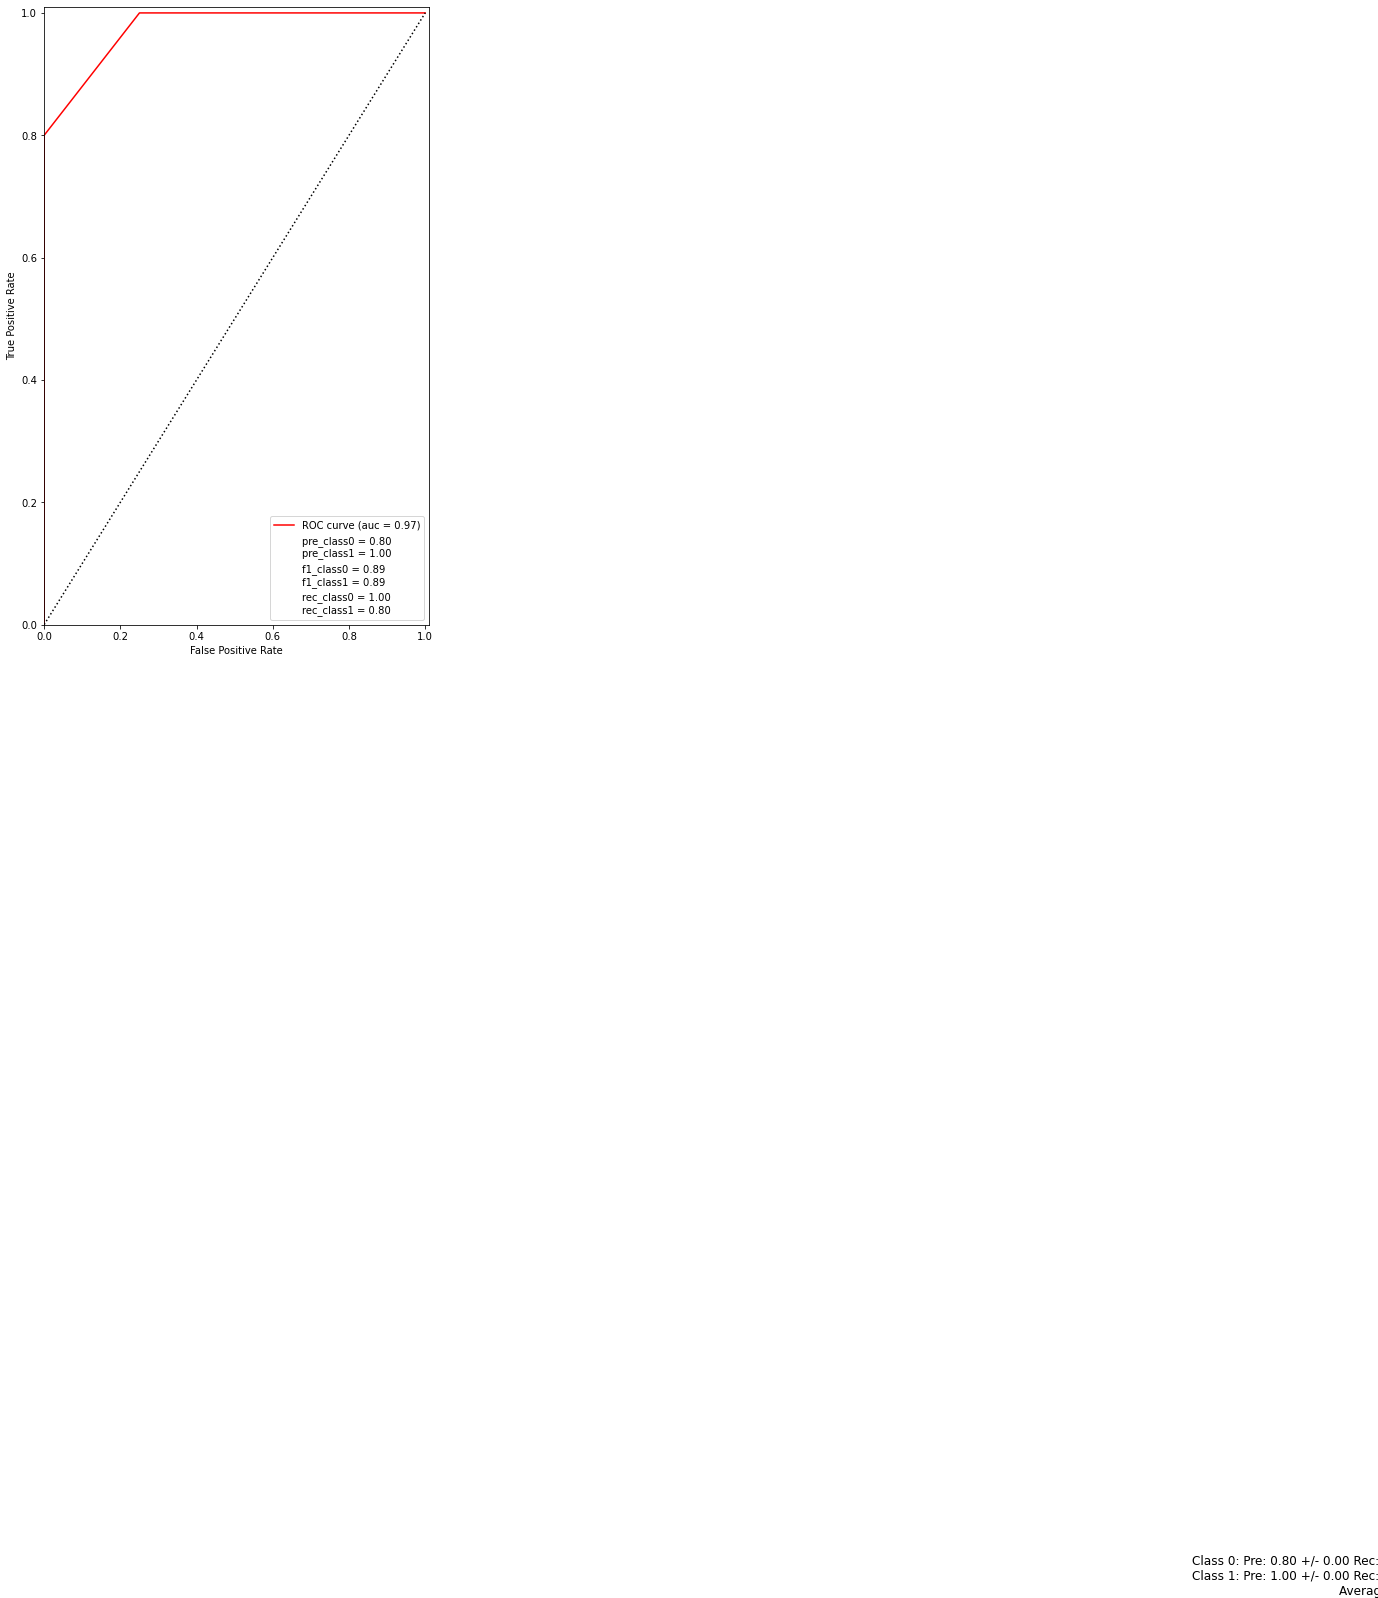


-----
Begin Gaussian Process
-----

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support nam

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Fe

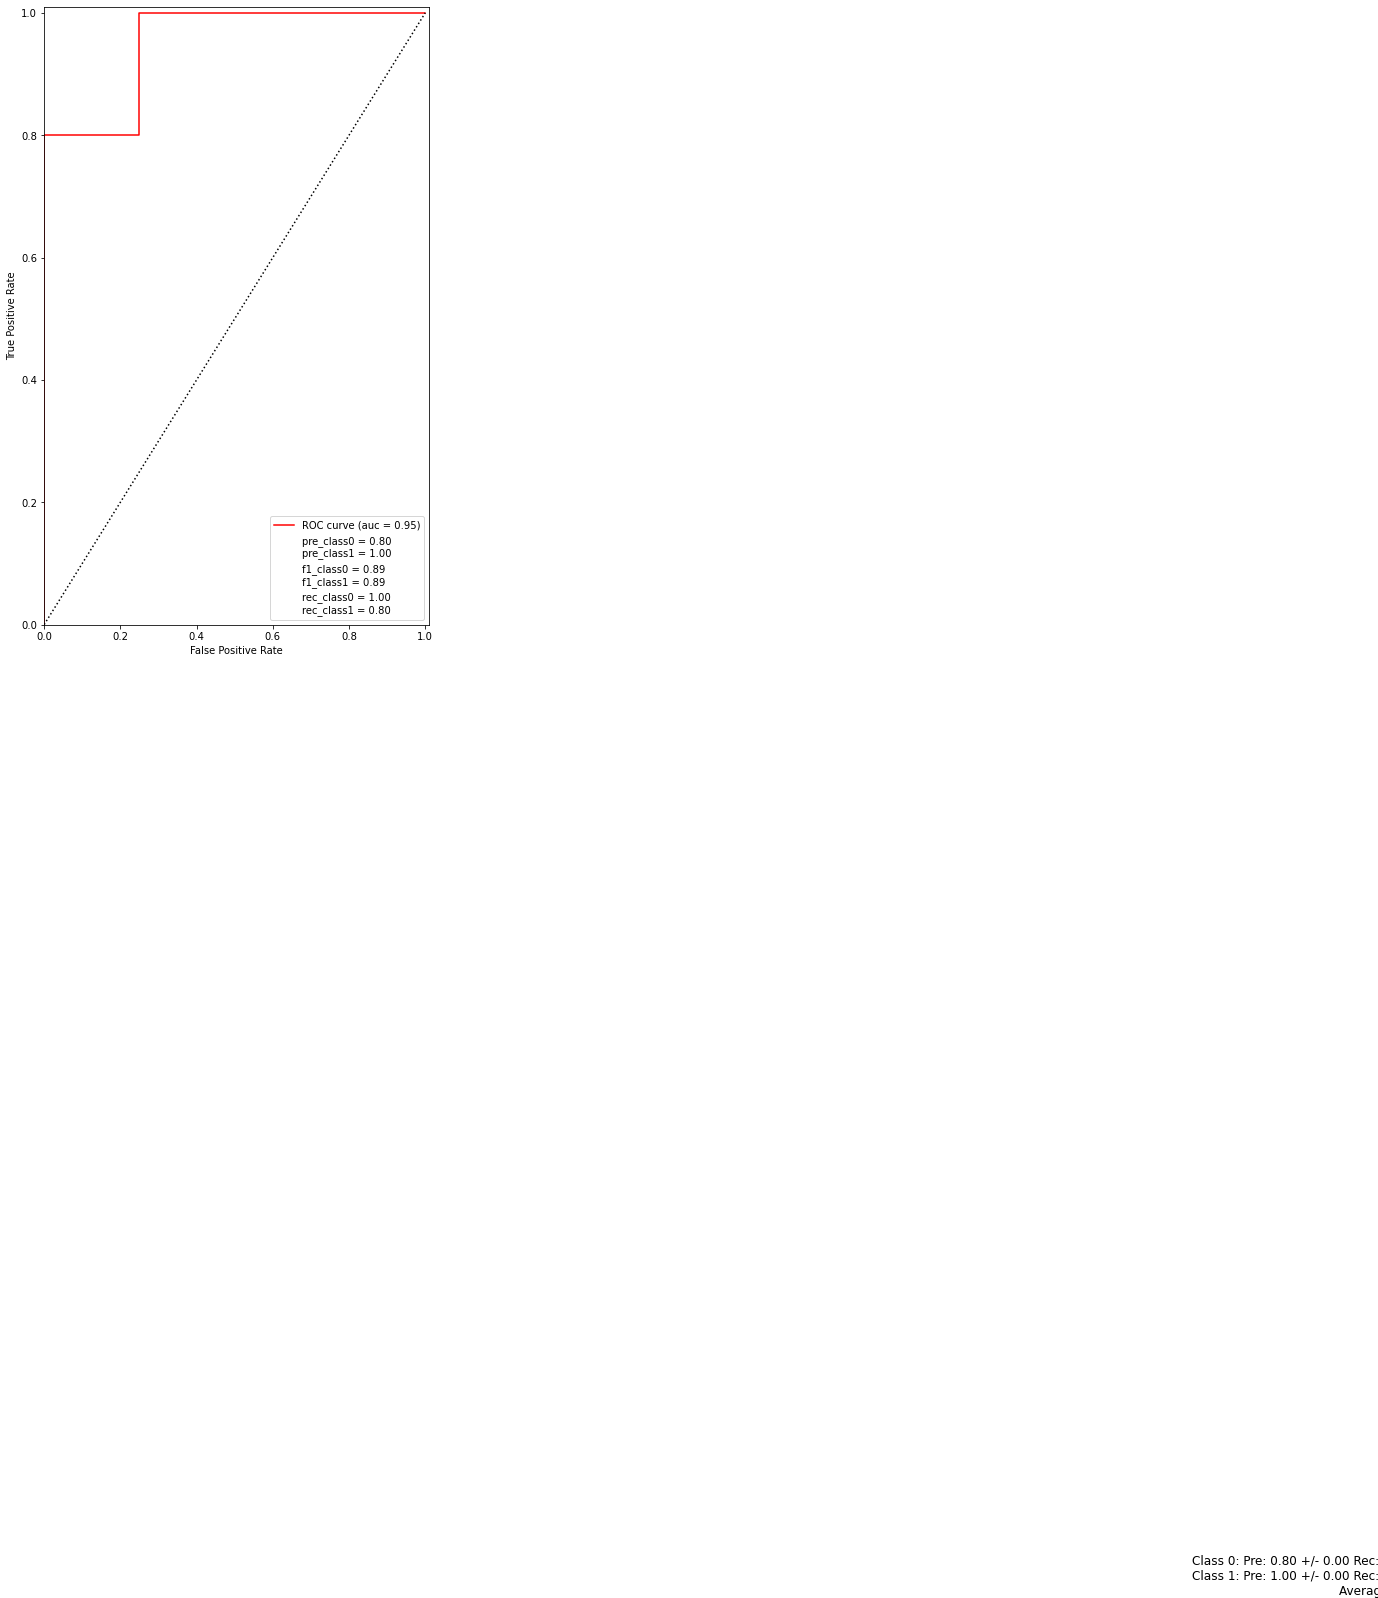


-----
Begin Decision Tree
-----

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
	Best parameters; {'max_depth': 2}
	0.7530 (+/-0.1262) for {'max_depth': 2}
	0.7199 (+/-0.1561) for {'max_depth': 3}
	0.7269 (+/-0.1652) for {'max_depth': 4}
	0.7309 (+/-0.1794) for {'max_depth': 5}
	0.7309 (+/-0.1928) for {'max_depth': 7}
	0.7309 (+/-0.1928) for {'max_depth': 10}

	----- Predicting using: Decision_Tree -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature na

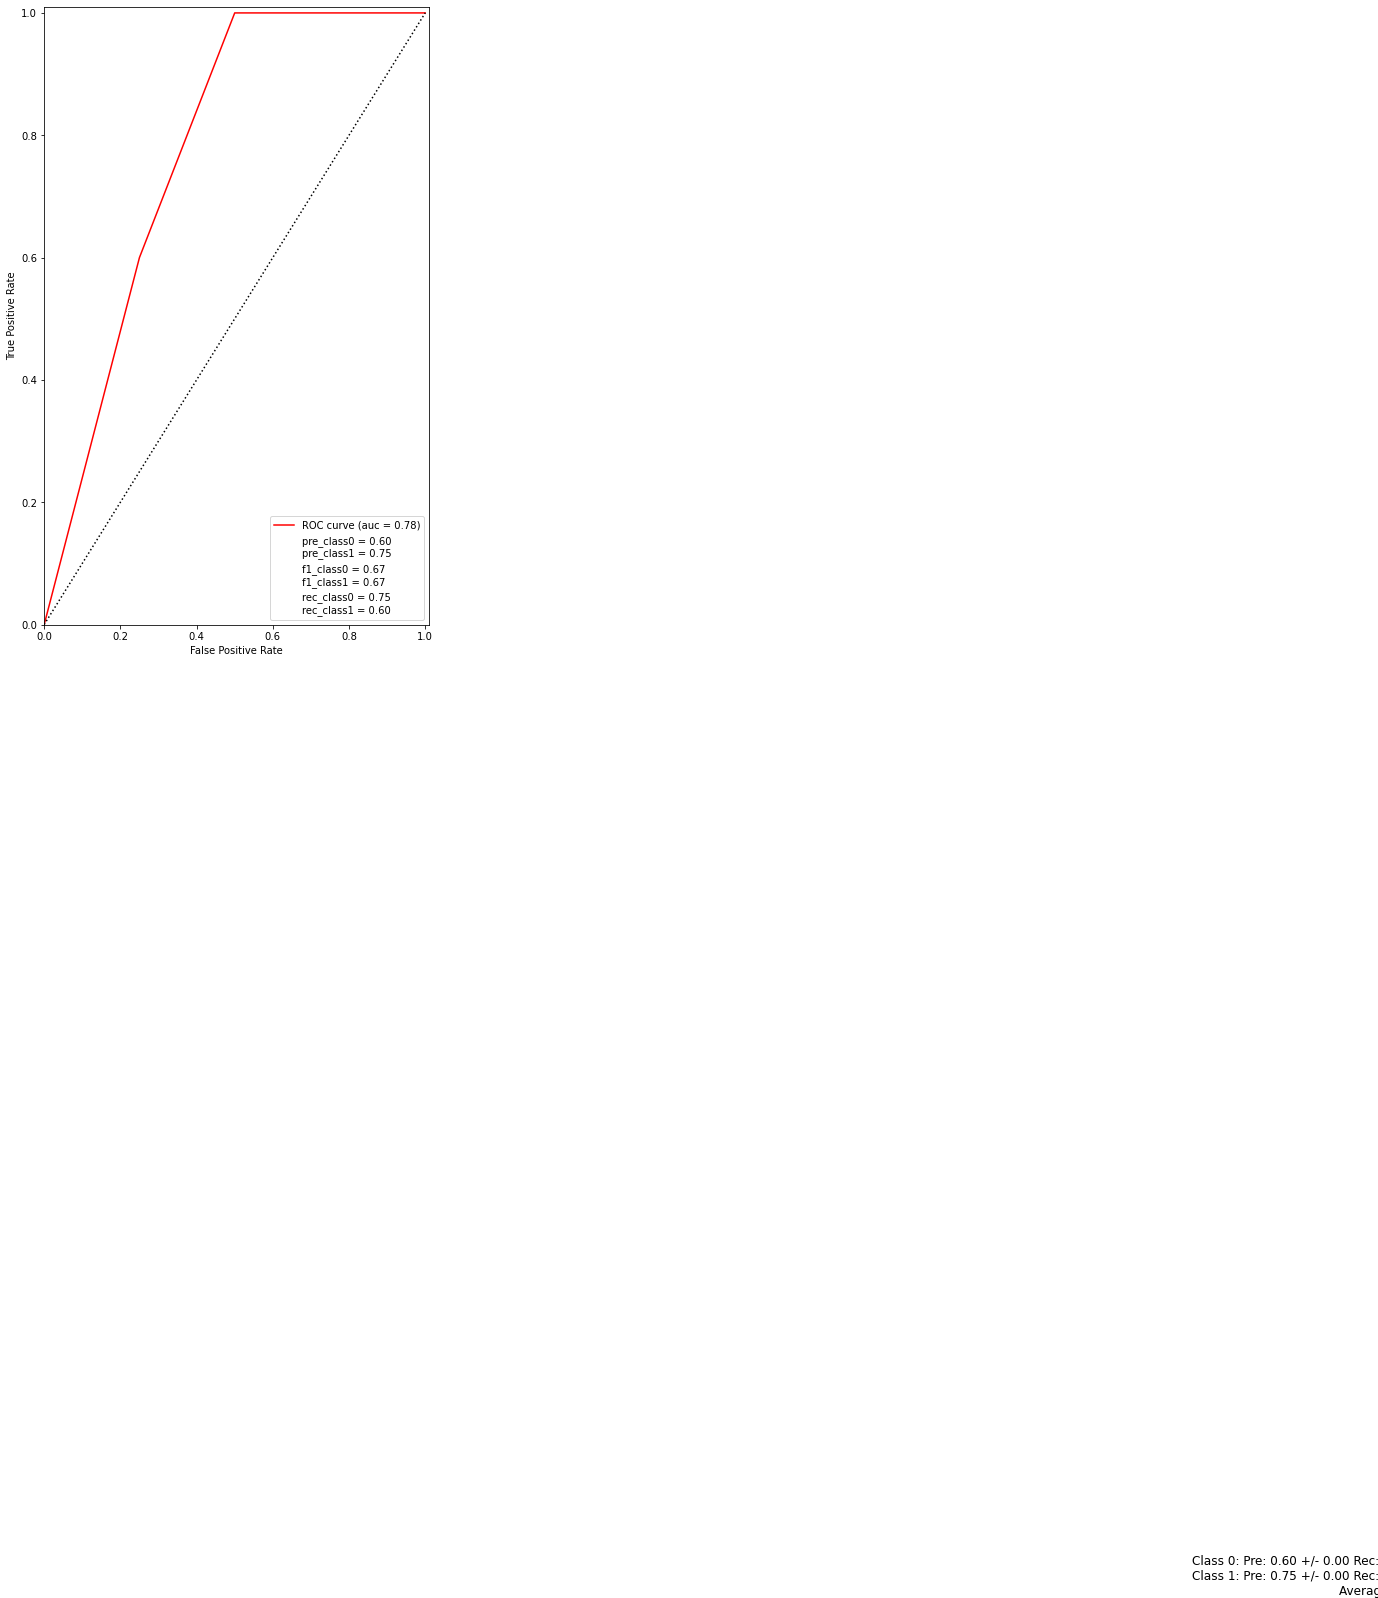


-----
Begin ExtraTreesClassifier
-----

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	0.8349 (+/-0.1390) for {'max_depth': 10, 'n_estimators': 100}

	----- Predicting using: ExtraTreesClassifier -----
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:91: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/valid

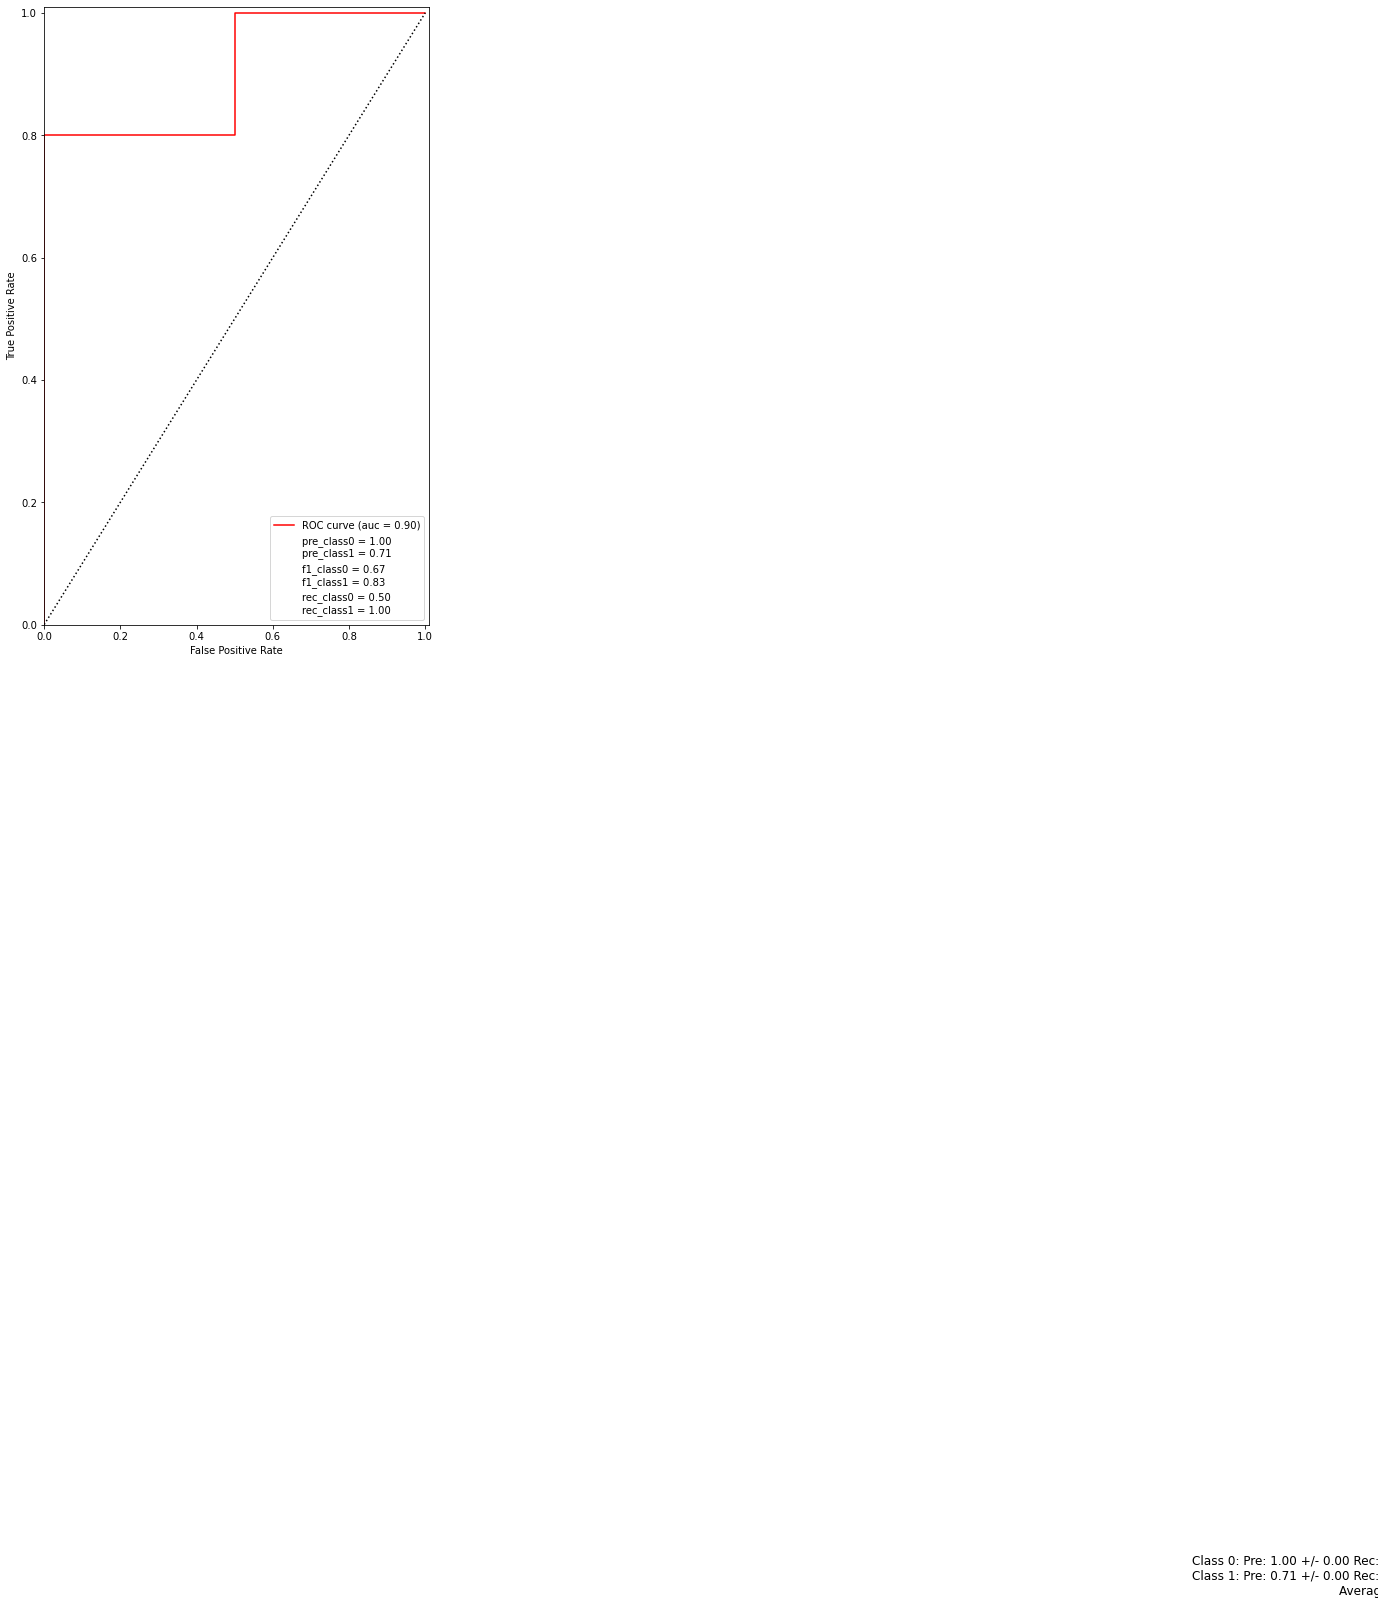


-----
Begin AdaBoost
-----

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

	Confusion matrix (AdaBoost):
[[4 0]
 [1 4]]


	score (AdaBoost): 0.8888888888888888
	Imbalence reports:
	Imbalence classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.80      1.00      0.80      0.89      0.89      0.82         4
          1       1.00      0.80      1.00      0.89      0.89      0.78         5

avg / total       0.91      0.89      0.91      0.89      0.89      0.80         9

	 -----Index | Predicted | Label
	------------------
	  0   |   1   |   1
	  1   |   0   |   0
	  2   |   1   |   1
	  3   |   0   |   0
	  4   |   0   |   1
	  5   |   1   |   1
	  6   |   0   |   0
	  7   |   1   |   1
	  8   |   0   |   0
-----

[[0.8        1.        ]
 [1.         0.8       ]
 [0.88888889 0.88888889]
 [4.         5.        ]] [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]] 0.95 0.0
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:200: UserWarning: Tight layout not ap

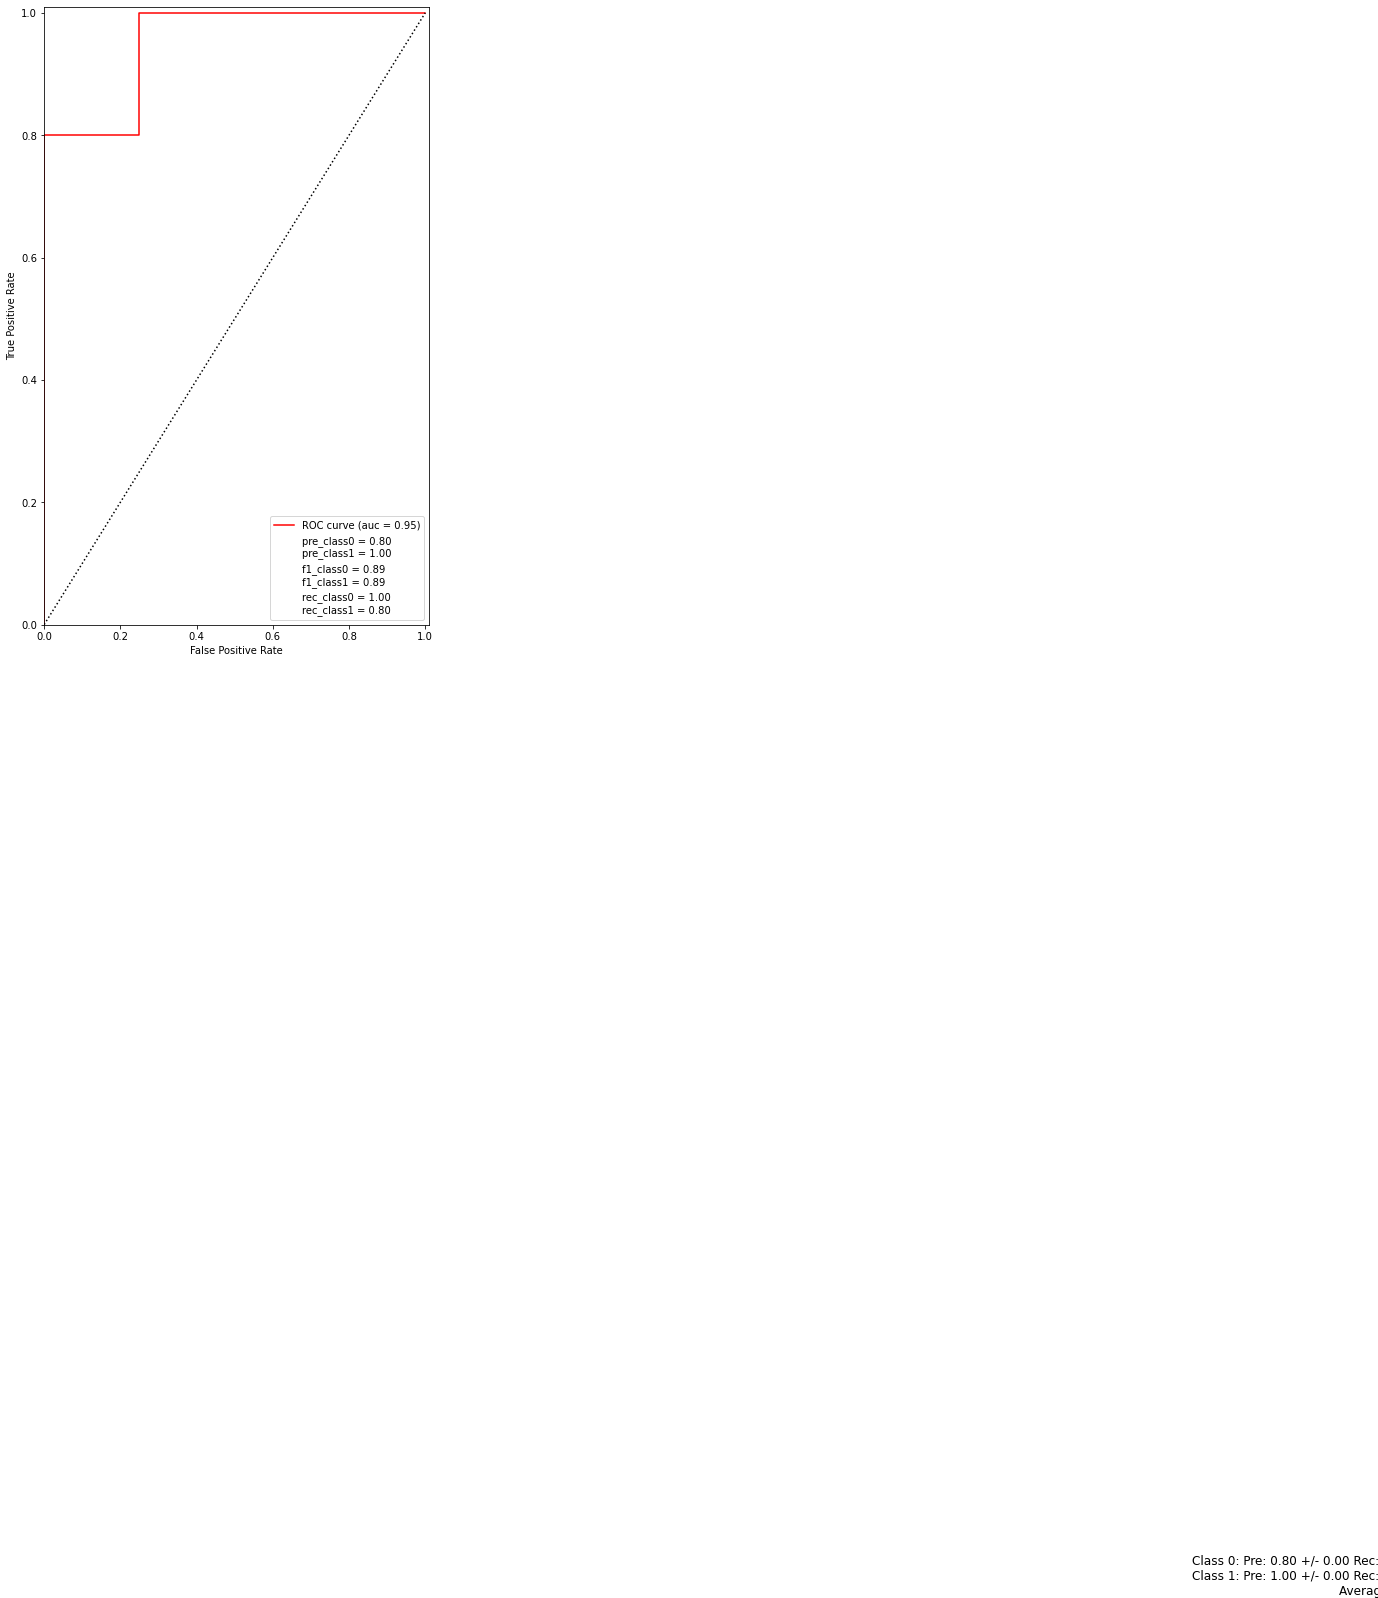


-----
Begin Logistic Regression
-----

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/matina/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature 

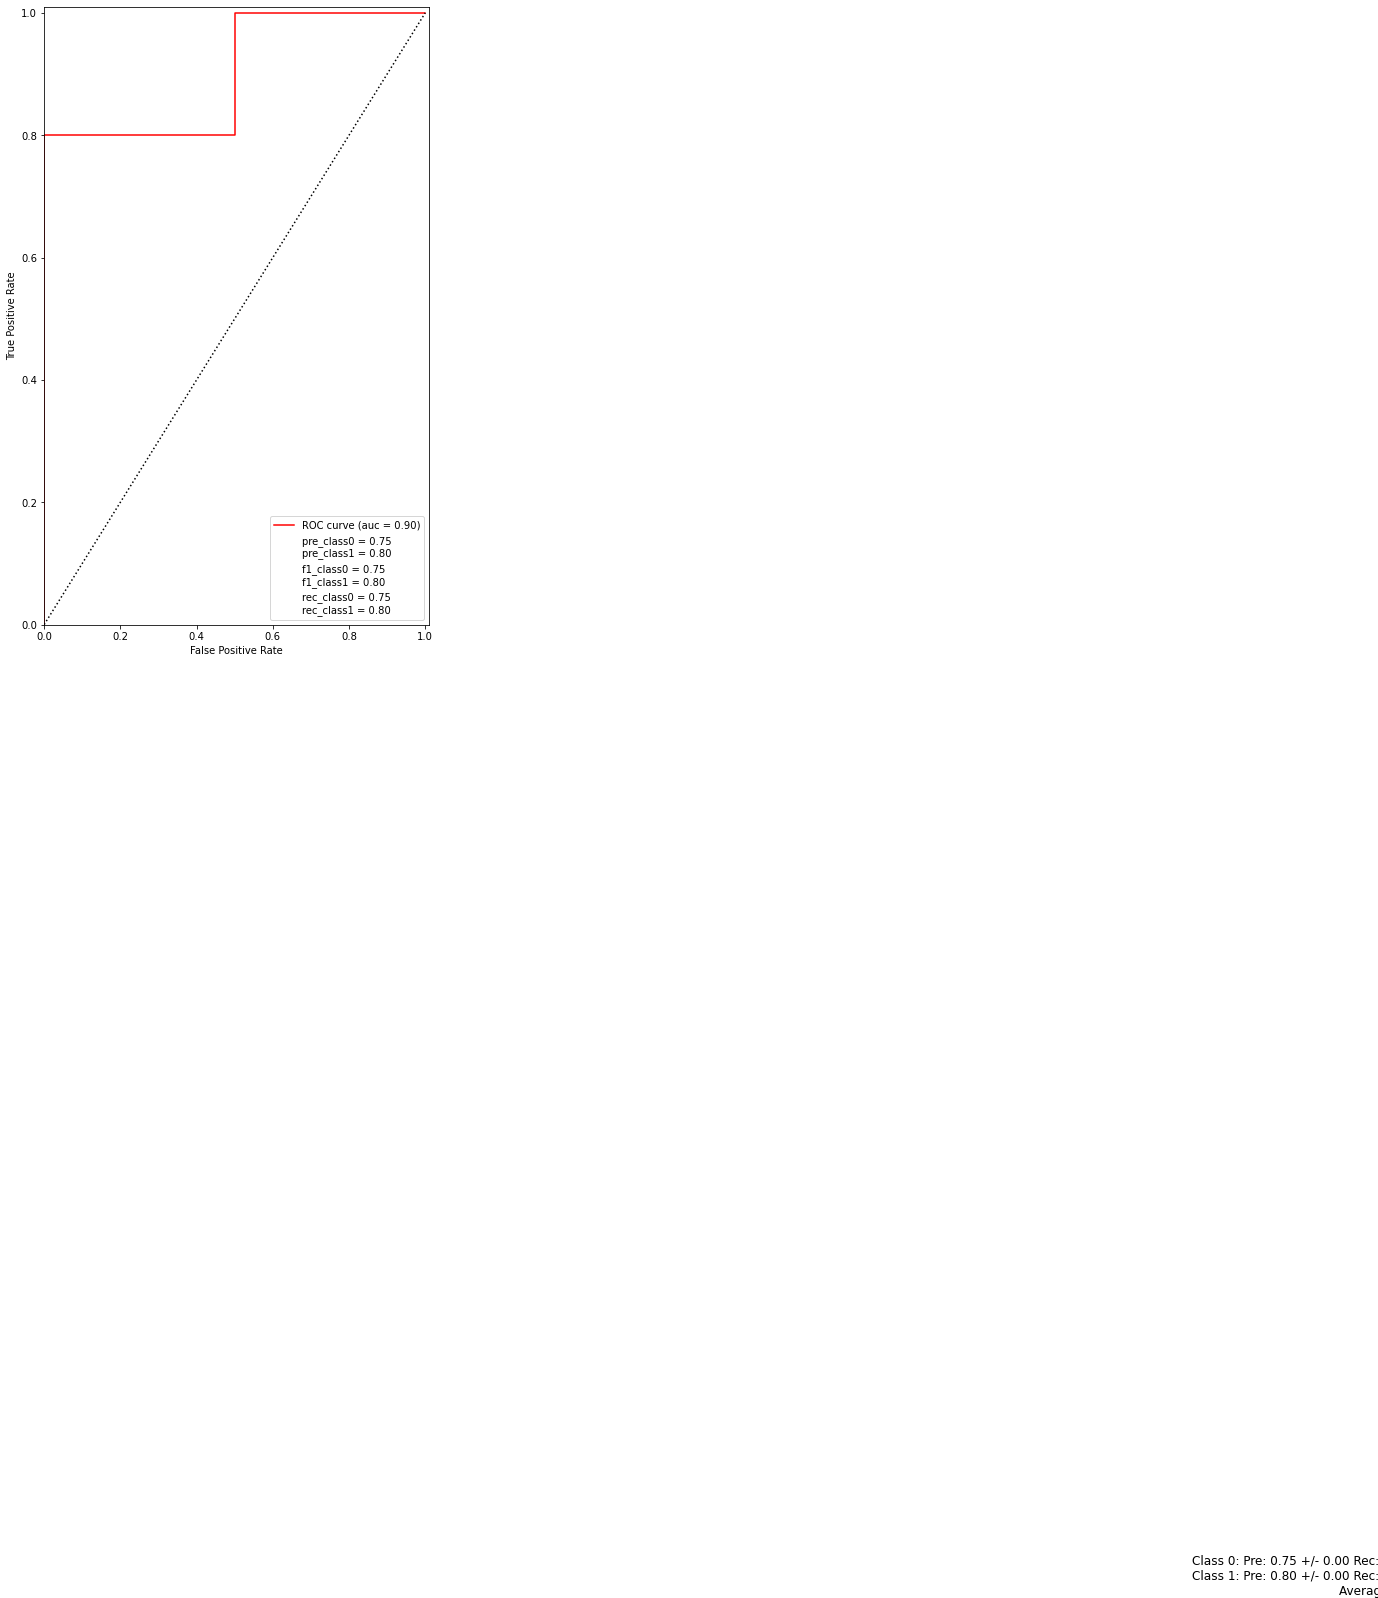

In [57]:
kfold_test_imbalenced_classifiers_with_optimization(Xtrain,Xtest, Ytrain , Ytest, kfold_classifiers, kfold_classifier_parameters, 
                                                        overwrite=True, cv=5, n_repeats=10,
                                                        random_seed=random_seed, clf_names=kfold_clf_names, class_labels=(0,1))

In [58]:
kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "ExtraTreesClassifier", "AdaBoost",
         "Logistic Regression"]

In [59]:
directory_names = cwf.directory_names_from_classfier_names(kfold_clf_names)


Nearest_Neighbors
-------------

Reading 0.csv
Saving plot to ddg_nearest_neighbors_morderd.png
['ddg_nearest_neighbors_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 0, 'fn': 1, 'tp': 4}
[[4 0]
 [1 4]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Gaussian_Process
-------------

Reading 0.csv
Saving plot to ddg_gaussian_process_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 0, 'fn': 1, 'tp': 4}
[[4 0]
 [1 4]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Decision_Tree
-------------

Reading 0.csv
Saving plot to ddg_decision_tree_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 3, 'fp': 1, 'fn': 2, 'tp': 3}
[[3 1]
 [2 3]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

ExtraTreesClassifier
-------------

Reading 0.csv
Saving plot to ddg_extratreesclassifier_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png', 'ddg_extratreesclassifier_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 2, 'fp': 2, 'fn': 0, 'tp': 5}
[[2 2]
 [0 5]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

AdaBoost
-------------

Reading 0.csv
Saving plot to ddg_adaboost_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png', 'ddg_extratreesclassifier_morderd.png', 'ddg_adaboost_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 4, 'fp': 0, 'fn': 1, 'tp': 4}
[[4 0]
 [1 4]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report

Logistic_Regression
-------------

Reading 0.csv
Saving plot to ddg_logistic_regression_morderd.png
['ddg_nearest_neighbors_morderd.png', 'ddg_gaussian_process_morderd.png', 'ddg_decision_tree_morderd.png', 'ddg_extratreesclassifier_morderd.png', 'ddg_adaboost_morderd.png', 'ddg_logistic_regression_morderd.png']
Attempting to calculate confusion based metrics
{'tn': 3, 'fp': 1, 'fn': 1, 'tp': 4}
[[3 1]
 [1 4]]
(0, 1)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Class', ylabel='Known Class'>

2
Support cannot be gotten from classification report
\begin{tabular}{lrrrrrr}
\toprule
{} &  accuracy &  sensitivity &  specificity &       mcc &  precision &    g-mean \\
\midrule
nearest neighbors      &  0.888889 &          0.8 &         1.00 &  0.800000 &   1.000000 &  0.894427 \\
gaussian process       &  0.888889 &          0.8 &         1.00 &  0.800000 &   1.000000 &  0.894427 \\
decision tree          &  0.666667 &          0.6 &         0.75 &  0.350000 &   0.750000 &  0.670820 \\
extra trees classifier &  0.777778 &          1.0 &         0.50 &  0.597614 &   0.714286 &  0.707107 \\
adaboost               &  0.888889 &          0.8 &         1.00 &  0.800000 &   1.000000 &  0.894427 \\
logistic regression    &  0.777778 &          0.8 &         0.75 &  0.550000 &   0.800000 &  0.774597 \\
\bottomrule
\end{tabular}



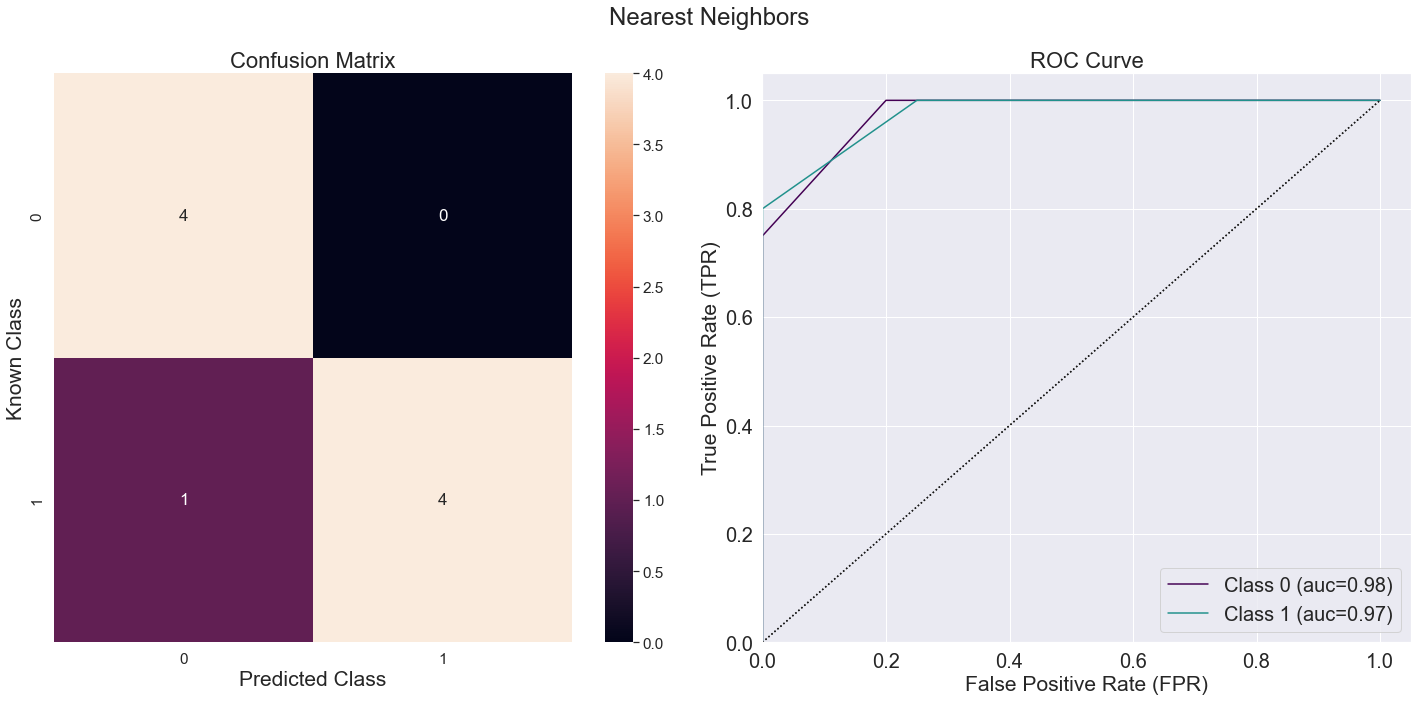

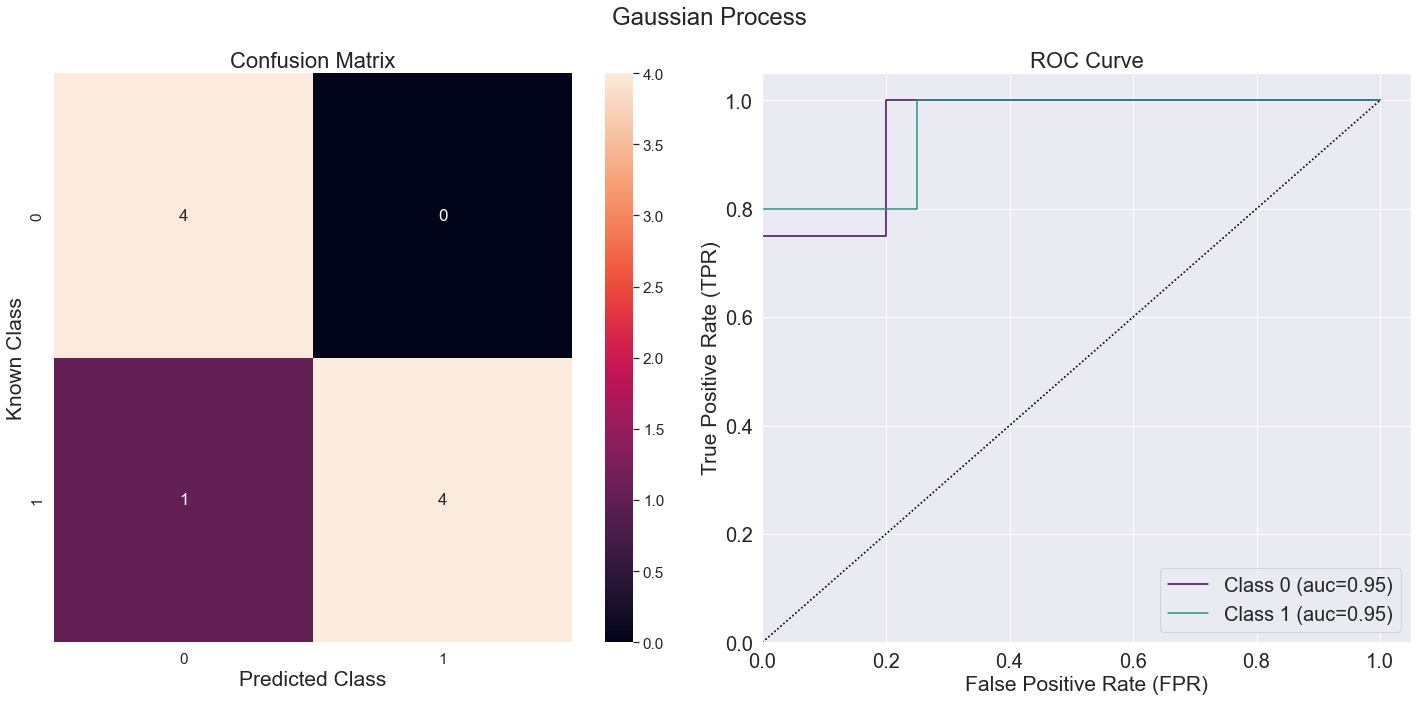

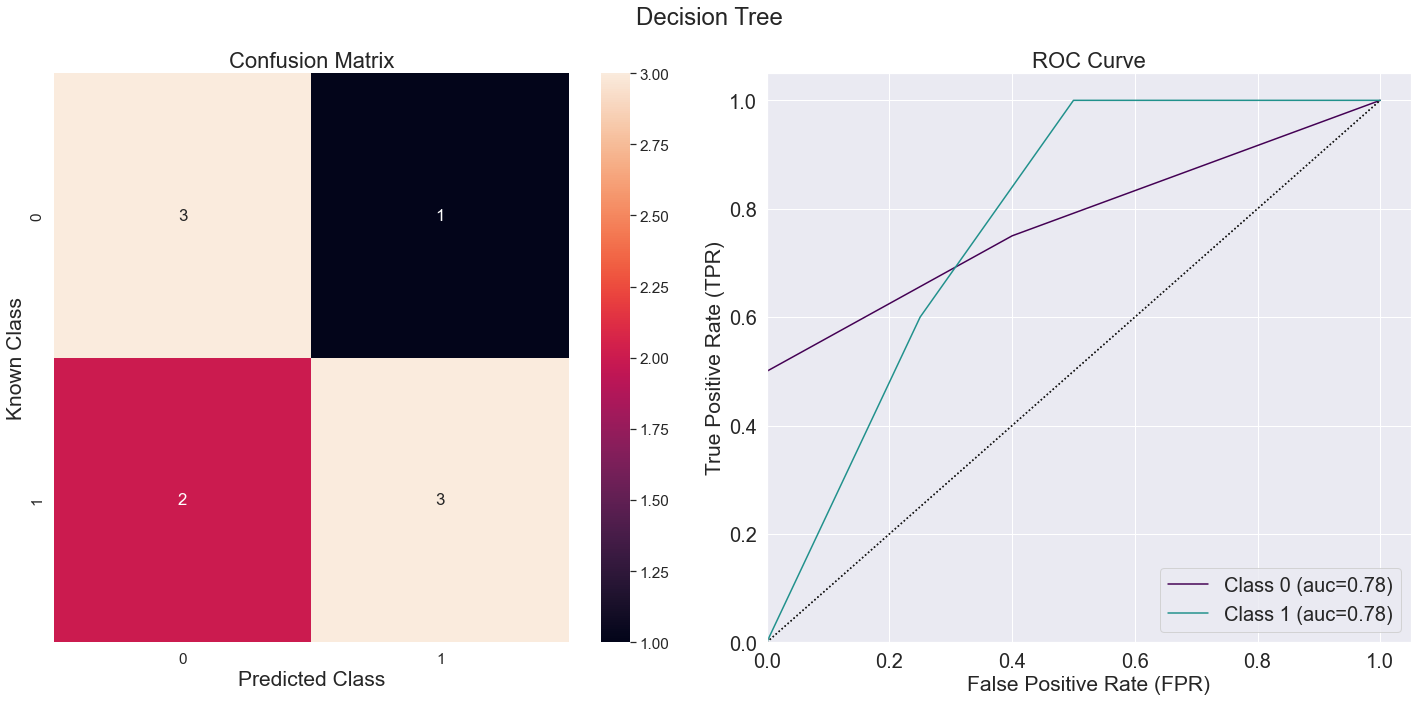

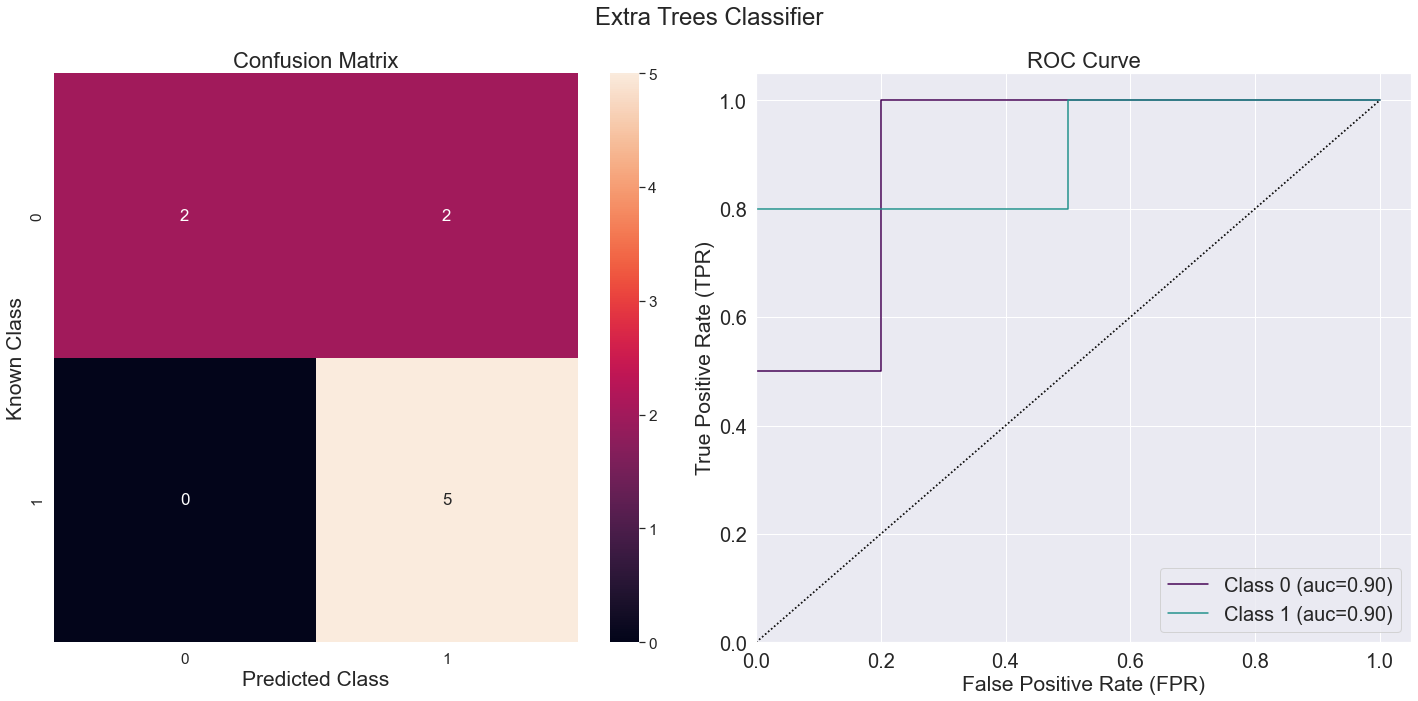

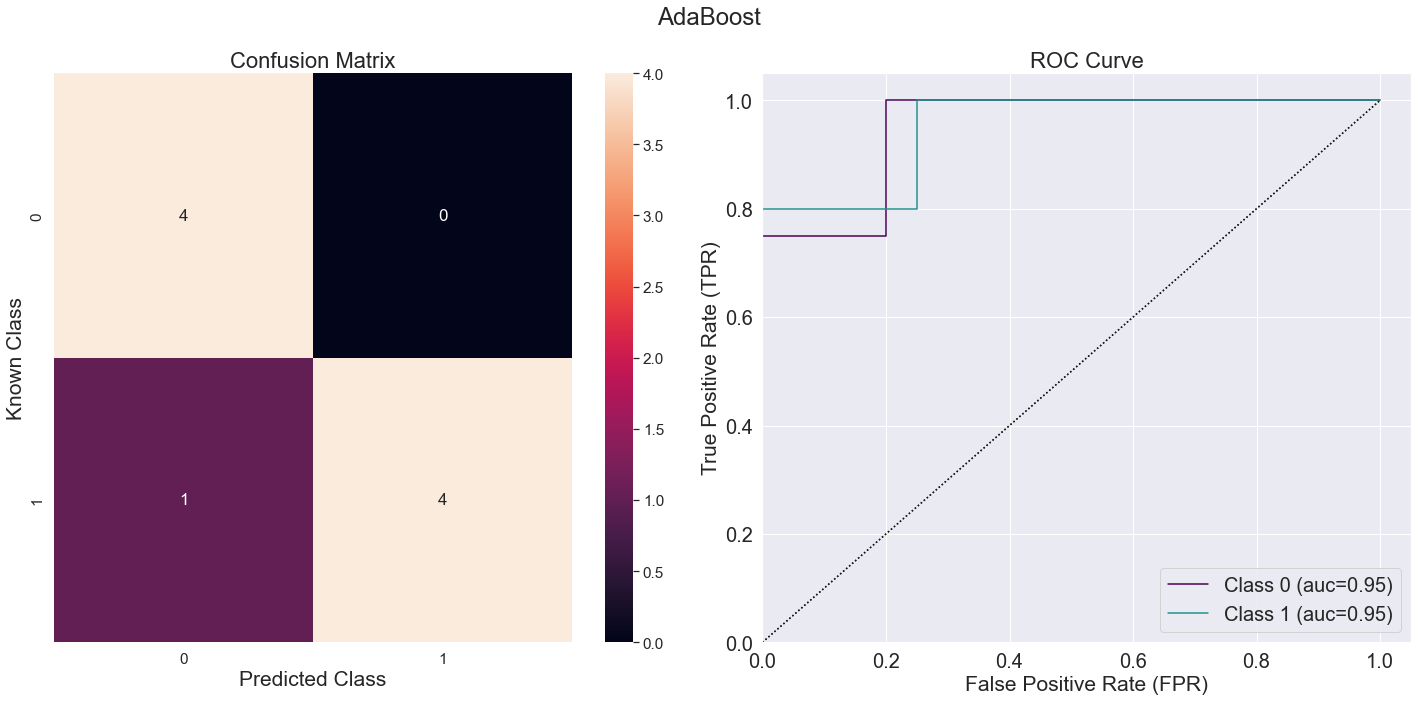

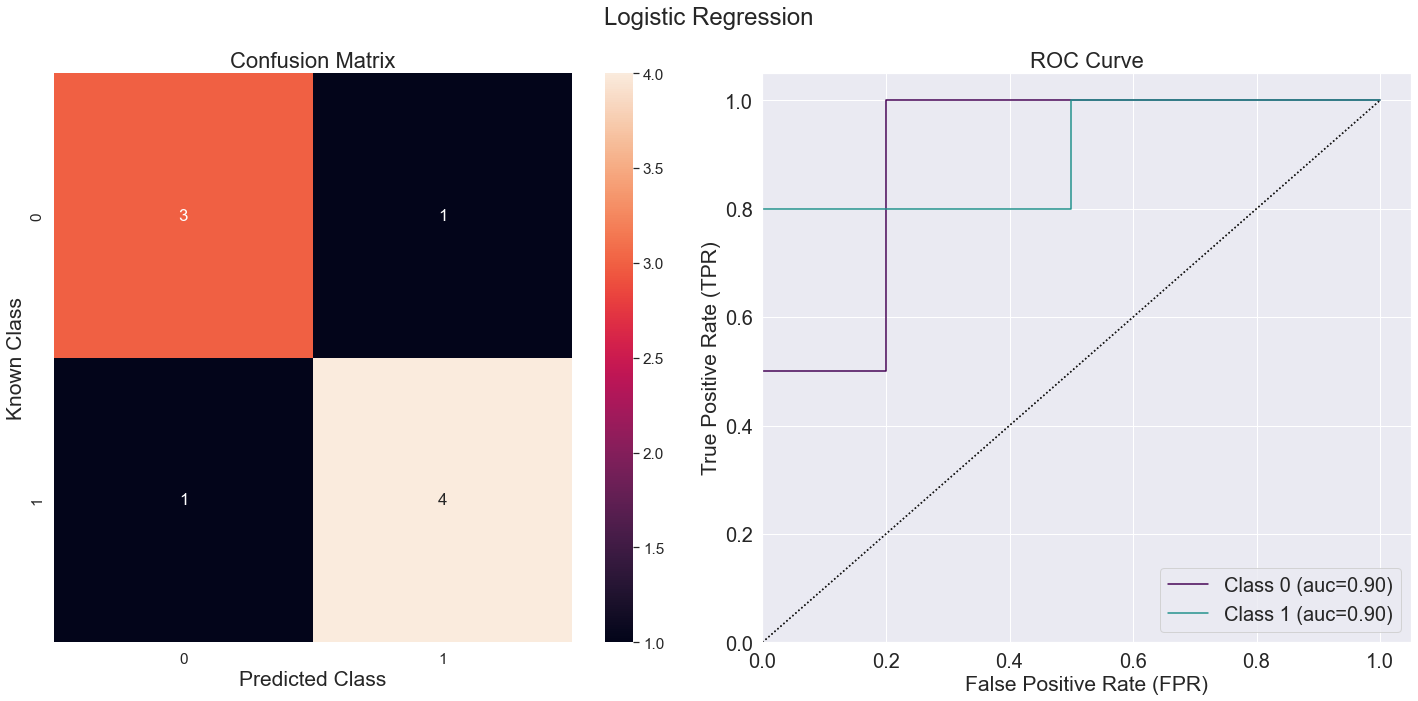

In [61]:
files_plt = []

kfold_clf_names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "Extra Trees Classifier", "AdaBoost",
         "Logistic Regression"]

for ith, dirname in enumerate(directory_names):
    log.info("\n{}\n-------------\n".format(dirname))
    data = cwf.build_data_from_directory(dirname, max_folds=1)
    
#     log.debug("Last value in the data frame: {}".format(data[165:166]))
    
    probs = data[["prob0", "prob1"]].to_numpy()
    log.debug("Probablities for a few examples {}".format(probs[0:3,0:2]))
    
    cm = cmetrics.get_confusion_matrix(data, predicted_column_name="prediction", known_column_name="known", return_dict=False)
    log.debug("Confusion matrix for {}\n{}".format(dirname, cm))
    
    plt_name = "ddg_{}_morderd.png".format("_".join([ent.lower() for ent in dirname.split()]))
    files_plt.append(plt_name)
    log.info("Saving plot to {}\n{}".format(plt_name, files_plt))
    metrics = cmetrics.calculate_confusion_based_metrics(df=data, probabilities=probs, col_map="viridis", positive_label=1, 
                                                         plt_filename=plt_name, all_classes=False, get_roc_curve=True, 
                                                         get_pr_curve=False, annotate=True, vmin=0, vmax=85,
                                                         title="{}".format(kfold_clf_names[ith]))
    #log.info("{}".format("\n".join(["{}: {}".format(k, v) for k, v in metrics.items()])))
    
    metrics_for_paper = {
    "accuracy": metrics["accuracy"],
    "sensitivity": metrics["tpr"],
    "specificity": metrics["tnr"],
    "mcc": metrics["matthews_correlation_coefficient"],
    "precision": metrics["precision"],
    "g-mean": metrics["g-mean"]
    }
    
    if ith == 0:
        df_metrics_for_paper = pd.DataFrame(data=metrics_for_paper, index=[kfold_clf_names[ith].lower()])
    else:
        df_metrics_for_paper = df_metrics_for_paper.append(pd.Series(metrics_for_paper, name=kfold_clf_names[ith].lower()))
    log.debug(df_metrics_for_paper)

with open("metrics_mordred.tex", "w") as fout:
    cap = "Classifier metrics for balanced data for ddg with models built from mordred features. MCC is the Matthew’s correlation coefficent."
    df_metrics_for_paper.to_latex(fout, float_format="{:0.2f}".format, position="H", caption=cap, label="tbl:mordred_features")
log.info(df_metrics_for_paper.to_latex())

In [62]:
images = [Image.open(x) for x in files_plt]
log.info("Combining {} images".format(len(images)))
widths, heights = zip(*(i.size for i in images))
log.info("{}".format("\n".join("W: {} H: {}".format(wid, hgt) for wid, hgt in zip(widths, heights))))
total_height = sum(heights)
total_width = max(widths)

log.info("New image will be W:{} H:{}".format(total_width, total_height))

combined_image = Image.new("RGBA", (total_width, total_height))
y_offset = 0
for ith, img in enumerate(images):
    log.info("Image {} added at offset height {}".format(ith, y_offset))
    combined_image.paste(img, (0, y_offset))
    y_offset = y_offset + img.size[1]

combined_image.save("combined_mordred.png")

Combining 6 images
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
W: 1440 H: 720
New image will be W:1440 H:4320
Image 0 added at offset height 0
Image 1 added at offset height 720
Image 2 added at offset height 1440
Image 3 added at offset height 2160
Image 4 added at offset height 2880
Image 5 added at offset height 3600


In [ ]:
customer.service@sainsburys.co.uk